# Configuration

In [1]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [2]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [3]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 325.68it/s]


In [4]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [5]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [6]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [7]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [8]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [9]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [10]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [11]:
RAV_train = []
RAV_val = []
RAV_test = []

In [12]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [13]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [14]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [15]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [16]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
happy        60
disgust      60
sadness      60
surprise     60
angry        60
fear         60
Name: emotion_label, dtype: int64

In [17]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [18]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [19]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [20]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [21]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [22]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [23]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
surprise     800
neutral      800
fear         800
sadness      800
disgust      800
happy        400
Name: emotion_label, dtype: int64

In [24]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [25]:
TESS_train = []
TESS_test = []

In [26]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [27]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [28]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [29]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [30]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [31]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [32]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [33]:
Crema_df.shape

(455, 4)

In [34]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [35]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [36]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [37]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [38]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [39]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [40]:
CREMA_df = pd.DataFrame(new_df)

In [41]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [42]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [43]:
count_males, count_females

(220, 220)

In [44]:
len(female_list)

44

In [45]:
len(male_list)

44

In [46]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [47]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [48]:
females_train, males_train, females_val, males_val, females_test, males_test

(['47',
  '84',
  '60',
  '06',
  '13',
  '24',
  '43',
  '02',
  '72',
  '18',
  '46',
  '91',
  '12',
  '04',
  '52',
  '61',
  '56',
  '89',
  '75',
  '21',
  '20',
  '79',
  '40',
  '73',
  '10',
  '53',
  '09',
  '54',
  '29',
  '78',
  '63',
  '25'],
 ['87',
  '69',
  '85',
  '01',
  '81',
  '42',
  '48',
  '57',
  '31',
  '83',
  '67',
  '39',
  '14',
  '26',
  '41',
  '68',
  '19',
  '27',
  '50',
  '70',
  '62',
  '33',
  '65',
  '23',
  '45',
  '66',
  '59',
  '32',
  '90',
  '64',
  '15',
  '11'],
 ['07', '74', '49', '03', '37', '55'],
 ['36', '05', '44', '71', '77', '35'],
 ['58', '76', '28', '08', '82', '30'],
 ['16', '38', '22', '34', '51', '86'])

In [49]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [50]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [51]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [52]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [53]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [54]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 

# Create Validation Datasets Ensemble

- validation_dataset_1 = RAVDESS_clean_val + RAVDESS_clean_test 
- validation_dataset_2 = all_clean_val + all_clean_test

In [55]:
validation_dataset_1 = pd.concat([RAV_val, RAV_test], ignore_index=True, sort=False)

In [56]:
validation_dataset_1

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
235,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
236,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
237,angry,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
238,surprise,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [57]:
validation_dataset_2 = pd.concat([RAV_val, RAV_test, 
                                    SAVEE_val, SAVEE_test, 
                                    TESS_test, 
                                    CREMA_val, CREMA_test], ignore_index=True, sort=False)

In [58]:
validation_dataset_2

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
1995,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1996,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1997,happy,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1998,happy,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


# Encode labels of Validation Datasets

In [59]:
labels_1 = list(validation_dataset_1.emotion_label)
labels_2 = list(validation_dataset_2.emotion_label)

In [60]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels_1 = pd.Series(labels_1).replace(emotion_enc)
labels_2 = pd.Series(labels_2).replace(emotion_enc)

# Utils Validation Ensemble

In [61]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [62]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [63]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [64]:
#!pip install scikit-learn==0.24.2

In [65]:
#!jupyter nbextension enable --py widgetsnbextension

In [66]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [67]:
def make_predictions(dataset, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        #print("True label", labels_1[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))
    

    
    
    

# Validation 1 - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [70]:
predictions, model_prediction_list = make_predictions(validation_dataset_1, prediction_scheme='majority')

  0%|          | 0/240 [00:00<?, ?it/s]

Prediction 0.21641621 Final prediction 0
Prediction 0.5239922 Final prediction 1
Prediction 0.58158255 Final prediction 1
Prediction 0.30858582 Final prediction 0
Prediction 0.6508572 Final prediction 1
Prediction 0.041726768 Final prediction 0
Prediction 0.04238221 Final prediction 0
Prediction 0.4568143 Final prediction 0
Prediction 0.14644936 Final prediction 0
Prediction 0.83928454 Final prediction 1
Prediction 0.051340163 Final prediction 0
Prediction 0.15365446 Final prediction 0
Prediction 0.5220866 Final prediction 1


  0%|          | 1/240 [00:12<51:27, 12.92s/it]

Prediction 0.76291114 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.23881468 Final prediction 0
Prediction 0.23238978 Final prediction 0
Prediction 0.47837257 Final prediction 0
Prediction 0.1241442 Final prediction 0
Prediction 0.22217038 Final prediction 0
Prediction 0.037085086 Final prediction 0
Prediction 0.43766502 Final prediction 0
Prediction 0.14850745 Final prediction 0
Prediction 0.12050754 Final prediction 0
Prediction 0.8437903 Final prediction 1
Prediction 0.008586615 Final prediction 0
Prediction 0.108226925 Final prediction 0
Prediction 0.49480218 Final prediction 0


  1%|          | 2/240 [00:24<49:17, 12.42s/it]

Prediction 0.37511432 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.8773644 Final prediction 1
Prediction 0.53234464 Final prediction 1
Prediction 0.6920152 Final prediction 1
Prediction 0.54796445 Final prediction 1
Prediction 0.61923593 Final prediction 1
Prediction 0.39383936 Final prediction 0
Prediction 0.071415395 Final prediction 0
Prediction 0.62995994 Final prediction 1
Prediction 0.33759505 Final prediction 0
Prediction 0.7763002 Final prediction 1
Prediction 0.30539095 Final prediction 0
Prediction 0.26301914 Final prediction 0
Prediction 0.4674505 Final prediction 0


  1%|▏         | 3/240 [00:33<45:25, 11.50s/it]

Prediction 0.93526584 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9998362 Final prediction 1
Prediction 0.968698 Final prediction 1
Prediction 0.91645896 Final prediction 1
Prediction 0.99755514 Final prediction 1
Prediction 0.87495863 Final prediction 1
Prediction 0.99896526 Final prediction 1
Prediction 0.38121837 Final prediction 0
Prediction 0.99931574 Final prediction 1
Prediction 0.9966487 Final prediction 1
Prediction 0.942219 Final prediction 1
Prediction 0.99973285 Final prediction 1
Prediction 0.9604449 Final prediction 1
Prediction 0.52000153 Final prediction 1


  2%|▏         | 4/240 [00:44<44:02, 11.20s/it]

Prediction 0.9981333 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9999989 Final prediction 1
Prediction 0.8537375 Final prediction 1
Prediction 0.8035034 Final prediction 1
Prediction 0.99833333 Final prediction 1
Prediction 0.74785537 Final prediction 1
Prediction 0.99710554 Final prediction 1
Prediction 0.43392307 Final prediction 0
Prediction 0.99758154 Final prediction 1
Prediction 0.9980047 Final prediction 1
Prediction 0.8524585 Final prediction 1
Prediction 0.99822825 Final prediction 1
Prediction 0.93465877 Final prediction 1
Prediction 0.500275 Final prediction 1


  2%|▏         | 5/240 [00:53<42:14, 10.79s/it]

Prediction 0.95345104 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.875298 Final prediction 1
Prediction 0.6432744 Final prediction 1
Prediction 0.5637859 Final prediction 1
Prediction 0.5581343 Final prediction 1
Prediction 0.64597964 Final prediction 1
Prediction 0.6435024 Final prediction 1
Prediction 0.18371856 Final prediction 0
Prediction 0.6877435 Final prediction 1
Prediction 0.9017129 Final prediction 1
Prediction 0.42770544 Final prediction 0
Prediction 0.75098974 Final prediction 1
Prediction 0.5068263 Final prediction 1
Prediction 0.5078153 Final prediction 1


  2%|▎         | 6/240 [01:04<41:32, 10.65s/it]

Prediction 0.8467647 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.09932616 Final prediction 0
Prediction 0.1290468 Final prediction 0
Prediction 0.3864693 Final prediction 0
Prediction 0.5416309 Final prediction 1
Prediction 0.37028164 Final prediction 0
Prediction 0.70037454 Final prediction 1
Prediction 0.7512245 Final prediction 1
Prediction 0.31902233 Final prediction 0
Prediction 0.3363034 Final prediction 0
Prediction 0.7805269 Final prediction 1
Prediction 0.1565915 Final prediction 0
Prediction 0.36729842 Final prediction 0
Prediction 0.44491675 Final prediction 0


  3%|▎         | 7/240 [01:14<41:00, 10.56s/it]

Prediction 0.55312234 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 0
Prediction 0.29147953 Final prediction 0
Prediction 0.35309082 Final prediction 0
Prediction 0.7915098 Final prediction 1
Prediction 0.3572646 Final prediction 0
Prediction 0.6096548 Final prediction 1
Prediction 0.4179651 Final prediction 0
Prediction 0.6114118 Final prediction 1
Prediction 0.91789085 Final prediction 1
Prediction 0.5172618 Final prediction 1
Prediction 0.8075999 Final prediction 1
Prediction 0.077617526 Final prediction 0
Prediction 0.16500932 Final prediction 0
Prediction 0.47724432 Final prediction 0


  3%|▎         | 8/240 [01:25<41:16, 10.68s/it]

Prediction 0.9611747 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9999833 Final prediction 1
Prediction 0.9632569 Final prediction 1
Prediction 0.65962887 Final prediction 1
Prediction 0.9987427 Final prediction 1
Prediction 0.97985405 Final prediction 1
Prediction 0.991269 Final prediction 1
Prediction 0.23816392 Final prediction 0
Prediction 0.999863 Final prediction 1
Prediction 0.9839262 Final prediction 1
Prediction 0.71100813 Final prediction 1
Prediction 0.9999816 Final prediction 1
Prediction 0.7604708 Final prediction 1
Prediction 0.4767112 Final prediction 0


  4%|▍         | 9/240 [01:35<40:53, 10.62s/it]

Prediction 0.99934244 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.89383864 Final prediction 1
Prediction 0.27684343 Final prediction 0
Prediction 0.49508628 Final prediction 0
Prediction 0.8727783 Final prediction 1
Prediction 0.6761825 Final prediction 1
Prediction 0.5223466 Final prediction 1
Prediction 0.086230814 Final prediction 0
Prediction 0.9241447 Final prediction 1
Prediction 0.72793573 Final prediction 1
Prediction 0.61534613 Final prediction 1
Prediction 0.9316283 Final prediction 1
Prediction 0.18844497 Final prediction 0
Prediction 0.46786433 Final prediction 0


  4%|▍         | 10/240 [01:45<39:46, 10.37s/it]

Prediction 0.7138615 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.007938176 Final prediction 0
Prediction 0.18022609 Final prediction 0
Prediction 0.22285742 Final prediction 0
Prediction 0.32732117 Final prediction 0
Prediction 0.14466563 Final prediction 0
Prediction 0.081315875 Final prediction 0
Prediction 0.013608873 Final prediction 0
Prediction 0.16794026 Final prediction 0
Prediction 0.060610563 Final prediction 0
Prediction 0.79741 Final prediction 1
Prediction 0.012480378 Final prediction 0
Prediction 0.13118204 Final prediction 0
Prediction 0.49185154 Final prediction 0


  5%|▍         | 11/240 [01:57<41:37, 10.91s/it]

Prediction 0.4786618 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.00016397238 Final prediction 0
Prediction 0.082203895 Final prediction 0
Prediction 0.39551663 Final prediction 0
Prediction 0.050910264 Final prediction 0
Prediction 0.18279889 Final prediction 0
Prediction 0.012466013 Final prediction 0
Prediction 0.37449914 Final prediction 0
Prediction 0.07903898 Final prediction 0
Prediction 0.0664936 Final prediction 0
Prediction 0.74493265 Final prediction 1
Prediction 0.0003992319 Final prediction 0
Prediction 0.01046741 Final prediction 0
Prediction 0.42332953 Final prediction 0


  5%|▌         | 12/240 [02:08<40:54, 10.76s/it]

Prediction 0.8698976 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0035049021 Final prediction 0
Prediction 0.10861117 Final prediction 0
Prediction 0.5477941 Final prediction 1
Prediction 0.15144655 Final prediction 0
Prediction 0.304519 Final prediction 0
Prediction 0.01757142 Final prediction 0
Prediction 0.34464282 Final prediction 0
Prediction 0.06449264 Final prediction 0
Prediction 0.1808863 Final prediction 0
Prediction 0.4987303 Final prediction 0
Prediction 0.20573708 Final prediction 0
Prediction 0.20501599 Final prediction 0
Prediction 0.50753546 Final prediction 1


  5%|▌         | 13/240 [02:18<40:24, 10.68s/it]

Prediction 0.5965286 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.004057348 Final prediction 0
Prediction 0.044844687 Final prediction 0
Prediction 0.14799494 Final prediction 0
Prediction 0.29980865 Final prediction 0
Prediction 0.2621013 Final prediction 0
Prediction 0.0029592812 Final prediction 0
Prediction 0.30463743 Final prediction 0
Prediction 0.06613684 Final prediction 0
Prediction 0.31162086 Final prediction 0
Prediction 0.74084127 Final prediction 1
Prediction 0.0055773854 Final prediction 0
Prediction 0.11109111 Final prediction 0
Prediction 0.416793 Final prediction 0


  6%|▌         | 14/240 [02:28<39:38, 10.52s/it]

Prediction 0.8163753 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.0013813078 Final prediction 0
Prediction 0.072069556 Final prediction 0
Prediction 0.080460995 Final prediction 0
Prediction 0.12834236 Final prediction 0
Prediction 0.26433092 Final prediction 0
Prediction 0.019417912 Final prediction 0
Prediction 0.47522533 Final prediction 0
Prediction 0.044494957 Final prediction 0
Prediction 0.101769924 Final prediction 0
Prediction 0.88245064 Final prediction 1
Prediction 0.009978384 Final prediction 0
Prediction 0.01938954 Final prediction 0
Prediction 0.47602114 Final prediction 0


  6%|▋         | 15/240 [02:39<39:22, 10.50s/it]

Prediction 0.6462381 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.009613156 Final prediction 0
Prediction 0.06994343 Final prediction 0
Prediction 0.2482191 Final prediction 0
Prediction 0.03483677 Final prediction 0
Prediction 0.09298572 Final prediction 0
Prediction 0.043678492 Final prediction 0
Prediction 0.22160918 Final prediction 0
Prediction 0.037418425 Final prediction 0
Prediction 0.03565991 Final prediction 0
Prediction 0.85243356 Final prediction 1
Prediction 0.0018900633 Final prediction 0
Prediction 0.088498235 Final prediction 0
Prediction 0.4537289 Final prediction 0


  7%|▋         | 16/240 [02:49<38:26, 10.30s/it]

Prediction 0.23407376 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0005084574 Final prediction 0
Prediction 0.03977865 Final prediction 0
Prediction 0.09389454 Final prediction 0
Prediction 0.023767501 Final prediction 0
Prediction 0.09259054 Final prediction 0
Prediction 0.0009531975 Final prediction 0
Prediction 0.11230618 Final prediction 0
Prediction 0.020337373 Final prediction 0
Prediction 0.0062763095 Final prediction 0
Prediction 0.77906924 Final prediction 1
Prediction 0.00021108985 Final prediction 0
Prediction 0.0047115386 Final prediction 0
Prediction 0.45932144 Final prediction 0


  7%|▋         | 17/240 [03:00<38:46, 10.43s/it]

Prediction 0.52435493 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0023641884 Final prediction 0
Prediction 0.106321186 Final prediction 0
Prediction 0.14060056 Final prediction 0
Prediction 0.35770988 Final prediction 0
Prediction 0.35342836 Final prediction 0
Prediction 0.020763665 Final prediction 0
Prediction 0.42648804 Final prediction 0
Prediction 0.045330197 Final prediction 0
Prediction 0.032136977 Final prediction 0
Prediction 0.80124605 Final prediction 1
Prediction 0.002831161 Final prediction 0
Prediction 0.02366066 Final prediction 0
Prediction 0.45791817 Final prediction 0


  8%|▊         | 18/240 [03:09<38:05, 10.29s/it]

Prediction 0.95714307 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.0046785176 Final prediction 0
Prediction 0.049465477 Final prediction 0
Prediction 0.244396 Final prediction 0
Prediction 0.05967331 Final prediction 0
Prediction 0.12516552 Final prediction 0
Prediction 0.02351737 Final prediction 0
Prediction 0.21561953 Final prediction 0
Prediction 0.026587248 Final prediction 0
Prediction 0.30493587 Final prediction 0
Prediction 0.73881435 Final prediction 1
Prediction 0.0017937422 Final prediction 0
Prediction 0.015236139 Final prediction 0
Prediction 0.46074024 Final prediction 0


  8%|▊         | 19/240 [03:19<37:30, 10.18s/it]

Prediction 0.08052993 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0028773546 Final prediction 0
Prediction 0.025414884 Final prediction 0
Prediction 0.3727333 Final prediction 0
Prediction 0.0346314 Final prediction 0
Prediction 0.047501206 Final prediction 0
Prediction 0.02590856 Final prediction 0
Prediction 0.91136074 Final prediction 1
Prediction 0.035298675 Final prediction 0
Prediction 0.27012557 Final prediction 0
Prediction 0.93626463 Final prediction 1
Prediction 0.017173737 Final prediction 0
Prediction 0.04159707 Final prediction 0
Prediction 0.4366059 Final prediction 0


  8%|▊         | 20/240 [03:29<36:46, 10.03s/it]

Prediction 0.21820289 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.2606861 Final prediction 0
Prediction 0.6103396 Final prediction 1
Prediction 0.68717843 Final prediction 1
Prediction 0.48564124 Final prediction 0
Prediction 0.62311995 Final prediction 1
Prediction 0.20328525 Final prediction 0
Prediction 0.50123537 Final prediction 1
Prediction 0.50250226 Final prediction 1
Prediction 0.33484936 Final prediction 0
Prediction 0.7076485 Final prediction 1
Prediction 0.13447553 Final prediction 0
Prediction 0.28722864 Final prediction 0
Prediction 0.4922103 Final prediction 0


  9%|▉         | 21/240 [03:40<37:06, 10.17s/it]

Prediction 0.88710666 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.100130886 Final prediction 0
Prediction 0.14164662 Final prediction 0
Prediction 0.44266382 Final prediction 0
Prediction 0.10507378 Final prediction 0
Prediction 0.12630635 Final prediction 0
Prediction 0.0110832155 Final prediction 0
Prediction 0.076440424 Final prediction 0
Prediction 0.032206625 Final prediction 0
Prediction 0.016210526 Final prediction 0
Prediction 0.7882656 Final prediction 1
Prediction 0.0019490719 Final prediction 0
Prediction 0.037200034 Final prediction 0
Prediction 0.48874813 Final prediction 0


  9%|▉         | 22/240 [03:50<36:53, 10.15s/it]

Prediction 0.46452522 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.9998626 Final prediction 1
Prediction 0.9509872 Final prediction 1
Prediction 0.8373591 Final prediction 1
Prediction 0.99714 Final prediction 1
Prediction 0.89648867 Final prediction 1
Prediction 0.9978381 Final prediction 1
Prediction 0.14547032 Final prediction 0
Prediction 0.9973928 Final prediction 1
Prediction 0.9943133 Final prediction 1
Prediction 0.7748785 Final prediction 1
Prediction 0.9994203 Final prediction 1
Prediction 0.9286625 Final prediction 1
Prediction 0.49976093 Final prediction 0


 10%|▉         | 23/240 [03:59<36:17, 10.03s/it]

Prediction 0.9945072 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.81787 Final prediction 1
Prediction 0.39050132 Final prediction 0
Prediction 0.6356747 Final prediction 1
Prediction 0.50519055 Final prediction 1
Prediction 0.38457906 Final prediction 0
Prediction 0.53273755 Final prediction 1
Prediction 0.5090458 Final prediction 1
Prediction 0.72632587 Final prediction 1
Prediction 0.46834862 Final prediction 0
Prediction 0.8903112 Final prediction 1
Prediction 0.90635145 Final prediction 1
Prediction 0.65314347 Final prediction 1
Prediction 0.49348733 Final prediction 0


 10%|█         | 24/240 [04:10<36:31, 10.15s/it]

Prediction 0.5819799 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.60470176 Final prediction 1
Prediction 0.58450025 Final prediction 1
Prediction 0.6725246 Final prediction 1
Prediction 0.38998657 Final prediction 0
Prediction 0.53628653 Final prediction 1
Prediction 0.31873935 Final prediction 0
Prediction 0.083329916 Final prediction 0
Prediction 0.81814575 Final prediction 1
Prediction 0.109396875 Final prediction 0
Prediction 0.8058043 Final prediction 1
Prediction 0.19686398 Final prediction 0
Prediction 0.43859276 Final prediction 0
Prediction 0.5292733 Final prediction 1


 10%|█         | 25/240 [04:19<35:19,  9.86s/it]

Prediction 0.8730811 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.99631006 Final prediction 1
Prediction 0.9417774 Final prediction 1
Prediction 0.9358155 Final prediction 1
Prediction 0.6566783 Final prediction 1
Prediction 0.81256545 Final prediction 1
Prediction 0.98361033 Final prediction 1
Prediction 0.87062 Final prediction 1
Prediction 0.99838907 Final prediction 1
Prediction 0.5879277 Final prediction 1
Prediction 0.9119197 Final prediction 1
Prediction 0.8662169 Final prediction 1
Prediction 0.8068817 Final prediction 1
Prediction 0.5212541 Final prediction 1


 11%|█         | 26/240 [04:29<34:45,  9.75s/it]

Prediction 0.9841045 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.994912 Final prediction 1
Prediction 0.88187873 Final prediction 1
Prediction 0.6755935 Final prediction 1
Prediction 0.9802916 Final prediction 1
Prediction 0.92234796 Final prediction 1
Prediction 0.9381533 Final prediction 1
Prediction 0.229067 Final prediction 0
Prediction 0.99333763 Final prediction 1
Prediction 0.87561804 Final prediction 1
Prediction 0.7029169 Final prediction 1
Prediction 0.99715966 Final prediction 1
Prediction 0.62797135 Final prediction 1
Prediction 0.47245717 Final prediction 0


 11%|█▏        | 27/240 [04:37<33:44,  9.51s/it]

Prediction 0.9988061 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.060488284 Final prediction 0
Prediction 0.24807909 Final prediction 0
Prediction 0.3124246 Final prediction 0
Prediction 0.5234891 Final prediction 1
Prediction 0.3979897 Final prediction 0
Prediction 0.4574497 Final prediction 0
Prediction 0.7929969 Final prediction 1
Prediction 0.3188455 Final prediction 0
Prediction 0.8247632 Final prediction 1
Prediction 0.93841654 Final prediction 1
Prediction 0.669557 Final prediction 1
Prediction 0.13260904 Final prediction 0
Prediction 0.46458143 Final prediction 0


 12%|█▏        | 28/240 [04:47<33:21,  9.44s/it]

Prediction 0.87434137 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0
Prediction 0.24694729 Final prediction 0
Prediction 0.5003193 Final prediction 1
Prediction 0.564107 Final prediction 1
Prediction 0.59108895 Final prediction 1
Prediction 0.5846003 Final prediction 1
Prediction 0.32902646 Final prediction 0
Prediction 0.16366991 Final prediction 0
Prediction 0.9555172 Final prediction 1
Prediction 0.12974739 Final prediction 0
Prediction 0.6564417 Final prediction 1
Prediction 0.20729846 Final prediction 0
Prediction 0.21750659 Final prediction 0
Prediction 0.50242937 Final prediction 1


 12%|█▏        | 29/240 [04:56<32:57,  9.37s/it]

Prediction 0.7271526 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9873757 Final prediction 1
Prediction 0.8043901 Final prediction 1
Prediction 0.7469157 Final prediction 1
Prediction 0.65376616 Final prediction 1
Prediction 0.7747524 Final prediction 1
Prediction 0.94111437 Final prediction 1
Prediction 0.66825926 Final prediction 1
Prediction 0.91410154 Final prediction 1
Prediction 0.84510505 Final prediction 1
Prediction 0.8109822 Final prediction 1
Prediction 0.9739636 Final prediction 1
Prediction 0.4397444 Final prediction 0
Prediction 0.47377414 Final prediction 0


 12%|█▎        | 30/240 [05:05<32:18,  9.23s/it]

Prediction 0.9780086 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.006125152 Final prediction 0
Prediction 0.06384799 Final prediction 0
Prediction 0.15045515 Final prediction 0
Prediction 0.1431939 Final prediction 0
Prediction 0.19977576 Final prediction 0
Prediction 0.0014824569 Final prediction 0
Prediction 0.1732724 Final prediction 0
Prediction 0.023329139 Final prediction 0
Prediction 0.10453138 Final prediction 0
Prediction 0.8550251 Final prediction 1
Prediction 0.001939863 Final prediction 0
Prediction 0.028170645 Final prediction 0
Prediction 0.45231664 Final prediction 0


 13%|█▎        | 31/240 [05:17<34:42,  9.96s/it]

Prediction 0.35925806 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.00050005317 Final prediction 0
Prediction 0.0911946 Final prediction 0
Prediction 0.1776807 Final prediction 0
Prediction 0.11124295 Final prediction 0
Prediction 0.2394697 Final prediction 0
Prediction 0.0032182336 Final prediction 0
Prediction 0.22696653 Final prediction 0
Prediction 0.024733275 Final prediction 0
Prediction 0.12448043 Final prediction 0
Prediction 0.84871954 Final prediction 1
Prediction 0.009555012 Final prediction 0
Prediction 0.057560086 Final prediction 0
Prediction 0.4525851 Final prediction 0


 13%|█▎        | 32/240 [05:28<35:38, 10.28s/it]

Prediction 0.7545321 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.0026976168 Final prediction 0
Prediction 0.18960431 Final prediction 0
Prediction 0.652476 Final prediction 1
Prediction 0.07853204 Final prediction 0
Prediction 0.471629 Final prediction 0
Prediction 0.02218467 Final prediction 0
Prediction 0.5640219 Final prediction 1
Prediction 0.03569165 Final prediction 0
Prediction 0.47103044 Final prediction 0
Prediction 0.8201511 Final prediction 1
Prediction 0.0184592 Final prediction 0
Prediction 0.14246482 Final prediction 0
Prediction 0.48213518 Final prediction 0


 14%|█▍        | 33/240 [05:38<35:12, 10.20s/it]

Prediction 0.92815214 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.00057801604 Final prediction 0
Prediction 0.080833286 Final prediction 0
Prediction 0.32990804 Final prediction 0
Prediction 0.024254084 Final prediction 0
Prediction 0.13013229 Final prediction 0
Prediction 0.016676217 Final prediction 0
Prediction 0.21290016 Final prediction 0
Prediction 0.069609016 Final prediction 0
Prediction 0.015630454 Final prediction 0
Prediction 0.72995687 Final prediction 1
Prediction 7.1432085e-05 Final prediction 0
Prediction 0.034211397 Final prediction 0
Prediction 0.42092192 Final prediction 0


 14%|█▍        | 34/240 [05:47<33:50,  9.86s/it]

Prediction 0.2971077 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.16299435 Final prediction 0
Prediction 0.100121915 Final prediction 0
Prediction 0.18942794 Final prediction 0
Prediction 0.38374925 Final prediction 0
Prediction 0.12377486 Final prediction 0
Prediction 0.102915585 Final prediction 0
Prediction 0.021066546 Final prediction 0
Prediction 0.085879 Final prediction 0
Prediction 0.0055887103 Final prediction 0
Prediction 0.87929237 Final prediction 1
Prediction 0.022185087 Final prediction 0
Prediction 0.079606384 Final prediction 0
Prediction 0.49276146 Final prediction 0


 15%|█▍        | 35/240 [05:56<33:07,  9.69s/it]

Prediction 0.44327903 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.09454417 Final prediction 0
Prediction 0.055541426 Final prediction 0
Prediction 0.32224184 Final prediction 0
Prediction 0.09648144 Final prediction 0
Prediction 0.062886655 Final prediction 0
Prediction 0.14758039 Final prediction 0
Prediction 0.40481693 Final prediction 0
Prediction 0.015933782 Final prediction 0
Prediction 0.2837659 Final prediction 0
Prediction 0.7481515 Final prediction 1
Prediction 0.024262935 Final prediction 0
Prediction 0.00983876 Final prediction 0
Prediction 0.4672711 Final prediction 0


 15%|█▌        | 36/240 [06:05<32:42,  9.62s/it]

Prediction 0.0354667 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.17183965 Final prediction 0
Prediction 0.31836677 Final prediction 0
Prediction 0.6341913 Final prediction 1
Prediction 0.3720193 Final prediction 0
Prediction 0.46409923 Final prediction 0
Prediction 0.08160013 Final prediction 0
Prediction 0.033450574 Final prediction 0
Prediction 0.33644277 Final prediction 0
Prediction 0.076660454 Final prediction 0
Prediction 0.8286736 Final prediction 1
Prediction 0.02959311 Final prediction 0
Prediction 0.13098657 Final prediction 0
Prediction 0.5126872 Final prediction 1


 15%|█▌        | 37/240 [06:15<32:14,  9.53s/it]

Prediction 0.8486316 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.8201847 Final prediction 1
Prediction 0.32969147 Final prediction 0
Prediction 0.48572183 Final prediction 0
Prediction 0.5666899 Final prediction 1
Prediction 0.49135628 Final prediction 0
Prediction 0.6372207 Final prediction 1
Prediction 0.029443264 Final prediction 0
Prediction 0.88429356 Final prediction 1
Prediction 0.454054 Final prediction 0
Prediction 0.7376634 Final prediction 1
Prediction 0.8093833 Final prediction 1
Prediction 0.0630689 Final prediction 0
Prediction 0.5260394 Final prediction 1


 16%|█▌        | 38/240 [06:24<31:56,  9.49s/it]

Prediction 0.32004133 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.99994636 Final prediction 1
Prediction 0.8942379 Final prediction 1
Prediction 0.729488 Final prediction 1
Prediction 0.998664 Final prediction 1
Prediction 0.9588661 Final prediction 1
Prediction 0.98673105 Final prediction 1
Prediction 0.42550346 Final prediction 0
Prediction 0.9971291 Final prediction 1
Prediction 0.99148977 Final prediction 1
Prediction 0.75553274 Final prediction 1
Prediction 0.99997795 Final prediction 1
Prediction 0.66305506 Final prediction 1
Prediction 0.48440617 Final prediction 0


 16%|█▋        | 39/240 [06:33<31:10,  9.30s/it]

Prediction 0.9993045 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.25732917 Final prediction 0
Prediction 0.7377053 Final prediction 1
Prediction 0.7120875 Final prediction 1
Prediction 0.48099735 Final prediction 0
Prediction 0.7756579 Final prediction 1
Prediction 0.5638784 Final prediction 1
Prediction 0.2643259 Final prediction 0
Prediction 0.953649 Final prediction 1
Prediction 0.7170125 Final prediction 1
Prediction 0.72334784 Final prediction 1
Prediction 0.739306 Final prediction 1
Prediction 0.48540118 Final prediction 0
Prediction 0.49365932 Final prediction 0


 17%|█▋        | 40/240 [06:42<31:12,  9.36s/it]

Prediction 0.9903592 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.005808115 Final prediction 0
Prediction 0.30559564 Final prediction 0
Prediction 0.6236475 Final prediction 1
Prediction 0.25655323 Final prediction 0
Prediction 0.6533104 Final prediction 1
Prediction 0.15842074 Final prediction 0
Prediction 0.75894344 Final prediction 1
Prediction 0.32450888 Final prediction 0
Prediction 0.40465415 Final prediction 0
Prediction 0.90983635 Final prediction 1
Prediction 0.7401834 Final prediction 1
Prediction 0.6990674 Final prediction 1
Prediction 0.49030262 Final prediction 0


 17%|█▋        | 41/240 [06:52<30:56,  9.33s/it]

Prediction 0.90516424 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 0
Prediction 0.672971 Final prediction 1
Prediction 0.6297766 Final prediction 1
Prediction 0.5114843 Final prediction 1
Prediction 0.3667276 Final prediction 0
Prediction 0.5495603 Final prediction 1
Prediction 0.43407542 Final prediction 0
Prediction 0.2308774 Final prediction 0
Prediction 0.54532367 Final prediction 1
Prediction 0.14810732 Final prediction 0
Prediction 0.60518014 Final prediction 1
Prediction 0.5373724 Final prediction 1
Prediction 0.3381437 Final prediction 0
Prediction 0.50230217 Final prediction 1


 18%|█▊        | 42/240 [07:01<30:40,  9.30s/it]

Prediction 0.5663295 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.99966 Final prediction 1
Prediction 0.9042433 Final prediction 1
Prediction 0.8833838 Final prediction 1
Prediction 0.94598305 Final prediction 1
Prediction 0.8033445 Final prediction 1
Prediction 0.95394313 Final prediction 1
Prediction 0.6476992 Final prediction 1
Prediction 0.9990228 Final prediction 1
Prediction 0.6235001 Final prediction 1
Prediction 0.956673 Final prediction 1
Prediction 0.85575944 Final prediction 1
Prediction 0.95794666 Final prediction 1
Prediction 0.5119128 Final prediction 1


 18%|█▊        | 43/240 [07:10<30:02,  9.15s/it]

Prediction 0.99031615 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9999756 Final prediction 1
Prediction 0.95734894 Final prediction 1
Prediction 0.8098374 Final prediction 1
Prediction 0.99848104 Final prediction 1
Prediction 0.9133417 Final prediction 1
Prediction 0.9991759 Final prediction 1
Prediction 0.030195534 Final prediction 0
Prediction 0.9984577 Final prediction 1
Prediction 0.99569964 Final prediction 1
Prediction 0.7529937 Final prediction 1
Prediction 0.9998183 Final prediction 1
Prediction 0.9560088 Final prediction 1
Prediction 0.52419406 Final prediction 1


 18%|█▊        | 44/240 [07:19<30:01,  9.19s/it]

Prediction 0.99575037 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.14490557 Final prediction 0
Prediction 0.2766102 Final prediction 0
Prediction 0.6296952 Final prediction 1
Prediction 0.30373266 Final prediction 0
Prediction 0.5475834 Final prediction 1
Prediction 0.18036586 Final prediction 0
Prediction 0.07998887 Final prediction 0
Prediction 0.1849623 Final prediction 0
Prediction 0.34721977 Final prediction 0
Prediction 0.83094215 Final prediction 1
Prediction 0.038769305 Final prediction 0
Prediction 0.27122396 Final prediction 0
Prediction 0.44493857 Final prediction 0


 19%|█▉        | 45/240 [07:28<29:12,  8.98s/it]

Prediction 0.6408688 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0
Prediction 0.15596065 Final prediction 0
Prediction 0.23824236 Final prediction 0
Prediction 0.5883348 Final prediction 1
Prediction 0.24493459 Final prediction 0
Prediction 0.32114732 Final prediction 0
Prediction 0.03646499 Final prediction 0
Prediction 0.04002115 Final prediction 0
Prediction 0.26571882 Final prediction 0
Prediction 0.09651077 Final prediction 0
Prediction 0.6536682 Final prediction 1
Prediction 0.004074931 Final prediction 0
Prediction 0.20321766 Final prediction 0
Prediction 0.51599157 Final prediction 1


 19%|█▉        | 46/240 [07:36<28:57,  8.96s/it]

Prediction 0.8746606 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.5392924 Final prediction 1
Prediction 0.70041853 Final prediction 1
Prediction 0.6744535 Final prediction 1
Prediction 0.578029 Final prediction 1
Prediction 0.73338956 Final prediction 1
Prediction 0.49726194 Final prediction 0
Prediction 0.380119 Final prediction 0
Prediction 0.41572496 Final prediction 0
Prediction 0.7301268 Final prediction 1
Prediction 0.80667925 Final prediction 1
Prediction 0.61624765 Final prediction 1
Prediction 0.41963407 Final prediction 0
Prediction 0.5347472 Final prediction 1


 20%|█▉        | 47/240 [07:46<29:03,  9.03s/it]

Prediction 0.90864265 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 1
Prediction 0.99990916 Final prediction 1
Prediction 0.97481966 Final prediction 1
Prediction 0.9279809 Final prediction 1
Prediction 0.9968758 Final prediction 1
Prediction 0.9667855 Final prediction 1
Prediction 0.9989364 Final prediction 1
Prediction 0.8210726 Final prediction 1
Prediction 0.9986113 Final prediction 1
Prediction 0.97266525 Final prediction 1
Prediction 0.8640428 Final prediction 1
Prediction 0.99763143 Final prediction 1
Prediction 0.93165433 Final prediction 1
Prediction 0.44807062 Final prediction 0


 20%|██        | 48/240 [07:54<28:29,  8.90s/it]

Prediction 0.99983495 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.80202293 Final prediction 1
Prediction 0.41880265 Final prediction 0
Prediction 0.5416442 Final prediction 1
Prediction 0.7091162 Final prediction 1
Prediction 0.5437209 Final prediction 1
Prediction 0.7084291 Final prediction 1
Prediction 0.25836146 Final prediction 0
Prediction 0.83063114 Final prediction 1
Prediction 0.6855619 Final prediction 1
Prediction 0.80514675 Final prediction 1
Prediction 0.81104666 Final prediction 1
Prediction 0.12151986 Final prediction 0
Prediction 0.5236799 Final prediction 1


 20%|██        | 49/240 [08:03<28:12,  8.86s/it]

Prediction 0.33353204 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.7180404 Final prediction 1
Prediction 0.38930497 Final prediction 0
Prediction 0.38086525 Final prediction 0
Prediction 0.6274003 Final prediction 1
Prediction 0.6621462 Final prediction 1
Prediction 0.5755408 Final prediction 1
Prediction 0.96188515 Final prediction 1
Prediction 0.8626667 Final prediction 1
Prediction 0.847045 Final prediction 1
Prediction 0.9562469 Final prediction 1
Prediction 0.9435537 Final prediction 1
Prediction 0.42821047 Final prediction 0
Prediction 0.4123849 Final prediction 0


 21%|██        | 50/240 [08:12<28:25,  8.98s/it]

Prediction 0.9908147 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.999604 Final prediction 1
Prediction 0.7944293 Final prediction 1
Prediction 0.8829497 Final prediction 1
Prediction 0.9991281 Final prediction 1
Prediction 0.8018713 Final prediction 1
Prediction 0.9808049 Final prediction 1
Prediction 0.14980713 Final prediction 0
Prediction 0.989393 Final prediction 1
Prediction 0.8963529 Final prediction 1
Prediction 0.775141 Final prediction 1
Prediction 0.9954896 Final prediction 1
Prediction 0.7728152 Final prediction 1
Prediction 0.47627977 Final prediction 0


 21%|██▏       | 51/240 [08:21<27:43,  8.80s/it]

Prediction 0.99964774 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9997458 Final prediction 1
Prediction 0.9039167 Final prediction 1
Prediction 0.9284526 Final prediction 1
Prediction 0.5697422 Final prediction 1
Prediction 0.64319426 Final prediction 1
Prediction 0.9937927 Final prediction 1
Prediction 0.81849504 Final prediction 1
Prediction 0.99504006 Final prediction 1
Prediction 0.9598413 Final prediction 1
Prediction 0.94956774 Final prediction 1
Prediction 0.9500445 Final prediction 1
Prediction 0.98116064 Final prediction 1
Prediction 0.56314063 Final prediction 1


 22%|██▏       | 52/240 [08:30<27:53,  8.90s/it]

Prediction 0.9640436 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.77237916 Final prediction 1
Prediction 0.44972783 Final prediction 0
Prediction 0.5984649 Final prediction 1
Prediction 0.4349098 Final prediction 0
Prediction 0.57238436 Final prediction 1
Prediction 0.5010317 Final prediction 1
Prediction 0.12686959 Final prediction 0
Prediction 0.6122079 Final prediction 1
Prediction 0.42771095 Final prediction 0
Prediction 0.83935875 Final prediction 1
Prediction 0.5167032 Final prediction 1
Prediction 0.26923472 Final prediction 0
Prediction 0.49097484 Final prediction 0


 22%|██▏       | 53/240 [08:39<27:41,  8.89s/it]

Prediction 0.72482556 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.3526882 Final prediction 0
Prediction 0.17663035 Final prediction 0
Prediction 0.47570696 Final prediction 0
Prediction 0.4743645 Final prediction 0
Prediction 0.18388587 Final prediction 0
Prediction 0.4087202 Final prediction 0
Prediction 0.6475075 Final prediction 1
Prediction 0.25751427 Final prediction 0
Prediction 0.39492083 Final prediction 0
Prediction 0.88795805 Final prediction 1
Prediction 0.40503958 Final prediction 0
Prediction 0.25580972 Final prediction 0
Prediction 0.45869625 Final prediction 0


 22%|██▎       | 54/240 [08:48<27:37,  8.91s/it]

Prediction 0.35836023 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 1 Predicted label 0
Prediction 0.99951047 Final prediction 1
Prediction 0.7952142 Final prediction 1
Prediction 0.73380655 Final prediction 1
Prediction 0.9956008 Final prediction 1
Prediction 0.6733419 Final prediction 1
Prediction 0.99535227 Final prediction 1
Prediction 0.20916611 Final prediction 0
Prediction 0.98015916 Final prediction 1
Prediction 0.973061 Final prediction 1
Prediction 0.8303837 Final prediction 1
Prediction 0.99484766 Final prediction 1
Prediction 0.84620345 Final prediction 1
Prediction 0.49354976 Final prediction 0


 23%|██▎       | 55/240 [08:56<27:19,  8.86s/it]

Prediction 0.92671514 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.005516112 Final prediction 0
Prediction 0.10251984 Final prediction 0
Prediction 0.39008743 Final prediction 0
Prediction 0.07302934 Final prediction 0
Prediction 0.26098883 Final prediction 0
Prediction 0.061104 Final prediction 0
Prediction 0.875877 Final prediction 1
Prediction 0.16537777 Final prediction 0
Prediction 0.6895632 Final prediction 1
Prediction 0.90153384 Final prediction 1
Prediction 0.28214163 Final prediction 0
Prediction 0.24015659 Final prediction 0
Prediction 0.38456678 Final prediction 0


 23%|██▎       | 56/240 [09:05<27:00,  8.81s/it]

Prediction 0.35544214 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.0013386011 Final prediction 0
Prediction 0.08584997 Final prediction 0
Prediction 0.29600716 Final prediction 0
Prediction 0.050320774 Final prediction 0
Prediction 0.16533837 Final prediction 0
Prediction 0.016830713 Final prediction 0
Prediction 0.4341996 Final prediction 0
Prediction 0.049786896 Final prediction 0
Prediction 0.057414025 Final prediction 0
Prediction 0.7247709 Final prediction 1
Prediction 0.0021099448 Final prediction 0
Prediction 0.02679494 Final prediction 0
Prediction 0.47215205 Final prediction 0


 24%|██▍       | 57/240 [09:14<27:10,  8.91s/it]

Prediction 0.3737015 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0008741617 Final prediction 0
Prediction 0.048199594 Final prediction 0
Prediction 0.23205969 Final prediction 0
Prediction 0.07827327 Final prediction 0
Prediction 0.17035031 Final prediction 0
Prediction 0.008089066 Final prediction 0
Prediction 0.46389118 Final prediction 0
Prediction 0.0056542456 Final prediction 0
Prediction 0.027439177 Final prediction 0
Prediction 0.6830847 Final prediction 1
Prediction 0.0017196238 Final prediction 0
Prediction 0.048080146 Final prediction 0
Prediction 0.4179209 Final prediction 0


 24%|██▍       | 58/240 [09:23<26:39,  8.79s/it]

Prediction 0.62204707 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.0004720688 Final prediction 0
Prediction 0.042308718 Final prediction 0
Prediction 0.19726601 Final prediction 0
Prediction 0.01166448 Final prediction 0
Prediction 0.073839754 Final prediction 0
Prediction 0.0063095093 Final prediction 0
Prediction 0.08668625 Final prediction 0
Prediction 0.0600456 Final prediction 0
Prediction 0.01462844 Final prediction 0
Prediction 0.7168008 Final prediction 1
Prediction 0.004937023 Final prediction 0
Prediction 0.022913277 Final prediction 0
Prediction 0.47259665 Final prediction 0


 25%|██▍       | 59/240 [09:32<26:42,  8.85s/it]

Prediction 0.3368538 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.13606557 Final prediction 0
Prediction 0.089656115 Final prediction 0
Prediction 0.22855645 Final prediction 0
Prediction 0.08646676 Final prediction 0
Prediction 0.091409355 Final prediction 0
Prediction 0.32852364 Final prediction 0
Prediction 0.24763659 Final prediction 0
Prediction 0.07208693 Final prediction 0
Prediction 0.31704396 Final prediction 0
Prediction 0.8401962 Final prediction 1
Prediction 0.027805716 Final prediction 0
Prediction 0.030098826 Final prediction 0
Prediction 0.44002217 Final prediction 0


 25%|██▌       | 60/240 [09:40<26:28,  8.83s/it]

Prediction 0.18851733 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.99962366 Final prediction 1
Prediction 0.9413583 Final prediction 1
Prediction 0.83848 Final prediction 1
Prediction 0.9988799 Final prediction 1
Prediction 0.9831093 Final prediction 1
Prediction 0.9911684 Final prediction 1
Prediction 0.58592486 Final prediction 1
Prediction 0.9927546 Final prediction 1
Prediction 0.9451211 Final prediction 1
Prediction 0.9645642 Final prediction 1
Prediction 0.9972216 Final prediction 1
Prediction 0.80385125 Final prediction 1
Prediction 0.3959757 Final prediction 0


 25%|██▌       | 61/240 [09:49<26:00,  8.72s/it]

Prediction 0.99081767 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.5033107 Final prediction 1
Prediction 0.61100537 Final prediction 1
Prediction 0.4832624 Final prediction 0
Prediction 0.47418025 Final prediction 0
Prediction 0.73826593 Final prediction 1
Prediction 0.5083735 Final prediction 1
Prediction 0.37478387 Final prediction 0
Prediction 0.81127846 Final prediction 1
Prediction 0.5052435 Final prediction 1
Prediction 0.9190442 Final prediction 1
Prediction 0.7762846 Final prediction 1
Prediction 0.6010703 Final prediction 1
Prediction 0.46473446 Final prediction 0


 26%|██▌       | 62/240 [09:58<26:23,  8.90s/it]

Prediction 0.91546845 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.94985396 Final prediction 1
Prediction 0.8587771 Final prediction 1
Prediction 0.75532806 Final prediction 1
Prediction 0.9023708 Final prediction 1
Prediction 0.91133285 Final prediction 1
Prediction 0.8835869 Final prediction 1
Prediction 0.27405763 Final prediction 0
Prediction 0.9430225 Final prediction 1
Prediction 0.9629655 Final prediction 1
Prediction 0.7194942 Final prediction 1
Prediction 0.9813173 Final prediction 1
Prediction 0.79139537 Final prediction 1
Prediction 0.5174157 Final prediction 1


 26%|██▋       | 63/240 [10:07<26:15,  8.90s/it]

Prediction 0.9647924 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9999839 Final prediction 1
Prediction 0.9937914 Final prediction 1
Prediction 0.9811506 Final prediction 1
Prediction 0.9998345 Final prediction 1
Prediction 0.9918082 Final prediction 1
Prediction 0.99998903 Final prediction 1
Prediction 0.7822982 Final prediction 1
Prediction 0.99978256 Final prediction 1
Prediction 0.99957144 Final prediction 1
Prediction 0.8846655 Final prediction 1
Prediction 0.9999892 Final prediction 1
Prediction 0.99735 Final prediction 1
Prediction 0.58200717 Final prediction 1


 27%|██▋       | 64/240 [10:16<26:03,  8.88s/it]

Prediction 0.99950707 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.82504886 Final prediction 1
Prediction 0.35851207 Final prediction 0
Prediction 0.46269804 Final prediction 0
Prediction 0.7891338 Final prediction 1
Prediction 0.4775928 Final prediction 0
Prediction 0.9168166 Final prediction 1
Prediction 0.7001389 Final prediction 1
Prediction 0.90863925 Final prediction 1
Prediction 0.9065931 Final prediction 1
Prediction 0.865626 Final prediction 1
Prediction 0.995812 Final prediction 1
Prediction 0.22156677 Final prediction 0
Prediction 0.4109121 Final prediction 0


 27%|██▋       | 65/240 [10:25<25:44,  8.83s/it]

Prediction 0.8852504 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.99662936 Final prediction 1
Prediction 0.93616927 Final prediction 1
Prediction 0.87586105 Final prediction 1
Prediction 0.98811346 Final prediction 1
Prediction 0.9327258 Final prediction 1
Prediction 0.96460146 Final prediction 1
Prediction 0.8706876 Final prediction 1
Prediction 0.9976127 Final prediction 1
Prediction 0.9909983 Final prediction 1
Prediction 0.93793446 Final prediction 1
Prediction 0.9993588 Final prediction 1
Prediction 0.85917807 Final prediction 1
Prediction 0.44471446 Final prediction 0


 28%|██▊       | 66/240 [10:33<25:23,  8.76s/it]

Prediction 0.99860096 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.97569144 Final prediction 1
Prediction 0.87176156 Final prediction 1
Prediction 0.8573426 Final prediction 1
Prediction 0.8947931 Final prediction 1
Prediction 0.9064106 Final prediction 1
Prediction 0.96617115 Final prediction 1
Prediction 0.28880703 Final prediction 0
Prediction 0.98802245 Final prediction 1
Prediction 0.9643795 Final prediction 1
Prediction 0.942423 Final prediction 1
Prediction 0.9976516 Final prediction 1
Prediction 0.9035534 Final prediction 1
Prediction 0.48090866 Final prediction 0


 28%|██▊       | 67/240 [10:43<25:48,  8.95s/it]

Prediction 0.995913 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.8808213 Final prediction 1
Prediction 0.1721228 Final prediction 0
Prediction 0.5620582 Final prediction 1
Prediction 0.8251154 Final prediction 1
Prediction 0.41610307 Final prediction 0
Prediction 0.64299035 Final prediction 1
Prediction 0.34361538 Final prediction 0
Prediction 0.6165023 Final prediction 1
Prediction 0.6140535 Final prediction 1
Prediction 0.9163979 Final prediction 1
Prediction 0.41893253 Final prediction 0
Prediction 0.13700962 Final prediction 0
Prediction 0.4557726 Final prediction 0


 28%|██▊       | 68/240 [10:51<25:23,  8.86s/it]

Prediction 0.8706105 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.05758834 Final prediction 0
Prediction 0.5020777 Final prediction 1
Prediction 0.3786409 Final prediction 0
Prediction 0.058633536 Final prediction 0
Prediction 0.73569643 Final prediction 1
Prediction 0.007224411 Final prediction 0
Prediction 0.7085303 Final prediction 1
Prediction 0.61068493 Final prediction 1
Prediction 2.446038e-05 Final prediction 0
Prediction 0.9887953 Final prediction 1
Prediction 0.0014179647 Final prediction 0
Prediction 0.6087031 Final prediction 1
Prediction 0.46338487 Final prediction 0


 29%|██▉       | 69/240 [11:00<25:29,  8.94s/it]

Prediction 0.79032195 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.060334653 Final prediction 0
Prediction 0.3413397 Final prediction 0
Prediction 0.20611995 Final prediction 0
Prediction 0.1386118 Final prediction 0
Prediction 0.38625968 Final prediction 0
Prediction 0.04680243 Final prediction 0
Prediction 0.78643644 Final prediction 1
Prediction 0.020540565 Final prediction 0
Prediction 0.00040468574 Final prediction 0
Prediction 0.97127604 Final prediction 1
Prediction 0.0012025833 Final prediction 0
Prediction 0.030597359 Final prediction 0
Prediction 0.4623815 Final prediction 0


 29%|██▉       | 70/240 [11:09<25:11,  8.89s/it]

Prediction 0.23918536 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.2767886 Final prediction 0
Prediction 0.17172554 Final prediction 0
Prediction 0.17033759 Final prediction 0
Prediction 0.19594869 Final prediction 0
Prediction 0.25438303 Final prediction 0
Prediction 0.07630035 Final prediction 0
Prediction 0.8885 Final prediction 1
Prediction 0.117355675 Final prediction 0
Prediction 0.016999781 Final prediction 0
Prediction 0.9891078 Final prediction 1
Prediction 0.023983449 Final prediction 0
Prediction 0.04124978 Final prediction 0
Prediction 0.41632313 Final prediction 0


 30%|██▉       | 71/240 [11:18<24:37,  8.74s/it]

Prediction 0.20753956 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.280508 Final prediction 0
Prediction 0.2402798 Final prediction 0
Prediction 0.36414415 Final prediction 0
Prediction 0.3519296 Final prediction 0
Prediction 0.22734153 Final prediction 0
Prediction 0.30034935 Final prediction 0
Prediction 0.63203675 Final prediction 1
Prediction 0.25740442 Final prediction 0
Prediction 0.29986298 Final prediction 0
Prediction 0.926683 Final prediction 1
Prediction 0.73988116 Final prediction 1
Prediction 0.10231331 Final prediction 0
Prediction 0.4610122 Final prediction 0


 30%|███       | 72/240 [11:27<24:52,  8.88s/it]

Prediction 0.60607725 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.9475963 Final prediction 1
Prediction 0.6122372 Final prediction 1
Prediction 0.63539886 Final prediction 1
Prediction 0.9705765 Final prediction 1
Prediction 0.7238253 Final prediction 1
Prediction 0.8481376 Final prediction 1
Prediction 0.789497 Final prediction 1
Prediction 0.8125405 Final prediction 1
Prediction 0.91598046 Final prediction 1
Prediction 0.9159279 Final prediction 1
Prediction 0.990867 Final prediction 1
Prediction 0.3885571 Final prediction 0
Prediction 0.37723613 Final prediction 0


 30%|███       | 73/240 [11:35<24:29,  8.80s/it]

Prediction 0.9589118 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 0 Predicted label 1
Prediction 0.08772412 Final prediction 0
Prediction 0.24193922 Final prediction 0
Prediction 0.31163794 Final prediction 0
Prediction 0.22463256 Final prediction 0
Prediction 0.36033016 Final prediction 0
Prediction 0.021281004 Final prediction 0
Prediction 0.65181595 Final prediction 1
Prediction 0.28501412 Final prediction 0
Prediction 0.19674313 Final prediction 0
Prediction 0.979265 Final prediction 1
Prediction 0.09272772 Final prediction 0
Prediction 0.18094933 Final prediction 0
Prediction 0.40770543 Final prediction 0


 31%|███       | 74/240 [11:44<24:14,  8.76s/it]

Prediction 0.48009735 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.38013327 Final prediction 0
Prediction 0.27141488 Final prediction 0
Prediction 0.3448797 Final prediction 0
Prediction 0.23863816 Final prediction 0
Prediction 0.3434193 Final prediction 0
Prediction 0.16520691 Final prediction 0
Prediction 0.560874 Final prediction 1
Prediction 0.7360659 Final prediction 1
Prediction 0.46445477 Final prediction 0
Prediction 0.95640117 Final prediction 1
Prediction 0.37919545 Final prediction 0
Prediction 0.2651216 Final prediction 0
Prediction 0.3841106 Final prediction 0


 31%|███▏      | 75/240 [11:53<24:30,  8.91s/it]

Prediction 0.6940947 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0
Prediction 0.0998117 Final prediction 0
Prediction 0.19390276 Final prediction 0
Prediction 0.2017051 Final prediction 0
Prediction 0.09908855 Final prediction 0
Prediction 0.5013214 Final prediction 1
Prediction 0.18435565 Final prediction 0
Prediction 0.93646204 Final prediction 1
Prediction 0.10970789 Final prediction 0
Prediction 0.0948084 Final prediction 0
Prediction 0.95867884 Final prediction 1
Prediction 0.115563154 Final prediction 0
Prediction 0.07557592 Final prediction 0
Prediction 0.46735677 Final prediction 0


 32%|███▏      | 76/240 [12:02<24:13,  8.86s/it]

Prediction 0.50975996 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.082137674 Final prediction 0
Prediction 0.07551527 Final prediction 0
Prediction 0.14034751 Final prediction 0
Prediction 0.11082131 Final prediction 0
Prediction 0.22043085 Final prediction 0
Prediction 0.032475978 Final prediction 0
Prediction 0.73446774 Final prediction 1
Prediction 0.039050877 Final prediction 0
Prediction 0.055451244 Final prediction 0
Prediction 0.98530316 Final prediction 1
Prediction 0.024459064 Final prediction 0
Prediction 0.03190863 Final prediction 0
Prediction 0.37716246 Final prediction 0


 32%|███▏      | 77/240 [12:11<24:04,  8.86s/it]

Prediction 0.37134436 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.49449575 Final prediction 0
Prediction 0.21184263 Final prediction 0
Prediction 0.42892945 Final prediction 0
Prediction 0.60927904 Final prediction 1
Prediction 0.4018961 Final prediction 0
Prediction 0.46463785 Final prediction 0
Prediction 0.7260159 Final prediction 1
Prediction 0.6018668 Final prediction 1
Prediction 0.565933 Final prediction 1
Prediction 0.9002625 Final prediction 1
Prediction 0.5714871 Final prediction 1
Prediction 0.2240068 Final prediction 0
Prediction 0.37312126 Final prediction 0


 32%|███▎      | 78/240 [12:22<25:27,  9.43s/it]

Prediction 0.8719822 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1
Prediction 0.35836968 Final prediction 0
Prediction 0.40899187 Final prediction 0
Prediction 0.5449276 Final prediction 1
Prediction 0.47373942 Final prediction 0
Prediction 0.4190196 Final prediction 0
Prediction 0.16110772 Final prediction 0
Prediction 0.6839112 Final prediction 1
Prediction 0.4690454 Final prediction 0
Prediction 0.12082425 Final prediction 0
Prediction 0.8705447 Final prediction 1
Prediction 0.788179 Final prediction 1
Prediction 0.2698042 Final prediction 0
Prediction 0.31938562 Final prediction 0


 33%|███▎      | 79/240 [12:31<24:53,  9.28s/it]

Prediction 0.8899243 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.08500445 Final prediction 0
Prediction 0.14009422 Final prediction 0
Prediction 0.25650823 Final prediction 0
Prediction 0.42869172 Final prediction 0
Prediction 0.2626955 Final prediction 0
Prediction 0.07221976 Final prediction 0
Prediction 0.9236524 Final prediction 1
Prediction 0.02216363 Final prediction 0
Prediction 0.11851123 Final prediction 0
Prediction 0.95925456 Final prediction 1
Prediction 0.2728183 Final prediction 0
Prediction 0.02936542 Final prediction 0
Prediction 0.31982607 Final prediction 0


 33%|███▎      | 80/240 [12:40<24:53,  9.33s/it]

Prediction 0.23009562 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.947597 Final prediction 1
Prediction 0.91654 Final prediction 1
Prediction 0.90208507 Final prediction 1
Prediction 0.81933784 Final prediction 1
Prediction 0.91930956 Final prediction 1
Prediction 0.90392244 Final prediction 1
Prediction 0.5184515 Final prediction 1
Prediction 0.99744666 Final prediction 1
Prediction 0.8454876 Final prediction 1
Prediction 0.885581 Final prediction 1
Prediction 0.9844276 Final prediction 1
Prediction 0.8921359 Final prediction 1
Prediction 0.48757878 Final prediction 0


 34%|███▍      | 81/240 [12:49<24:23,  9.20s/it]

Prediction 0.99740374 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.99973583 Final prediction 1
Prediction 0.5774507 Final prediction 1
Prediction 0.8272251 Final prediction 1
Prediction 0.9968416 Final prediction 1
Prediction 0.6412556 Final prediction 1
Prediction 0.99316275 Final prediction 1
Prediction 0.63123524 Final prediction 1
Prediction 0.84443784 Final prediction 1
Prediction 0.9712905 Final prediction 1
Prediction 0.87364537 Final prediction 1
Prediction 0.99947596 Final prediction 1
Prediction 0.39398605 Final prediction 0
Prediction 0.5038516 Final prediction 1


 34%|███▍      | 82/240 [12:58<23:45,  9.02s/it]

Prediction 0.8806784 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9999995 Final prediction 1
Prediction 0.9862117 Final prediction 1
Prediction 0.9539505 Final prediction 1
Prediction 0.9999652 Final prediction 1
Prediction 0.997319 Final prediction 1
Prediction 0.9999852 Final prediction 1
Prediction 0.34279045 Final prediction 0
Prediction 0.99996233 Final prediction 1
Prediction 0.996863 Final prediction 1
Prediction 0.9694334 Final prediction 1
Prediction 0.999998 Final prediction 1
Prediction 0.99331754 Final prediction 1
Prediction 0.5360686 Final prediction 1


 35%|███▍      | 83/240 [13:06<23:15,  8.89s/it]

Prediction 0.99969375 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.9716824 Final prediction 1
Prediction 0.79277796 Final prediction 1
Prediction 0.6693588 Final prediction 1
Prediction 0.9297635 Final prediction 1
Prediction 0.8887156 Final prediction 1
Prediction 0.8232268 Final prediction 1
Prediction 0.12709728 Final prediction 0
Prediction 0.96355283 Final prediction 1
Prediction 0.63641524 Final prediction 1
Prediction 0.92230725 Final prediction 1
Prediction 0.8976594 Final prediction 1
Prediction 0.5599591 Final prediction 1
Prediction 0.4865938 Final prediction 0


 35%|███▌      | 84/240 [13:15<22:57,  8.83s/it]

Prediction 0.9514315 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.79377556 Final prediction 1
Prediction 0.91420317 Final prediction 1
Prediction 0.7130077 Final prediction 1
Prediction 0.73998886 Final prediction 1
Prediction 0.9296925 Final prediction 1
Prediction 0.5441707 Final prediction 1
Prediction 0.33463335 Final prediction 0
Prediction 0.98545 Final prediction 1
Prediction 0.9468869 Final prediction 1
Prediction 0.9159417 Final prediction 1
Prediction 0.95366585 Final prediction 1
Prediction 0.91560274 Final prediction 1
Prediction 0.4151864 Final prediction 0


 35%|███▌      | 85/240 [13:24<22:40,  8.78s/it]

Prediction 0.9941878 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9802121 Final prediction 1
Prediction 0.19195932 Final prediction 0
Prediction 0.48748392 Final prediction 0
Prediction 0.96995234 Final prediction 1
Prediction 0.4330462 Final prediction 0
Prediction 0.8185321 Final prediction 1
Prediction 0.7486484 Final prediction 1
Prediction 0.5285424 Final prediction 1
Prediction 0.7212748 Final prediction 1
Prediction 0.98148745 Final prediction 1
Prediction 0.9227521 Final prediction 1
Prediction 0.16412827 Final prediction 0
Prediction 0.4191785 Final prediction 0


 36%|███▌      | 86/240 [13:33<23:04,  8.99s/it]

Prediction 0.9528227 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.8051115 Final prediction 1
Prediction 0.3440206 Final prediction 0
Prediction 0.45214126 Final prediction 0
Prediction 0.588627 Final prediction 1
Prediction 0.52692366 Final prediction 1
Prediction 0.95388 Final prediction 1
Prediction 0.9093108 Final prediction 1
Prediction 0.04988593 Final prediction 0
Prediction 0.9546157 Final prediction 1
Prediction 0.933902 Final prediction 1
Prediction 0.755919 Final prediction 1
Prediction 0.45421687 Final prediction 0
Prediction 0.5296806 Final prediction 1


 36%|███▋      | 87/240 [13:42<22:48,  8.95s/it]

Prediction 0.7290371 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9949943 Final prediction 1
Prediction 0.7895812 Final prediction 1
Prediction 0.78161716 Final prediction 1
Prediction 0.98307663 Final prediction 1
Prediction 0.8371769 Final prediction 1
Prediction 0.9809808 Final prediction 1
Prediction 0.66878474 Final prediction 1
Prediction 0.99046636 Final prediction 1
Prediction 0.965872 Final prediction 1
Prediction 0.926388 Final prediction 1
Prediction 0.9980246 Final prediction 1
Prediction 0.831884 Final prediction 1
Prediction 0.4806062 Final prediction 0


 37%|███▋      | 88/240 [13:51<22:35,  8.92s/it]

Prediction 0.9923694 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.66866106 Final prediction 1
Prediction 0.4704953 Final prediction 0
Prediction 0.3509813 Final prediction 0
Prediction 0.23676747 Final prediction 0
Prediction 0.57276 Final prediction 1
Prediction 0.511905 Final prediction 1
Prediction 0.9005697 Final prediction 1
Prediction 0.4899559 Final prediction 0
Prediction 0.12630591 Final prediction 0
Prediction 0.9647075 Final prediction 1
Prediction 0.64230895 Final prediction 1
Prediction 0.33216423 Final prediction 0
Prediction 0.43038195 Final prediction 0


 37%|███▋      | 89/240 [14:00<22:31,  8.95s/it]

Prediction 0.7112351 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.010484487 Final prediction 0
Prediction 0.24117383 Final prediction 0
Prediction 0.29349768 Final prediction 0
Prediction 0.18234393 Final prediction 0
Prediction 0.40765777 Final prediction 0
Prediction 0.0040937066 Final prediction 0
Prediction 0.867622 Final prediction 1
Prediction 0.0033291578 Final prediction 0
Prediction 2.7685633e-06 Final prediction 0
Prediction 0.99084663 Final prediction 1
Prediction 6.945341e-06 Final prediction 0
Prediction 0.04506272 Final prediction 0
Prediction 0.42816564 Final prediction 0


 38%|███▊      | 90/240 [14:08<21:53,  8.76s/it]

Prediction 0.5623303 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.97859204 Final prediction 1
Prediction 0.21498767 Final prediction 0
Prediction 0.4765295 Final prediction 0
Prediction 0.93437994 Final prediction 1
Prediction 0.27332234 Final prediction 0
Prediction 0.64732903 Final prediction 1
Prediction 0.5564259 Final prediction 1
Prediction 0.2372745 Final prediction 0
Prediction 0.43992838 Final prediction 0
Prediction 0.8982146 Final prediction 1
Prediction 0.49174488 Final prediction 0
Prediction 0.050182343 Final prediction 0
Prediction 0.4098866 Final prediction 0


 38%|███▊      | 91/240 [14:17<21:34,  8.69s/it]

Prediction 0.6303397 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1
Prediction 0.16139933 Final prediction 0
Prediction 0.39325804 Final prediction 0
Prediction 0.41327348 Final prediction 0
Prediction 0.18365908 Final prediction 0
Prediction 0.52141005 Final prediction 1
Prediction 0.1924051 Final prediction 0
Prediction 0.755317 Final prediction 1
Prediction 0.47099158 Final prediction 0
Prediction 0.27689555 Final prediction 0
Prediction 0.97577614 Final prediction 1
Prediction 0.24489543 Final prediction 0
Prediction 0.3447747 Final prediction 0
Prediction 0.42037636 Final prediction 0


 38%|███▊      | 92/240 [14:26<21:40,  8.79s/it]

Prediction 0.73109746 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0
Prediction 0.85572237 Final prediction 1
Prediction 0.69508964 Final prediction 1
Prediction 0.47089416 Final prediction 0
Prediction 0.9105169 Final prediction 1
Prediction 0.69647783 Final prediction 1
Prediction 0.8552563 Final prediction 1
Prediction 0.951808 Final prediction 1
Prediction 0.88995564 Final prediction 1
Prediction 0.95804024 Final prediction 1
Prediction 0.94109434 Final prediction 1
Prediction 0.9727668 Final prediction 1
Prediction 0.57349926 Final prediction 1
Prediction 0.40282375 Final prediction 0


 39%|███▉      | 93/240 [14:34<21:26,  8.75s/it]

Prediction 0.9035122 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1
Prediction 0.033394516 Final prediction 0
Prediction 0.32413572 Final prediction 0
Prediction 0.24374065 Final prediction 0
Prediction 0.051959157 Final prediction 0
Prediction 0.3889901 Final prediction 0
Prediction 0.2653971 Final prediction 0
Prediction 0.45118922 Final prediction 0
Prediction 0.0291318 Final prediction 0
Prediction 0.31541747 Final prediction 0
Prediction 0.84646785 Final prediction 1
Prediction 0.2477012 Final prediction 0
Prediction 0.1340819 Final prediction 0
Prediction 0.4201151 Final prediction 0


 39%|███▉      | 94/240 [14:43<21:17,  8.75s/it]

Prediction 0.76242447 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.00047308207 Final prediction 0
Prediction 0.06720072 Final prediction 0
Prediction 0.047195822 Final prediction 0
Prediction 0.001937002 Final prediction 0
Prediction 0.15503255 Final prediction 0
Prediction 0.009421885 Final prediction 0
Prediction 0.47779056 Final prediction 0
Prediction 0.0058277547 Final prediction 0
Prediction 0.0018301606 Final prediction 0
Prediction 0.9433422 Final prediction 1
Prediction 0.0033068955 Final prediction 0
Prediction 0.045459628 Final prediction 0
Prediction 0.44225454 Final prediction 0


 40%|███▉      | 95/240 [14:52<20:59,  8.69s/it]

Prediction 0.20842108 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.997776 Final prediction 1
Prediction 0.22741875 Final prediction 0
Prediction 0.4018997 Final prediction 0
Prediction 0.9976305 Final prediction 1
Prediction 0.7647817 Final prediction 1
Prediction 0.99377275 Final prediction 1
Prediction 0.9503561 Final prediction 1
Prediction 0.7544117 Final prediction 1
Prediction 0.9990622 Final prediction 1
Prediction 0.99531436 Final prediction 1
Prediction 0.9803294 Final prediction 1
Prediction 0.75942314 Final prediction 1
Prediction 0.4383387 Final prediction 0


 40%|████      | 96/240 [15:00<20:56,  8.72s/it]

Prediction 0.9453708 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.99669826 Final prediction 1
Prediction 0.84055465 Final prediction 1
Prediction 0.746148 Final prediction 1
Prediction 0.9776255 Final prediction 1
Prediction 0.9027778 Final prediction 1
Prediction 0.9904319 Final prediction 1
Prediction 0.16197446 Final prediction 0
Prediction 0.9925648 Final prediction 1
Prediction 0.96568704 Final prediction 1
Prediction 0.9515013 Final prediction 1
Prediction 0.9994888 Final prediction 1
Prediction 0.8232514 Final prediction 1
Prediction 0.50762266 Final prediction 1


 40%|████      | 97/240 [15:10<21:13,  8.91s/it]

Prediction 0.9754913 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9217702 Final prediction 1
Prediction 0.8391759 Final prediction 1
Prediction 0.7024626 Final prediction 1
Prediction 0.9702778 Final prediction 1
Prediction 0.8862549 Final prediction 1
Prediction 0.9200824 Final prediction 1
Prediction 0.8630389 Final prediction 1
Prediction 0.992413 Final prediction 1
Prediction 0.94826066 Final prediction 1
Prediction 0.90575725 Final prediction 1
Prediction 0.9873326 Final prediction 1
Prediction 0.7354473 Final prediction 1
Prediction 0.47260225 Final prediction 0


 41%|████      | 98/240 [15:19<21:02,  8.89s/it]

Prediction 0.9578273 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.9926206 Final prediction 1
Prediction 0.71302783 Final prediction 1
Prediction 0.68219537 Final prediction 1
Prediction 0.9883875 Final prediction 1
Prediction 0.88156605 Final prediction 1
Prediction 0.9689485 Final prediction 1
Prediction 0.6172677 Final prediction 1
Prediction 0.97385746 Final prediction 1
Prediction 0.97596586 Final prediction 1
Prediction 0.8874565 Final prediction 1
Prediction 0.9989382 Final prediction 1
Prediction 0.4676003 Final prediction 0
Prediction 0.45891348 Final prediction 0


 41%|████▏     | 99/240 [15:28<21:02,  8.95s/it]

Prediction 0.9502202 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.99999875 Final prediction 1
Prediction 0.9931774 Final prediction 1
Prediction 0.9847021 Final prediction 1
Prediction 0.99999297 Final prediction 1
Prediction 0.99092567 Final prediction 1
Prediction 0.9999996 Final prediction 1
Prediction 0.4438488 Final prediction 0
Prediction 0.9999155 Final prediction 1
Prediction 0.9995746 Final prediction 1
Prediction 0.80407166 Final prediction 1
Prediction 1.0 Final prediction 1
Prediction 0.99880534 Final prediction 1
Prediction 0.5388551 Final prediction 1


 42%|████▏     | 100/240 [15:37<20:53,  8.96s/it]

Prediction 0.9995986 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.8953906 Final prediction 1
Prediction 0.8220762 Final prediction 1
Prediction 0.7119225 Final prediction 1
Prediction 0.73869264 Final prediction 1
Prediction 0.8389496 Final prediction 1
Prediction 0.73901653 Final prediction 1
Prediction 0.30664396 Final prediction 0
Prediction 0.92241323 Final prediction 1
Prediction 0.6624338 Final prediction 1
Prediction 0.7410313 Final prediction 1
Prediction 0.8790666 Final prediction 1
Prediction 0.67569613 Final prediction 1
Prediction 0.5093235 Final prediction 1


 42%|████▏     | 101/240 [15:47<21:56,  9.47s/it]

Prediction 0.98060703 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.92797005 Final prediction 1
Prediction 0.8780439 Final prediction 1
Prediction 0.7646525 Final prediction 1
Prediction 0.5188566 Final prediction 1
Prediction 0.9197013 Final prediction 1
Prediction 0.7976438 Final prediction 1
Prediction 0.21582931 Final prediction 0
Prediction 0.99773693 Final prediction 1
Prediction 0.84514636 Final prediction 1
Prediction 0.89732194 Final prediction 1
Prediction 0.9431677 Final prediction 1
Prediction 0.9309807 Final prediction 1
Prediction 0.45722345 Final prediction 0


 42%|████▎     | 102/240 [15:56<21:20,  9.28s/it]

Prediction 0.9939344 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.999666 Final prediction 1
Prediction 0.854733 Final prediction 1
Prediction 0.6825979 Final prediction 1
Prediction 0.99571216 Final prediction 1
Prediction 0.9623575 Final prediction 1
Prediction 0.9772332 Final prediction 1
Prediction 0.5988728 Final prediction 1
Prediction 0.98888063 Final prediction 1
Prediction 0.961583 Final prediction 1
Prediction 0.9647313 Final prediction 1
Prediction 0.99932706 Final prediction 1
Prediction 0.86246836 Final prediction 1
Prediction 0.4594332 Final prediction 0


 43%|████▎     | 103/240 [16:04<20:28,  8.97s/it]

Prediction 0.95094585 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.054695934 Final prediction 0
Prediction 0.37793437 Final prediction 0
Prediction 0.32425845 Final prediction 0
Prediction 0.26314077 Final prediction 0
Prediction 0.5560586 Final prediction 1
Prediction 0.26572165 Final prediction 0
Prediction 0.7083272 Final prediction 1
Prediction 0.053947985 Final prediction 0
Prediction 0.012314647 Final prediction 0
Prediction 0.94540167 Final prediction 1
Prediction 0.17124882 Final prediction 0
Prediction 0.014339715 Final prediction 0
Prediction 0.48091507 Final prediction 0


 43%|████▎     | 104/240 [16:13<20:22,  8.99s/it]

Prediction 0.4201522 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.05607304 Final prediction 0
Prediction 0.43373784 Final prediction 0
Prediction 0.52276 Final prediction 1
Prediction 0.10306144 Final prediction 0
Prediction 0.7204887 Final prediction 1
Prediction 0.021920085 Final prediction 0
Prediction 0.8532934 Final prediction 1
Prediction 0.372279 Final prediction 0
Prediction 0.000120718985 Final prediction 0
Prediction 0.97645736 Final prediction 1
Prediction 0.0014728308 Final prediction 0
Prediction 0.24655601 Final prediction 0
Prediction 0.4065457 Final prediction 0


 44%|████▍     | 105/240 [16:22<20:00,  8.89s/it]

Prediction 0.95478654 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.9268836 Final prediction 1
Prediction 0.62676024 Final prediction 1
Prediction 0.5513616 Final prediction 1
Prediction 0.9074868 Final prediction 1
Prediction 0.76314175 Final prediction 1
Prediction 0.9252797 Final prediction 1
Prediction 0.7112179 Final prediction 1
Prediction 0.87920487 Final prediction 1
Prediction 0.8431181 Final prediction 1
Prediction 0.8285583 Final prediction 1
Prediction 0.98835117 Final prediction 1
Prediction 0.5436455 Final prediction 1
Prediction 0.48134083 Final prediction 0


 44%|████▍     | 106/240 [16:31<19:46,  8.86s/it]

Prediction 0.8120295 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.999627 Final prediction 1
Prediction 0.6090148 Final prediction 1
Prediction 0.65191746 Final prediction 1
Prediction 0.99291074 Final prediction 1
Prediction 0.8163495 Final prediction 1
Prediction 0.99920964 Final prediction 1
Prediction 0.34906238 Final prediction 0
Prediction 0.9701548 Final prediction 1
Prediction 0.99245316 Final prediction 1
Prediction 0.6898233 Final prediction 1
Prediction 0.9996159 Final prediction 1
Prediction 0.7715522 Final prediction 1
Prediction 0.4790263 Final prediction 0


 45%|████▍     | 107/240 [16:40<19:29,  8.80s/it]

Prediction 0.9674039 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.9788929 Final prediction 1
Prediction 0.42843866 Final prediction 0
Prediction 0.5856187 Final prediction 1
Prediction 0.86774206 Final prediction 1
Prediction 0.7484636 Final prediction 1
Prediction 0.6291101 Final prediction 1
Prediction 0.16601494 Final prediction 0
Prediction 0.9539045 Final prediction 1
Prediction 0.82753354 Final prediction 1
Prediction 0.9214269 Final prediction 1
Prediction 0.9442364 Final prediction 1
Prediction 0.3120188 Final prediction 0
Prediction 0.41887346 Final prediction 0


 45%|████▌     | 108/240 [16:48<19:17,  8.77s/it]

Prediction 0.96186376 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.95713997 Final prediction 1
Prediction 0.9272728 Final prediction 1
Prediction 0.8536248 Final prediction 1
Prediction 0.9425248 Final prediction 1
Prediction 0.9658494 Final prediction 1
Prediction 0.8662493 Final prediction 1
Prediction 0.5109041 Final prediction 1
Prediction 0.9985131 Final prediction 1
Prediction 0.9145568 Final prediction 1
Prediction 0.9493855 Final prediction 1
Prediction 0.99523485 Final prediction 1
Prediction 0.9497007 Final prediction 1
Prediction 0.45023724 Final prediction 0


 45%|████▌     | 109/240 [16:57<19:24,  8.89s/it]

Prediction 0.996785 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9404729 Final prediction 1
Prediction 0.8111034 Final prediction 1
Prediction 0.7278742 Final prediction 1
Prediction 0.7301326 Final prediction 1
Prediction 0.8872142 Final prediction 1
Prediction 0.83796 Final prediction 1
Prediction 0.21394113 Final prediction 0
Prediction 0.9698417 Final prediction 1
Prediction 0.8734195 Final prediction 1
Prediction 0.9071511 Final prediction 1
Prediction 0.9785499 Final prediction 1
Prediction 0.7841728 Final prediction 1
Prediction 0.49763379 Final prediction 0


 46%|████▌     | 110/240 [17:06<19:03,  8.80s/it]

Prediction 0.9806385 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9470354 Final prediction 1
Prediction 0.8869261 Final prediction 1
Prediction 0.82843935 Final prediction 1
Prediction 0.93799996 Final prediction 1
Prediction 0.95723206 Final prediction 1
Prediction 0.84424543 Final prediction 1
Prediction 0.49586013 Final prediction 0
Prediction 0.97219515 Final prediction 1
Prediction 0.28321454 Final prediction 0
Prediction 0.9579418 Final prediction 1
Prediction 0.7909011 Final prediction 1
Prediction 0.8540349 Final prediction 1
Prediction 0.4904089 Final prediction 0


 46%|████▋     | 111/240 [17:16<19:42,  9.17s/it]

Prediction 0.9406984 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9999628 Final prediction 1
Prediction 0.8394265 Final prediction 1
Prediction 0.86192715 Final prediction 1
Prediction 0.9998009 Final prediction 1
Prediction 0.91145337 Final prediction 1
Prediction 0.99754685 Final prediction 1
Prediction 0.6209011 Final prediction 1
Prediction 0.9809296 Final prediction 1
Prediction 0.9597877 Final prediction 1
Prediction 0.80081654 Final prediction 1
Prediction 0.99995834 Final prediction 1
Prediction 0.5004119 Final prediction 1
Prediction 0.48238823 Final prediction 0


 47%|████▋     | 112/240 [17:25<19:18,  9.05s/it]

Prediction 0.99475825 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.85394573 Final prediction 1
Prediction 0.8910802 Final prediction 1
Prediction 0.80962074 Final prediction 1
Prediction 0.5938403 Final prediction 1
Prediction 0.94146466 Final prediction 1
Prediction 0.87250197 Final prediction 1
Prediction 0.31564134 Final prediction 0
Prediction 0.9809053 Final prediction 1
Prediction 0.8865314 Final prediction 1
Prediction 0.8439485 Final prediction 1
Prediction 0.9263436 Final prediction 1
Prediction 0.8756504 Final prediction 1
Prediction 0.48066884 Final prediction 0


 47%|████▋     | 113/240 [17:33<18:46,  8.87s/it]

Prediction 0.9882055 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.0069611967 Final prediction 0
Prediction 0.22807139 Final prediction 0
Prediction 0.25483987 Final prediction 0
Prediction 0.03919837 Final prediction 0
Prediction 0.3764652 Final prediction 0
Prediction 0.022465557 Final prediction 0
Prediction 0.9049474 Final prediction 1
Prediction 0.024888039 Final prediction 0
Prediction 0.007133901 Final prediction 0
Prediction 0.98647654 Final prediction 1
Prediction 0.0026365519 Final prediction 0
Prediction 0.0936954 Final prediction 0
Prediction 0.4278032 Final prediction 0


 48%|████▊     | 114/240 [17:43<18:56,  9.02s/it]

Prediction 0.4586985 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.41675326 Final prediction 0
Prediction 0.7442321 Final prediction 1
Prediction 0.66757774 Final prediction 1
Prediction 0.89268225 Final prediction 1
Prediction 0.8110868 Final prediction 1
Prediction 0.6180126 Final prediction 1
Prediction 0.98383546 Final prediction 1
Prediction 0.7199558 Final prediction 1
Prediction 0.21108243 Final prediction 0
Prediction 0.9978294 Final prediction 1
Prediction 0.61157095 Final prediction 1
Prediction 0.38099825 Final prediction 0
Prediction 0.5360744 Final prediction 1


 48%|████▊     | 115/240 [17:51<18:41,  8.97s/it]

Prediction 0.7089729 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 1
Prediction 0.22783193 Final prediction 0
Prediction 0.352507 Final prediction 0
Prediction 0.305107 Final prediction 0
Prediction 0.59795874 Final prediction 1
Prediction 0.2991897 Final prediction 0
Prediction 0.3087042 Final prediction 0
Prediction 0.9588389 Final prediction 1
Prediction 0.042208076 Final prediction 0
Prediction 0.43879688 Final prediction 0
Prediction 0.97599876 Final prediction 1
Prediction 0.39712173 Final prediction 0
Prediction 0.15980509 Final prediction 0
Prediction 0.4115624 Final prediction 0


 48%|████▊     | 116/240 [18:00<18:22,  8.89s/it]

Prediction 0.50614125 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 0
Prediction 0.4753977 Final prediction 0
Prediction 0.29312342 Final prediction 0
Prediction 0.4064816 Final prediction 0
Prediction 0.5105987 Final prediction 1
Prediction 0.36742318 Final prediction 0
Prediction 0.50266063 Final prediction 1
Prediction 0.6905317 Final prediction 1
Prediction 0.43476182 Final prediction 0
Prediction 0.44533345 Final prediction 0
Prediction 0.76989096 Final prediction 1
Prediction 0.851243 Final prediction 1
Prediction 0.31530517 Final prediction 0
Prediction 0.38368973 Final prediction 0


 49%|████▉     | 117/240 [18:09<18:01,  8.79s/it]

Prediction 0.65957785 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1
Prediction 0.80880845 Final prediction 1
Prediction 0.3657238 Final prediction 0
Prediction 0.48191026 Final prediction 0
Prediction 0.8320663 Final prediction 1
Prediction 0.58043206 Final prediction 1
Prediction 0.21331638 Final prediction 0
Prediction 0.7121284 Final prediction 1
Prediction 0.8025056 Final prediction 1
Prediction 0.32729936 Final prediction 0
Prediction 0.9389372 Final prediction 1
Prediction 0.06616318 Final prediction 0
Prediction 0.26179397 Final prediction 0
Prediction 0.3877854 Final prediction 0


 49%|████▉     | 118/240 [18:17<17:45,  8.74s/it]

Prediction 0.8135606 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 1
Prediction 0.112051874 Final prediction 0
Prediction 0.35315973 Final prediction 0
Prediction 0.15379038 Final prediction 0
Prediction 0.17682394 Final prediction 0
Prediction 0.5256202 Final prediction 1
Prediction 0.084958464 Final prediction 0
Prediction 0.07446203 Final prediction 0
Prediction 0.20116445 Final prediction 0
Prediction 0.004004866 Final prediction 0
Prediction 0.8024261 Final prediction 1
Prediction 0.053899497 Final prediction 0
Prediction 0.3678246 Final prediction 0
Prediction 0.46133196 Final prediction 0


 50%|████▉     | 119/240 [18:26<17:35,  8.72s/it]

Prediction 0.715495 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.15490589 Final prediction 0
Prediction 0.13501552 Final prediction 0
Prediction 0.18848878 Final prediction 0
Prediction 0.16683915 Final prediction 0
Prediction 0.16848642 Final prediction 0
Prediction 0.16418019 Final prediction 0
Prediction 0.84146297 Final prediction 1
Prediction 0.012513727 Final prediction 0
Prediction 0.06761634 Final prediction 0
Prediction 0.88378793 Final prediction 1
Prediction 0.30449682 Final prediction 0
Prediction 0.012741417 Final prediction 0
Prediction 0.3807145 Final prediction 0


 50%|█████     | 120/240 [18:35<17:24,  8.70s/it]

Prediction 0.33968693 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.99864733 Final prediction 1
Prediction 0.9609657 Final prediction 1
Prediction 0.80982685 Final prediction 1
Prediction 0.99956155 Final prediction 1
Prediction 0.9680547 Final prediction 1
Prediction 0.98812973 Final prediction 1
Prediction 0.6062024 Final prediction 1
Prediction 0.99212134 Final prediction 1
Prediction 0.99923515 Final prediction 1
Prediction 0.93658036 Final prediction 1
Prediction 0.99987864 Final prediction 1
Prediction 0.9678956 Final prediction 1
Prediction 0.49413493 Final prediction 0


 50%|█████     | 121/240 [18:44<17:34,  8.86s/it]

Prediction 0.9985265 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.99059576 Final prediction 1
Prediction 0.6220523 Final prediction 1
Prediction 0.62260556 Final prediction 1
Prediction 0.8400034 Final prediction 1
Prediction 0.638674 Final prediction 1
Prediction 0.8566687 Final prediction 1
Prediction 0.8513299 Final prediction 1
Prediction 0.8371728 Final prediction 1
Prediction 0.9886911 Final prediction 1
Prediction 0.94978154 Final prediction 1
Prediction 0.9980519 Final prediction 1
Prediction 0.85458636 Final prediction 1
Prediction 0.46407506 Final prediction 0


 51%|█████     | 122/240 [18:52<17:14,  8.77s/it]

Prediction 0.9769869 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.53715146 Final prediction 1
Prediction 0.47279242 Final prediction 0
Prediction 0.5428347 Final prediction 1
Prediction 0.4445667 Final prediction 0
Prediction 0.548069 Final prediction 1
Prediction 0.5220484 Final prediction 1
Prediction 0.47014916 Final prediction 0
Prediction 0.35243845 Final prediction 0
Prediction 0.41991892 Final prediction 0
Prediction 0.8277079 Final prediction 1
Prediction 0.6627471 Final prediction 1
Prediction 0.29383564 Final prediction 0
Prediction 0.47792146 Final prediction 0


 51%|█████▏    | 123/240 [19:01<17:12,  8.82s/it]

Prediction 0.7882942 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9321704 Final prediction 1
Prediction 0.8312286 Final prediction 1
Prediction 0.78808177 Final prediction 1
Prediction 0.8246412 Final prediction 1
Prediction 0.887237 Final prediction 1
Prediction 0.84916615 Final prediction 1
Prediction 0.90694 Final prediction 1
Prediction 0.9782812 Final prediction 1
Prediction 0.98352516 Final prediction 1
Prediction 0.86612165 Final prediction 1
Prediction 0.98488325 Final prediction 1
Prediction 0.8308966 Final prediction 1
Prediction 0.47085267 Final prediction 0


 52%|█████▏    | 124/240 [19:11<17:22,  8.98s/it]

Prediction 0.9866523 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9935558 Final prediction 1
Prediction 0.84432775 Final prediction 1
Prediction 0.6000461 Final prediction 1
Prediction 0.94424415 Final prediction 1
Prediction 0.5980262 Final prediction 1
Prediction 0.9784219 Final prediction 1
Prediction 0.42825705 Final prediction 0
Prediction 0.9984257 Final prediction 1
Prediction 0.98181903 Final prediction 1
Prediction 0.84183884 Final prediction 1
Prediction 0.994733 Final prediction 1
Prediction 0.6487325 Final prediction 1
Prediction 0.4526406 Final prediction 0


 52%|█████▏    | 125/240 [19:20<17:08,  8.94s/it]

Prediction 0.6734678 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.95904136 Final prediction 1
Prediction 0.46673268 Final prediction 0
Prediction 0.67485213 Final prediction 1
Prediction 0.9477556 Final prediction 1
Prediction 0.5925212 Final prediction 1
Prediction 0.95203096 Final prediction 1
Prediction 0.79150057 Final prediction 1
Prediction 0.9254403 Final prediction 1
Prediction 0.9870548 Final prediction 1
Prediction 0.96278274 Final prediction 1
Prediction 0.9278852 Final prediction 1
Prediction 0.6374972 Final prediction 1
Prediction 0.49209067 Final prediction 0


 52%|█████▎    | 126/240 [19:28<16:41,  8.78s/it]

Prediction 0.89982146 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.24878111 Final prediction 0
Prediction 0.21907502 Final prediction 0
Prediction 0.4669059 Final prediction 0
Prediction 0.5043085 Final prediction 1
Prediction 0.27471355 Final prediction 0
Prediction 0.41658625 Final prediction 0
Prediction 0.45489413 Final prediction 0
Prediction 0.31555516 Final prediction 0
Prediction 0.41401565 Final prediction 0
Prediction 0.66524327 Final prediction 1
Prediction 0.52808356 Final prediction 1
Prediction 0.090865046 Final prediction 0
Prediction 0.47065854 Final prediction 0


 53%|█████▎    | 127/240 [19:38<17:06,  9.09s/it]

Prediction 0.38217825 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9269745 Final prediction 1
Prediction 0.242491 Final prediction 0
Prediction 0.45362827 Final prediction 0
Prediction 0.7900915 Final prediction 1
Prediction 0.32889628 Final prediction 0
Prediction 0.39375785 Final prediction 0
Prediction 0.32642478 Final prediction 0
Prediction 0.3535679 Final prediction 0
Prediction 0.28878027 Final prediction 0
Prediction 0.8331104 Final prediction 1
Prediction 0.7297157 Final prediction 1
Prediction 0.098056376 Final prediction 0
Prediction 0.48212066 Final prediction 0


 53%|█████▎    | 128/240 [19:47<16:48,  9.01s/it]

Prediction 0.5964075 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.04610747 Final prediction 0
Prediction 0.0549089 Final prediction 0
Prediction 0.2665887 Final prediction 0
Prediction 0.049016 Final prediction 0
Prediction 0.13914344 Final prediction 0
Prediction 0.009115487 Final prediction 0
Prediction 0.2820657 Final prediction 0
Prediction 0.0013157725 Final prediction 0
Prediction 0.0049009025 Final prediction 0
Prediction 0.70607775 Final prediction 1
Prediction 0.0011411309 Final prediction 0
Prediction 0.04950869 Final prediction 0
Prediction 0.44311172 Final prediction 0


 54%|█████▍    | 129/240 [19:58<18:11,  9.84s/it]

Prediction 0.021656841 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.010546058 Final prediction 0
Prediction 0.1237106 Final prediction 0
Prediction 0.25036433 Final prediction 0
Prediction 0.030788451 Final prediction 0
Prediction 0.2359885 Final prediction 0
Prediction 0.006817937 Final prediction 0
Prediction 0.05240962 Final prediction 0
Prediction 0.011006743 Final prediction 0
Prediction 0.0018426478 Final prediction 0
Prediction 0.8364208 Final prediction 1
Prediction 6.2660445e-05 Final prediction 0
Prediction 0.11329162 Final prediction 0
Prediction 0.47568566 Final prediction 0


 54%|█████▍    | 130/240 [20:08<18:03,  9.85s/it]

Prediction 0.07793629 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0011739135 Final prediction 0
Prediction 0.004464984 Final prediction 0
Prediction 0.16566947 Final prediction 0
Prediction 0.048639357 Final prediction 0
Prediction 0.03518316 Final prediction 0
Prediction 0.006575376 Final prediction 0
Prediction 0.3460434 Final prediction 0
Prediction 0.00071027875 Final prediction 0
Prediction 0.05375427 Final prediction 0
Prediction 0.9133505 Final prediction 1
Prediction 0.022709817 Final prediction 0
Prediction 0.0015159249 Final prediction 0
Prediction 0.49218374 Final prediction 0


 55%|█████▍    | 131/240 [20:21<19:37, 10.80s/it]

Prediction 0.01750189 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.10829425 Final prediction 0
Prediction 0.03270799 Final prediction 0
Prediction 0.17829803 Final prediction 0
Prediction 0.2219306 Final prediction 0
Prediction 0.0962469 Final prediction 0
Prediction 0.070546 Final prediction 0
Prediction 0.015938312 Final prediction 0
Prediction 0.015075922 Final prediction 0
Prediction 0.017677635 Final prediction 0
Prediction 0.5561553 Final prediction 1
Prediction 0.08835387 Final prediction 0
Prediction 0.0035654604 Final prediction 0
Prediction 0.5304917 Final prediction 1


 55%|█████▌    | 132/240 [20:31<18:43, 10.40s/it]

Prediction 0.14726883 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.055914223 Final prediction 0
Prediction 0.03275451 Final prediction 0
Prediction 0.3389274 Final prediction 0
Prediction 0.18581033 Final prediction 0
Prediction 0.13176447 Final prediction 0
Prediction 0.11973235 Final prediction 0
Prediction 0.5429561 Final prediction 1
Prediction 0.018871635 Final prediction 0
Prediction 0.47353318 Final prediction 0
Prediction 0.8636409 Final prediction 1
Prediction 0.25662032 Final prediction 0
Prediction 0.21492893 Final prediction 0
Prediction 0.47021475 Final prediction 0


 55%|█████▌    | 133/240 [20:41<18:29, 10.37s/it]

Prediction 0.33204997 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.3920228 Final prediction 0
Prediction 0.25300497 Final prediction 0
Prediction 0.39708045 Final prediction 0
Prediction 0.24691388 Final prediction 0
Prediction 0.37165636 Final prediction 0
Prediction 0.52999187 Final prediction 1
Prediction 0.22990316 Final prediction 0
Prediction 0.10126838 Final prediction 0
Prediction 0.29797137 Final prediction 0
Prediction 0.70394135 Final prediction 1
Prediction 0.47642565 Final prediction 0
Prediction 0.34058842 Final prediction 0
Prediction 0.53740126 Final prediction 1


 56%|█████▌    | 134/240 [20:50<17:40, 10.01s/it]

Prediction 0.34777123 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.26113284 Final prediction 0
Prediction 0.17552966 Final prediction 0
Prediction 0.24547216 Final prediction 0
Prediction 0.18923345 Final prediction 0
Prediction 0.24083522 Final prediction 0
Prediction 0.13550454 Final prediction 0
Prediction 0.26803094 Final prediction 0
Prediction 0.48957276 Final prediction 0
Prediction 0.018630058 Final prediction 0
Prediction 0.9428339 Final prediction 1
Prediction 0.0040890872 Final prediction 0
Prediction 0.054029226 Final prediction 0
Prediction 0.46473542 Final prediction 0


 56%|█████▋    | 135/240 [21:02<18:21, 10.49s/it]

Prediction 0.21494365 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.019020438 Final prediction 0
Prediction 0.08179021 Final prediction 0
Prediction 0.27577958 Final prediction 0
Prediction 0.16889524 Final prediction 0
Prediction 0.2826209 Final prediction 0
Prediction 0.046114087 Final prediction 0
Prediction 0.23906273 Final prediction 0
Prediction 0.06749672 Final prediction 0
Prediction 0.12437013 Final prediction 0
Prediction 0.8367511 Final prediction 1
Prediction 0.20006609 Final prediction 0
Prediction 0.05750972 Final prediction 0
Prediction 0.5116465 Final prediction 1


 57%|█████▋    | 136/240 [21:11<17:25, 10.05s/it]

Prediction 0.20459309 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.024894089 Final prediction 0
Prediction 0.016952962 Final prediction 0
Prediction 0.17857483 Final prediction 0
Prediction 0.2659456 Final prediction 0
Prediction 0.086462855 Final prediction 0
Prediction 0.116304845 Final prediction 0
Prediction 0.6989544 Final prediction 1
Prediction 0.010205716 Final prediction 0
Prediction 0.3569184 Final prediction 0
Prediction 0.9438424 Final prediction 1
Prediction 0.24342772 Final prediction 0
Prediction 0.083928704 Final prediction 0
Prediction 0.4477211 Final prediction 0


 57%|█████▋    | 137/240 [21:22<17:43, 10.33s/it]

Prediction 0.051594853 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.03958288 Final prediction 0
Prediction 0.021904886 Final prediction 0
Prediction 0.2478376 Final prediction 0
Prediction 0.36799198 Final prediction 0
Prediction 0.1546931 Final prediction 0
Prediction 0.016205221 Final prediction 0
Prediction 0.9510386 Final prediction 1
Prediction 0.0031691194 Final prediction 0
Prediction 0.19480431 Final prediction 0
Prediction 0.94355303 Final prediction 1
Prediction 0.06374976 Final prediction 0
Prediction 0.028945625 Final prediction 0
Prediction 0.50940937 Final prediction 1


 57%|█████▊    | 138/240 [21:32<17:39, 10.38s/it]

Prediction 0.77074265 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.36147368 Final prediction 0
Prediction 0.20822826 Final prediction 0
Prediction 0.2740987 Final prediction 0
Prediction 0.37605566 Final prediction 0
Prediction 0.18435603 Final prediction 0
Prediction 0.20127797 Final prediction 0
Prediction 0.06669828 Final prediction 0
Prediction 0.014868617 Final prediction 0
Prediction 0.0040335655 Final prediction 0
Prediction 0.68937457 Final prediction 1
Prediction 0.09836149 Final prediction 0
Prediction 0.021237135 Final prediction 0
Prediction 0.4998949 Final prediction 0


 58%|█████▊    | 139/240 [21:43<17:43, 10.53s/it]

Prediction 0.287086 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.5424331 Final prediction 1
Prediction 0.17438903 Final prediction 0
Prediction 0.23000675 Final prediction 0
Prediction 0.51913697 Final prediction 1
Prediction 0.20240033 Final prediction 0
Prediction 0.31660283 Final prediction 0
Prediction 0.49841684 Final prediction 0
Prediction 0.28603607 Final prediction 0
Prediction 0.016349047 Final prediction 0
Prediction 0.93679166 Final prediction 1
Prediction 0.20541158 Final prediction 0
Prediction 0.024388522 Final prediction 0
Prediction 0.4702674 Final prediction 0


 58%|█████▊    | 140/240 [21:55<17:54, 10.75s/it]

Prediction 0.1542798 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.98530185 Final prediction 1
Prediction 0.6259441 Final prediction 1
Prediction 0.6396454 Final prediction 1
Prediction 0.9263875 Final prediction 1
Prediction 0.7009603 Final prediction 1
Prediction 0.7389356 Final prediction 1
Prediction 0.91970176 Final prediction 1
Prediction 0.59817785 Final prediction 1
Prediction 0.88247716 Final prediction 1
Prediction 0.9587646 Final prediction 1
Prediction 0.99821913 Final prediction 1
Prediction 0.68104815 Final prediction 1
Prediction 0.5119691 Final prediction 1


 59%|█████▉    | 141/240 [22:05<17:44, 10.75s/it]

Prediction 0.75374556 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.96326315 Final prediction 1
Prediction 0.82435596 Final prediction 1
Prediction 0.77020866 Final prediction 1
Prediction 0.9202277 Final prediction 1
Prediction 0.8705373 Final prediction 1
Prediction 0.97679746 Final prediction 1
Prediction 0.88067174 Final prediction 1
Prediction 0.9249084 Final prediction 1
Prediction 0.98498565 Final prediction 1
Prediction 0.82471013 Final prediction 1
Prediction 0.99813837 Final prediction 1
Prediction 0.5413898 Final prediction 1
Prediction 0.4889673 Final prediction 0


 59%|█████▉    | 142/240 [22:16<17:23, 10.65s/it]

Prediction 0.96478397 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.98540986 Final prediction 1
Prediction 0.6637976 Final prediction 1
Prediction 0.5899515 Final prediction 1
Prediction 0.89039165 Final prediction 1
Prediction 0.8232875 Final prediction 1
Prediction 0.93999183 Final prediction 1
Prediction 0.42095387 Final prediction 0
Prediction 0.93736374 Final prediction 1
Prediction 0.98975307 Final prediction 1
Prediction 0.5419225 Final prediction 1
Prediction 0.9980426 Final prediction 1
Prediction 0.47159544 Final prediction 0
Prediction 0.443589 Final prediction 0


 60%|█████▉    | 143/240 [22:27<17:21, 10.74s/it]

Prediction 0.90038586 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.87699735 Final prediction 1
Prediction 0.26414526 Final prediction 0
Prediction 0.37976316 Final prediction 0
Prediction 0.66628456 Final prediction 1
Prediction 0.2856056 Final prediction 0
Prediction 0.84965634 Final prediction 1
Prediction 0.09326875 Final prediction 0
Prediction 0.34124738 Final prediction 0
Prediction 0.86192024 Final prediction 1
Prediction 0.62905294 Final prediction 1
Prediction 0.9299208 Final prediction 1
Prediction 0.12755212 Final prediction 0
Prediction 0.5128802 Final prediction 1


 60%|██████    | 144/240 [22:36<16:20, 10.22s/it]

Prediction 0.2871629 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.99995315 Final prediction 1
Prediction 0.7432427 Final prediction 1
Prediction 0.79605734 Final prediction 1
Prediction 0.99720865 Final prediction 1
Prediction 0.8716441 Final prediction 1
Prediction 0.9979906 Final prediction 1
Prediction 0.24896249 Final prediction 0
Prediction 0.8838749 Final prediction 1
Prediction 0.9998044 Final prediction 1
Prediction 0.9043615 Final prediction 1
Prediction 0.9992391 Final prediction 1
Prediction 0.62709856 Final prediction 1
Prediction 0.5087868 Final prediction 1


 60%|██████    | 145/240 [22:45<15:37,  9.87s/it]

Prediction 0.8924844 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.97888756 Final prediction 1
Prediction 0.41127038 Final prediction 0
Prediction 0.5066414 Final prediction 1
Prediction 0.8687326 Final prediction 1
Prediction 0.46923062 Final prediction 0
Prediction 0.9909446 Final prediction 1
Prediction 0.11807755 Final prediction 0
Prediction 0.9898256 Final prediction 1
Prediction 0.97431326 Final prediction 1
Prediction 0.8612062 Final prediction 1
Prediction 0.9973868 Final prediction 1
Prediction 0.42459148 Final prediction 0
Prediction 0.49395943 Final prediction 0


 61%|██████    | 146/240 [22:55<15:31,  9.91s/it]

Prediction 0.48447773 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.84612614 Final prediction 1
Prediction 0.15035164 Final prediction 0
Prediction 0.2077297 Final prediction 0
Prediction 0.584947 Final prediction 1
Prediction 0.38241652 Final prediction 0
Prediction 0.0923647 Final prediction 0
Prediction 0.7655695 Final prediction 1
Prediction 0.39896667 Final prediction 0
Prediction 0.14649978 Final prediction 0
Prediction 0.9558152 Final prediction 1
Prediction 0.24452603 Final prediction 0
Prediction 0.25527078 Final prediction 0
Prediction 0.50255054 Final prediction 1


 61%|██████▏   | 147/240 [23:04<15:13,  9.83s/it]

Prediction 0.2961954 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.40008953 Final prediction 0
Prediction 0.4366241 Final prediction 0
Prediction 0.4070894 Final prediction 0
Prediction 0.4908048 Final prediction 0
Prediction 0.54064494 Final prediction 1
Prediction 0.57657397 Final prediction 1
Prediction 0.49797344 Final prediction 0
Prediction 0.5314973 Final prediction 1
Prediction 0.32363242 Final prediction 0
Prediction 0.7591389 Final prediction 1
Prediction 0.69064283 Final prediction 1
Prediction 0.40555596 Final prediction 0
Prediction 0.49851567 Final prediction 0


 62%|██████▏   | 148/240 [23:16<15:44, 10.26s/it]

Prediction 0.6131791 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.124080926 Final prediction 0
Prediction 0.13500527 Final prediction 0
Prediction 0.32876655 Final prediction 0
Prediction 0.10731134 Final prediction 0
Prediction 0.17369735 Final prediction 0
Prediction 0.04516521 Final prediction 0
Prediction 0.057127595 Final prediction 0
Prediction 0.010538697 Final prediction 0
Prediction 0.016609102 Final prediction 0
Prediction 0.6371523 Final prediction 1
Prediction 0.05017653 Final prediction 0
Prediction 0.09253347 Final prediction 0
Prediction 0.4561675 Final prediction 0


 62%|██████▏   | 149/240 [23:26<15:38, 10.32s/it]

Prediction 0.105157286 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.07233822 Final prediction 0
Prediction 0.064733684 Final prediction 0
Prediction 0.18002528 Final prediction 0
Prediction 0.093699366 Final prediction 0
Prediction 0.23280728 Final prediction 0
Prediction 0.03259316 Final prediction 0
Prediction 0.27634948 Final prediction 0
Prediction 0.06723645 Final prediction 0
Prediction 0.041030884 Final prediction 0
Prediction 0.8031571 Final prediction 1
Prediction 0.00036215782 Final prediction 0
Prediction 0.019175053 Final prediction 0
Prediction 0.43698472 Final prediction 0


 62%|██████▎   | 150/240 [23:38<16:23, 10.93s/it]

Prediction 0.15988624 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.2942956 Final prediction 0
Prediction 0.19094288 Final prediction 0
Prediction 0.28001451 Final prediction 0
Prediction 0.46704257 Final prediction 0
Prediction 0.27547047 Final prediction 0
Prediction 0.11051625 Final prediction 0
Prediction 0.16711822 Final prediction 0
Prediction 0.6496868 Final prediction 1
Prediction 0.034742624 Final prediction 0
Prediction 0.9184195 Final prediction 1
Prediction 0.009002447 Final prediction 0
Prediction 0.046496302 Final prediction 0
Prediction 0.4689613 Final prediction 0


 63%|██████▎   | 151/240 [23:49<15:58, 10.77s/it]

Prediction 0.3032551 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.72407347 Final prediction 1
Prediction 0.12485021 Final prediction 0
Prediction 0.4373268 Final prediction 0
Prediction 0.4408154 Final prediction 0
Prediction 0.23842025 Final prediction 0
Prediction 0.5822616 Final prediction 1
Prediction 0.511339 Final prediction 1
Prediction 0.03917876 Final prediction 0
Prediction 0.4961473 Final prediction 0
Prediction 0.8477649 Final prediction 1
Prediction 0.7971961 Final prediction 1
Prediction 0.15146291 Final prediction 0
Prediction 0.4885371 Final prediction 0


 63%|██████▎   | 152/240 [23:59<15:35, 10.63s/it]

Prediction 0.1487127 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.057641268 Final prediction 0
Prediction 0.04516253 Final prediction 0
Prediction 0.3154714 Final prediction 0
Prediction 0.3740281 Final prediction 0
Prediction 0.27904058 Final prediction 0
Prediction 0.05989963 Final prediction 0
Prediction 0.8343011 Final prediction 1
Prediction 0.011497617 Final prediction 0
Prediction 0.6686636 Final prediction 1
Prediction 0.8768846 Final prediction 1
Prediction 0.38610348 Final prediction 0
Prediction 0.28474075 Final prediction 0
Prediction 0.5162724 Final prediction 1


 64%|██████▍   | 153/240 [24:10<15:19, 10.57s/it]

Prediction 0.38779938 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.27800483 Final prediction 0
Prediction 0.062660426 Final prediction 0
Prediction 0.28984478 Final prediction 0
Prediction 0.2296153 Final prediction 0
Prediction 0.22096306 Final prediction 0
Prediction 0.16455674 Final prediction 0
Prediction 0.07506904 Final prediction 0
Prediction 0.033954024 Final prediction 0
Prediction 0.09095591 Final prediction 0
Prediction 0.89608264 Final prediction 1
Prediction 0.048134893 Final prediction 0
Prediction 0.012849122 Final prediction 0
Prediction 0.5281328 Final prediction 1


 64%|██████▍   | 154/240 [24:21<15:27, 10.79s/it]

Prediction 0.38792485 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.022987396 Final prediction 0
Prediction 0.0076082945 Final prediction 0
Prediction 0.15457681 Final prediction 0
Prediction 0.32511422 Final prediction 0
Prediction 0.036331713 Final prediction 0
Prediction 0.06227678 Final prediction 0
Prediction 0.75965166 Final prediction 1
Prediction 0.0017352402 Final prediction 0
Prediction 0.23199892 Final prediction 0
Prediction 0.9829211 Final prediction 1
Prediction 0.014996171 Final prediction 0
Prediction 0.001586318 Final prediction 0
Prediction 0.44198358 Final prediction 0


 65%|██████▍   | 155/240 [24:30<14:46, 10.43s/it]

Prediction 0.07512376 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.9928831 Final prediction 1
Prediction 0.38417086 Final prediction 0
Prediction 0.43139842 Final prediction 0
Prediction 0.8289598 Final prediction 1
Prediction 0.4459705 Final prediction 0
Prediction 0.6247143 Final prediction 1
Prediction 0.46794504 Final prediction 0
Prediction 0.7343706 Final prediction 1
Prediction 0.6838697 Final prediction 1
Prediction 0.9295073 Final prediction 1
Prediction 0.9655208 Final prediction 1
Prediction 0.34226304 Final prediction 0
Prediction 0.5084243 Final prediction 1


 65%|██████▌   | 156/240 [24:41<14:31, 10.38s/it]

Prediction 0.6396185 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.97220737 Final prediction 1
Prediction 0.6304906 Final prediction 1
Prediction 0.5895772 Final prediction 1
Prediction 0.839217 Final prediction 1
Prediction 0.6211346 Final prediction 1
Prediction 0.95984423 Final prediction 1
Prediction 0.13677421 Final prediction 0
Prediction 0.87996054 Final prediction 1
Prediction 0.9027672 Final prediction 1
Prediction 0.5781812 Final prediction 1
Prediction 0.99327314 Final prediction 1
Prediction 0.33258665 Final prediction 0
Prediction 0.47542474 Final prediction 0


 65%|██████▌   | 157/240 [24:50<14:07, 10.21s/it]

Prediction 0.78576213 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.026912928 Final prediction 0
Prediction 0.29460686 Final prediction 0
Prediction 0.39215523 Final prediction 0
Prediction 0.06414741 Final prediction 0
Prediction 0.29705906 Final prediction 0
Prediction 0.17155328 Final prediction 0
Prediction 0.776258 Final prediction 1
Prediction 0.22686008 Final prediction 0
Prediction 0.10470334 Final prediction 0
Prediction 0.96394026 Final prediction 1
Prediction 0.14097652 Final prediction 0
Prediction 0.13371277 Final prediction 0
Prediction 0.4691738 Final prediction 0


 66%|██████▌   | 158/240 [25:05<15:47, 11.55s/it]

Prediction 0.2791563 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9896667 Final prediction 1
Prediction 0.85005677 Final prediction 1
Prediction 0.45966062 Final prediction 0
Prediction 0.9359925 Final prediction 1
Prediction 0.59480965 Final prediction 1
Prediction 0.9843744 Final prediction 1
Prediction 0.8555769 Final prediction 1
Prediction 0.9990766 Final prediction 1
Prediction 0.99536324 Final prediction 1
Prediction 0.9790656 Final prediction 1
Prediction 0.9983889 Final prediction 1
Prediction 0.7220256 Final prediction 1
Prediction 0.46674556 Final prediction 0


 66%|██████▋   | 159/240 [25:17<15:39, 11.60s/it]

Prediction 0.83085406 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.9531528 Final prediction 1
Prediction 0.6978326 Final prediction 1
Prediction 0.6223313 Final prediction 1
Prediction 0.6571731 Final prediction 1
Prediction 0.59779584 Final prediction 1
Prediction 0.915336 Final prediction 1
Prediction 0.83426154 Final prediction 1
Prediction 0.9901775 Final prediction 1
Prediction 0.94503736 Final prediction 1
Prediction 0.83478355 Final prediction 1
Prediction 0.97246075 Final prediction 1
Prediction 0.70373476 Final prediction 1
Prediction 0.4779538 Final prediction 0


 67%|██████▋   | 160/240 [25:28<15:06, 11.33s/it]

Prediction 0.9687213 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.53903776 Final prediction 1
Prediction 0.47837806 Final prediction 0
Prediction 0.48896223 Final prediction 0
Prediction 0.5230274 Final prediction 1
Prediction 0.542624 Final prediction 1
Prediction 0.5903962 Final prediction 1
Prediction 0.6664693 Final prediction 1
Prediction 0.39289054 Final prediction 0
Prediction 0.70954704 Final prediction 1
Prediction 0.9402571 Final prediction 1
Prediction 0.82894146 Final prediction 1
Prediction 0.25569308 Final prediction 0
Prediction 0.5147286 Final prediction 1


 67%|██████▋   | 161/240 [25:39<15:03, 11.44s/it]

Prediction 0.7652328 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9853754 Final prediction 1
Prediction 0.4731994 Final prediction 0
Prediction 0.6038425 Final prediction 1
Prediction 0.8274 Final prediction 1
Prediction 0.6223091 Final prediction 1
Prediction 0.7783303 Final prediction 1
Prediction 0.8147627 Final prediction 1
Prediction 0.5636753 Final prediction 1
Prediction 0.929271 Final prediction 1
Prediction 0.9894436 Final prediction 1
Prediction 0.9582728 Final prediction 1
Prediction 0.7501091 Final prediction 1
Prediction 0.5172072 Final prediction 1


 68%|██████▊   | 162/240 [25:51<14:46, 11.37s/it]

Prediction 0.6969752 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.99999857 Final prediction 1
Prediction 0.9341959 Final prediction 1
Prediction 0.8823681 Final prediction 1
Prediction 0.99998665 Final prediction 1
Prediction 0.97645414 Final prediction 1
Prediction 0.9999721 Final prediction 1
Prediction 0.7664456 Final prediction 1
Prediction 0.9988537 Final prediction 1
Prediction 0.99996746 Final prediction 1
Prediction 0.96242 Final prediction 1
Prediction 0.99999964 Final prediction 1
Prediction 0.9898326 Final prediction 1
Prediction 0.528178 Final prediction 1


 68%|██████▊   | 163/240 [26:01<14:08, 11.02s/it]

Prediction 0.99959606 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.030015051 Final prediction 0
Prediction 0.18141198 Final prediction 0
Prediction 0.28422466 Final prediction 0
Prediction 0.04063177 Final prediction 0
Prediction 0.20599079 Final prediction 0
Prediction 0.034433693 Final prediction 0
Prediction 0.036831915 Final prediction 0
Prediction 0.070265174 Final prediction 0
Prediction 0.0012655556 Final prediction 0
Prediction 0.83956677 Final prediction 1
Prediction 5.5413264e-05 Final prediction 0
Prediction 0.025700122 Final prediction 0
Prediction 0.4965059 Final prediction 0


 68%|██████▊   | 164/240 [26:11<13:45, 10.86s/it]

Prediction 0.17654201 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.06373051 Final prediction 0
Prediction 0.069054484 Final prediction 0
Prediction 0.20842174 Final prediction 0
Prediction 0.06788948 Final prediction 0
Prediction 0.18892765 Final prediction 0
Prediction 0.024962753 Final prediction 0
Prediction 0.20594391 Final prediction 0
Prediction 0.0123975575 Final prediction 0
Prediction 0.007904053 Final prediction 0
Prediction 0.6314651 Final prediction 1
Prediction 0.00313887 Final prediction 0
Prediction 0.07211313 Final prediction 0
Prediction 0.4453005 Final prediction 0


 69%|██████▉   | 165/240 [26:21<13:06, 10.49s/it]

Prediction 0.0739007 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.30053234 Final prediction 0
Prediction 0.4096595 Final prediction 0
Prediction 0.4728405 Final prediction 0
Prediction 0.4581226 Final prediction 0
Prediction 0.5640105 Final prediction 1
Prediction 0.32175702 Final prediction 0
Prediction 0.620056 Final prediction 1
Prediction 0.40039742 Final prediction 0
Prediction 0.24894765 Final prediction 0
Prediction 0.75241137 Final prediction 1
Prediction 0.50863653 Final prediction 1
Prediction 0.465994 Final prediction 0
Prediction 0.50054175 Final prediction 1


 69%|██████▉   | 166/240 [26:35<14:26, 11.70s/it]

Prediction 0.68184227 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9578303 Final prediction 1
Prediction 0.113963336 Final prediction 0
Prediction 0.31814885 Final prediction 0
Prediction 0.46920624 Final prediction 0
Prediction 0.33041078 Final prediction 0
Prediction 0.29554802 Final prediction 0
Prediction 0.62128174 Final prediction 1
Prediction 0.31430936 Final prediction 0
Prediction 0.12641364 Final prediction 0
Prediction 0.8571862 Final prediction 1
Prediction 0.17582399 Final prediction 0
Prediction 0.15277112 Final prediction 0
Prediction 0.51284015 Final prediction 1


 70%|██████▉   | 167/240 [26:53<16:31, 13.58s/it]

Prediction 0.50797826 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.9577372 Final prediction 1
Prediction 0.5911407 Final prediction 1
Prediction 0.56729436 Final prediction 1
Prediction 0.73132485 Final prediction 1
Prediction 0.69935286 Final prediction 1
Prediction 0.97012055 Final prediction 1
Prediction 0.8231165 Final prediction 1
Prediction 0.9946947 Final prediction 1
Prediction 0.8906238 Final prediction 1
Prediction 0.976905 Final prediction 1
Prediction 0.94704366 Final prediction 1
Prediction 0.8347503 Final prediction 1
Prediction 0.4948586 Final prediction 0


 70%|███████   | 168/240 [27:06<15:52, 13.23s/it]

Prediction 0.72510946 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9988277 Final prediction 1
Prediction 0.44975182 Final prediction 0
Prediction 0.64981616 Final prediction 1
Prediction 0.96564585 Final prediction 1
Prediction 0.53392047 Final prediction 1
Prediction 0.9870845 Final prediction 1
Prediction 0.33693057 Final prediction 0
Prediction 0.834708 Final prediction 1
Prediction 0.9997419 Final prediction 1
Prediction 0.92277426 Final prediction 1
Prediction 0.9981941 Final prediction 1
Prediction 0.5097423 Final prediction 1
Prediction 0.50101626 Final prediction 1


 70%|███████   | 169/240 [27:19<15:48, 13.36s/it]

Prediction 0.8963238 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.6736102 Final prediction 1
Prediction 0.43292478 Final prediction 0
Prediction 0.48561397 Final prediction 0
Prediction 0.56968164 Final prediction 1
Prediction 0.41733396 Final prediction 0
Prediction 0.6476962 Final prediction 1
Prediction 0.19755685 Final prediction 0
Prediction 0.24377114 Final prediction 0
Prediction 0.8847568 Final prediction 1
Prediction 0.8663336 Final prediction 1
Prediction 0.8601272 Final prediction 1
Prediction 0.5261901 Final prediction 1
Prediction 0.49760288 Final prediction 0


 71%|███████   | 170/240 [27:30<14:27, 12.40s/it]

Prediction 0.48532426 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
True label 1 Predicted label 0
Prediction 0.7277292 Final prediction 1
Prediction 0.66733325 Final prediction 1
Prediction 0.6102356 Final prediction 1
Prediction 0.8283484 Final prediction 1
Prediction 0.73956907 Final prediction 1
Prediction 0.9774857 Final prediction 1
Prediction 0.85587895 Final prediction 1
Prediction 0.9648867 Final prediction 1
Prediction 0.9890291 Final prediction 1
Prediction 0.91358495 Final prediction 1
Prediction 0.99395156 Final prediction 1
Prediction 0.32716393 Final prediction 0
Prediction 0.47760957 Final prediction 0


 71%|███████▏  | 171/240 [27:41<14:01, 12.19s/it]

Prediction 0.95285785 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.99560905 Final prediction 1
Prediction 0.78837025 Final prediction 1
Prediction 0.661391 Final prediction 1
Prediction 0.96194303 Final prediction 1
Prediction 0.81623137 Final prediction 1
Prediction 0.9829006 Final prediction 1
Prediction 0.9489151 Final prediction 1
Prediction 0.65376383 Final prediction 1
Prediction 0.9971654 Final prediction 1
Prediction 0.9333691 Final prediction 1
Prediction 0.99950343 Final prediction 1
Prediction 0.58027416 Final prediction 1
Prediction 0.5041341 Final prediction 1


 72%|███████▏  | 172/240 [27:51<13:00, 11.47s/it]

Prediction 0.8649192 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9654971 Final prediction 1
Prediction 0.66947985 Final prediction 1
Prediction 0.72111744 Final prediction 1
Prediction 0.7406982 Final prediction 1
Prediction 0.76139617 Final prediction 1
Prediction 0.7954209 Final prediction 1
Prediction 0.8727854 Final prediction 1
Prediction 0.900359 Final prediction 1
Prediction 0.9819714 Final prediction 1
Prediction 0.9314066 Final prediction 1
Prediction 0.98350275 Final prediction 1
Prediction 0.850759 Final prediction 1
Prediction 0.5483546 Final prediction 1


 72%|███████▏  | 173/240 [28:02<12:45, 11.42s/it]

Prediction 0.9762511 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]
True label 1 Predicted label 1
Prediction 0.098792166 Final prediction 0
Prediction 0.17793632 Final prediction 0
Prediction 0.22822285 Final prediction 0
Prediction 0.1459845 Final prediction 0
Prediction 0.23421845 Final prediction 0
Prediction 0.029423863 Final prediction 0
Prediction 0.31932968 Final prediction 0
Prediction 0.14036003 Final prediction 0
Prediction 0.031885624 Final prediction 0
Prediction 0.84626573 Final prediction 1
Prediction 0.004289508 Final prediction 0
Prediction 0.028689712 Final prediction 0
Prediction 0.430372 Final prediction 0


 72%|███████▎  | 174/240 [28:13<12:11, 11.08s/it]

Prediction 0.18513358 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.20631167 Final prediction 0
Prediction 0.14030862 Final prediction 0
Prediction 0.32698053 Final prediction 0
Prediction 0.20229068 Final prediction 0
Prediction 0.15138084 Final prediction 0
Prediction 0.15921539 Final prediction 0
Prediction 0.02815792 Final prediction 0
Prediction 0.039129585 Final prediction 0
Prediction 0.012919903 Final prediction 0
Prediction 0.64175045 Final prediction 1
Prediction 0.052313924 Final prediction 0
Prediction 0.022306472 Final prediction 0
Prediction 0.48051447 Final prediction 0


 73%|███████▎  | 175/240 [28:23<11:48, 10.90s/it]

Prediction 0.11925766 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.4024594 Final prediction 0
Prediction 0.14187968 Final prediction 0
Prediction 0.23375523 Final prediction 0
Prediction 0.38916358 Final prediction 0
Prediction 0.20571464 Final prediction 0
Prediction 0.30042195 Final prediction 0
Prediction 0.38509807 Final prediction 0
Prediction 0.1891655 Final prediction 0
Prediction 0.00880903 Final prediction 0
Prediction 0.89065695 Final prediction 1
Prediction 0.10804123 Final prediction 0
Prediction 0.05421233 Final prediction 0
Prediction 0.45498455 Final prediction 0


 73%|███████▎  | 176/240 [28:34<11:41, 10.96s/it]

Prediction 0.18619338 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.29994887 Final prediction 0
Prediction 0.05521533 Final prediction 0
Prediction 0.18102026 Final prediction 0
Prediction 0.1844163 Final prediction 0
Prediction 0.14051035 Final prediction 0
Prediction 0.09694618 Final prediction 0
Prediction 0.13143939 Final prediction 0
Prediction 0.01832375 Final prediction 0
Prediction 0.00027614832 Final prediction 0
Prediction 0.8279606 Final prediction 1
Prediction 0.01716435 Final prediction 0
Prediction 0.010445178 Final prediction 0
Prediction 0.47713685 Final prediction 0


 74%|███████▍  | 177/240 [28:46<11:41, 11.13s/it]

Prediction 0.048507214 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0018003285 Final prediction 0
Prediction 0.0027568042 Final prediction 0
Prediction 0.119350284 Final prediction 0
Prediction 0.15763885 Final prediction 0
Prediction 0.01713577 Final prediction 0
Prediction 0.008032292 Final prediction 0
Prediction 0.9957166 Final prediction 1
Prediction 0.0005080998 Final prediction 0
Prediction 0.12031996 Final prediction 0
Prediction 0.9899527 Final prediction 1
Prediction 0.0026057065 Final prediction 0
Prediction 0.008100778 Final prediction 0
Prediction 0.45234436 Final prediction 0


 74%|███████▍  | 178/240 [28:59<12:17, 11.89s/it]

Prediction 0.2720964 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.008687019 Final prediction 0
Prediction 0.007186711 Final prediction 0
Prediction 0.20416382 Final prediction 0
Prediction 0.15526536 Final prediction 0
Prediction 0.05734673 Final prediction 0
Prediction 0.040213257 Final prediction 0
Prediction 0.603602 Final prediction 1
Prediction 0.002498746 Final prediction 0
Prediction 0.33923385 Final prediction 0
Prediction 0.822748 Final prediction 1
Prediction 0.10315463 Final prediction 0
Prediction 0.09337893 Final prediction 0
Prediction 0.4670295 Final prediction 0
Prediction 0.1932557 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0


 75%|███████▍  | 179/240 [29:16<13:24, 13.18s/it]

Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.039800793 Final prediction 0
Prediction 0.17882511 Final prediction 0
Prediction 0.38429788 Final prediction 0
Prediction 0.33605742 Final prediction 0
Prediction 0.39321408 Final prediction 0
Prediction 0.08441207 Final prediction 0
Prediction 0.17693353 Final prediction 0
Prediction 0.13736296 Final prediction 0
Prediction 0.23073643 Final prediction 0
Prediction 0.8539918 Final prediction 1
Prediction 0.2649447 Final prediction 0
Prediction 0.09692484 Final prediction 0
Prediction 0.50495553 Final prediction 1


 75%|███████▌  | 180/240 [29:32<14:03, 14.05s/it]

Prediction 0.4058963 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.40809512 Final prediction 0
Prediction 0.2972466 Final prediction 0
Prediction 0.32892737 Final prediction 0
Prediction 0.33145395 Final prediction 0
Prediction 0.34019965 Final prediction 0
Prediction 0.4160489 Final prediction 0
Prediction 0.07569876 Final prediction 0
Prediction 0.33119267 Final prediction 0
Prediction 0.33532494 Final prediction 0
Prediction 0.29478157 Final prediction 0
Prediction 0.4452619 Final prediction 0
Prediction 0.09465048 Final prediction 0
Prediction 0.48724297 Final prediction 0


 75%|███████▌  | 181/240 [29:45<13:29, 13.71s/it]

Prediction 0.436208 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.06490713 Final prediction 0
Prediction 0.28609788 Final prediction 0
Prediction 0.25667837 Final prediction 0
Prediction 0.41893792 Final prediction 0
Prediction 0.26614657 Final prediction 0
Prediction 0.24813467 Final prediction 0
Prediction 0.19077343 Final prediction 0
Prediction 0.21013919 Final prediction 0
Prediction 0.16716343 Final prediction 0
Prediction 0.5753056 Final prediction 1
Prediction 0.090539426 Final prediction 0
Prediction 0.26837564 Final prediction 0
Prediction 0.4524413 Final prediction 0


 76%|███████▌  | 182/240 [29:59<13:26, 13.90s/it]

Prediction 0.68234384 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.0052043498 Final prediction 0
Prediction 0.12590522 Final prediction 0
Prediction 0.14391881 Final prediction 0
Prediction 0.042451352 Final prediction 0
Prediction 0.14905187 Final prediction 0
Prediction 0.024783254 Final prediction 0
Prediction 0.26627165 Final prediction 0
Prediction 0.034790486 Final prediction 0
Prediction 0.020096868 Final prediction 0
Prediction 0.66360986 Final prediction 1
Prediction 0.015025228 Final prediction 0
Prediction 0.05646816 Final prediction 0
Prediction 0.38479513 Final prediction 0


 76%|███████▋  | 183/240 [30:12<12:51, 13.53s/it]

Prediction 0.33546507 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.08638254 Final prediction 0
Prediction 0.19405183 Final prediction 0
Prediction 0.21013635 Final prediction 0
Prediction 0.051529467 Final prediction 0
Prediction 0.27028334 Final prediction 0
Prediction 0.1281656 Final prediction 0
Prediction 0.27230698 Final prediction 0
Prediction 0.090788454 Final prediction 0
Prediction 0.10183564 Final prediction 0
Prediction 0.9089035 Final prediction 1
Prediction 0.046972215 Final prediction 0
Prediction 0.24710295 Final prediction 0
Prediction 0.48238254 Final prediction 0


 77%|███████▋  | 184/240 [30:22<11:42, 12.55s/it]

Prediction 0.20996964 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.14135575 Final prediction 0
Prediction 0.2865888 Final prediction 0
Prediction 0.29169387 Final prediction 0
Prediction 0.23899272 Final prediction 0
Prediction 0.39292347 Final prediction 0
Prediction 0.2939962 Final prediction 0
Prediction 0.11822915 Final prediction 0
Prediction 0.36756235 Final prediction 0
Prediction 0.21547443 Final prediction 0
Prediction 0.8046286 Final prediction 1
Prediction 0.22930089 Final prediction 0
Prediction 0.13109568 Final prediction 0
Prediction 0.49521947 Final prediction 0


 77%|███████▋  | 185/240 [30:32<10:43, 11.69s/it]

Prediction 0.6318856 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.88169974 Final prediction 1
Prediction 0.73949534 Final prediction 1
Prediction 0.81617963 Final prediction 1
Prediction 0.71715695 Final prediction 1
Prediction 0.74484706 Final prediction 1
Prediction 0.7087325 Final prediction 1
Prediction 0.23438182 Final prediction 0
Prediction 0.23627499 Final prediction 0
Prediction 0.8155579 Final prediction 1
Prediction 0.8413242 Final prediction 1
Prediction 0.6153717 Final prediction 1
Prediction 0.89432096 Final prediction 1
Prediction 0.4695905 Final prediction 0


 78%|███████▊  | 186/240 [30:42<10:17, 11.43s/it]

Prediction 0.9070051 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9999988 Final prediction 1
Prediction 0.9809059 Final prediction 1
Prediction 0.98684967 Final prediction 1
Prediction 0.9999788 Final prediction 1
Prediction 0.98516685 Final prediction 1
Prediction 0.99923456 Final prediction 1
Prediction 0.1277228 Final prediction 0
Prediction 0.9998419 Final prediction 1
Prediction 0.99958944 Final prediction 1
Prediction 0.683966 Final prediction 1
Prediction 0.9999995 Final prediction 1
Prediction 0.99885887 Final prediction 1
Prediction 0.51822734 Final prediction 1


 78%|███████▊  | 187/240 [30:53<09:54, 11.21s/it]

Prediction 0.99988157 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 1.0 Final prediction 1
Prediction 0.9966817 Final prediction 1
Prediction 0.9955321 Final prediction 1
Prediction 0.999999 Final prediction 1
Prediction 0.99499404 Final prediction 1
Prediction 0.9999908 Final prediction 1
Prediction 0.5638581 Final prediction 1
Prediction 0.9999658 Final prediction 1
Prediction 0.99999356 Final prediction 1
Prediction 0.6621864 Final prediction 1
Prediction 1.0 Final prediction 1
Prediction 0.9999901 Final prediction 1
Prediction 0.64215004 Final prediction 1


 78%|███████▊  | 188/240 [31:04<09:33, 11.03s/it]

Prediction 0.9999579 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.3684696 Final prediction 0
Prediction 0.44088334 Final prediction 0
Prediction 0.48099214 Final prediction 0
Prediction 0.62668437 Final prediction 1
Prediction 0.11479205 Final prediction 0
Prediction 0.13105157 Final prediction 0
Prediction 0.31886953 Final prediction 0
Prediction 0.473225 Final prediction 0
Prediction 0.096677065 Final prediction 0
Prediction 0.35324085 Final prediction 0
Prediction 0.7016482 Final prediction 1
Prediction 0.015771866 Final prediction 0
Prediction 0.46485242 Final prediction 0


 79%|███████▉  | 189/240 [31:14<09:15, 10.89s/it]

Prediction 0.2258496 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]
True label 1 Predicted label 0
Prediction 0.2842162 Final prediction 0
Prediction 0.28576916 Final prediction 0
Prediction 0.5425337 Final prediction 1
Prediction 0.49940088 Final prediction 0
Prediction 0.39403576 Final prediction 0
Prediction 0.22110653 Final prediction 0
Prediction 0.35769457 Final prediction 0
Prediction 0.4144973 Final prediction 0
Prediction 0.5229327 Final prediction 1
Prediction 0.8029299 Final prediction 1
Prediction 0.5748121 Final prediction 1
Prediction 0.49143612 Final prediction 0
Prediction 0.42343634 Final prediction 0


 79%|███████▉  | 190/240 [31:24<08:42, 10.46s/it]

Prediction 0.8182221 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
True label 1 Predicted label 0
Prediction 0.8383442 Final prediction 1
Prediction 0.7357296 Final prediction 1
Prediction 0.7193521 Final prediction 1
Prediction 0.7733923 Final prediction 1
Prediction 0.8499959 Final prediction 1
Prediction 0.7916762 Final prediction 1
Prediction 0.32592764 Final prediction 0
Prediction 0.91461843 Final prediction 1
Prediction 0.8675307 Final prediction 1
Prediction 0.6623804 Final prediction 1
Prediction 0.9632679 Final prediction 1
Prediction 0.7803774 Final prediction 1
Prediction 0.43071634 Final prediction 0


 80%|███████▉  | 191/240 [31:32<08:06,  9.93s/it]

Prediction 0.9912844 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9988824 Final prediction 1
Prediction 0.9721819 Final prediction 1
Prediction 0.9540365 Final prediction 1
Prediction 0.99923134 Final prediction 1
Prediction 0.992733 Final prediction 1
Prediction 0.9997656 Final prediction 1
Prediction 0.52421606 Final prediction 1
Prediction 0.9977584 Final prediction 1
Prediction 0.9998548 Final prediction 1
Prediction 0.93331975 Final prediction 1
Prediction 0.9999998 Final prediction 1
Prediction 0.99878955 Final prediction 1
Prediction 0.45506036 Final prediction 0


 80%|████████  | 192/240 [31:45<08:33, 10.70s/it]

Prediction 0.99584925 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9999987 Final prediction 1
Prediction 0.98780346 Final prediction 1
Prediction 0.990783 Final prediction 1
Prediction 0.9999702 Final prediction 1
Prediction 0.99620855 Final prediction 1
Prediction 0.9997304 Final prediction 1
Prediction 0.30091256 Final prediction 0
Prediction 0.9999578 Final prediction 1
Prediction 0.9998941 Final prediction 1
Prediction 0.872741 Final prediction 1
Prediction 0.9999578 Final prediction 1
Prediction 0.9966171 Final prediction 1
Prediction 0.5245623 Final prediction 1


 80%|████████  | 193/240 [31:56<08:22, 10.69s/it]

Prediction 0.99999464 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9279204 Final prediction 1
Prediction 0.9742837 Final prediction 1
Prediction 0.95071363 Final prediction 1
Prediction 0.99324405 Final prediction 1
Prediction 0.9493029 Final prediction 1
Prediction 0.94207865 Final prediction 1
Prediction 0.17980146 Final prediction 0
Prediction 0.95541966 Final prediction 1
Prediction 0.8964908 Final prediction 1
Prediction 0.91253734 Final prediction 1
Prediction 0.98910046 Final prediction 1
Prediction 0.99775434 Final prediction 1
Prediction 0.538322 Final prediction 1


 81%|████████  | 194/240 [32:07<08:17, 10.82s/it]

Prediction 0.99673706 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 1
Prediction 0.08553094 Final prediction 0
Prediction 0.25073472 Final prediction 0
Prediction 0.27112788 Final prediction 0
Prediction 0.36190826 Final prediction 0
Prediction 0.35201064 Final prediction 0
Prediction 0.19874644 Final prediction 0
Prediction 0.662678 Final prediction 1
Prediction 0.07507172 Final prediction 0
Prediction 0.03264633 Final prediction 0
Prediction 0.8991978 Final prediction 1
Prediction 0.20180163 Final prediction 0
Prediction 0.08669761 Final prediction 0
Prediction 0.5021702 Final prediction 1


 81%|████████▏ | 195/240 [32:19<08:23, 11.19s/it]

Prediction 0.36140162 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.99980974 Final prediction 1
Prediction 0.9446492 Final prediction 1
Prediction 0.9725441 Final prediction 1
Prediction 0.9998207 Final prediction 1
Prediction 0.9481138 Final prediction 1
Prediction 0.9983164 Final prediction 1
Prediction 0.5995098 Final prediction 1
Prediction 0.9989184 Final prediction 1
Prediction 0.99969375 Final prediction 1
Prediction 0.7700429 Final prediction 1
Prediction 0.9997572 Final prediction 1
Prediction 0.99648345 Final prediction 1
Prediction 0.6247657 Final prediction 1


 82%|████████▏ | 196/240 [32:30<08:15, 11.27s/it]

Prediction 0.99788076 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.866518 Final prediction 1
Prediction 0.81586266 Final prediction 1
Prediction 0.73057264 Final prediction 1
Prediction 0.76636523 Final prediction 1
Prediction 0.8215302 Final prediction 1
Prediction 0.6940255 Final prediction 1
Prediction 0.5533828 Final prediction 1
Prediction 0.85339963 Final prediction 1
Prediction 0.73347753 Final prediction 1
Prediction 0.80796564 Final prediction 1
Prediction 0.9144615 Final prediction 1
Prediction 0.91589737 Final prediction 1
Prediction 0.46610823 Final prediction 0


 82%|████████▏ | 197/240 [32:41<07:58, 11.14s/it]

Prediction 0.90528 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.8482636 Final prediction 1
Prediction 0.88566256 Final prediction 1
Prediction 0.42588693 Final prediction 0
Prediction 0.8210074 Final prediction 1
Prediction 0.7937752 Final prediction 1
Prediction 0.36798218 Final prediction 0
Prediction 0.32422578 Final prediction 0
Prediction 0.94816947 Final prediction 1
Prediction 0.30456173 Final prediction 0
Prediction 0.66624486 Final prediction 1
Prediction 0.80035394 Final prediction 1
Prediction 0.4467002 Final prediction 0
Prediction 0.48124367 Final prediction 0


 82%|████████▎ | 198/240 [32:52<07:42, 11.01s/it]

Prediction 0.9859369 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
True label 1 Predicted label 1
Prediction 0.9941732 Final prediction 1
Prediction 0.95489013 Final prediction 1
Prediction 0.98445314 Final prediction 1
Prediction 0.9931923 Final prediction 1
Prediction 0.9672179 Final prediction 1
Prediction 0.99740845 Final prediction 1
Prediction 0.2895108 Final prediction 0
Prediction 0.99344265 Final prediction 1
Prediction 0.93707216 Final prediction 1
Prediction 0.79762685 Final prediction 1
Prediction 0.9992497 Final prediction 1
Prediction 0.9839464 Final prediction 1
Prediction 0.5729058 Final prediction 1


 83%|████████▎ | 199/240 [33:02<07:20, 10.74s/it]

Prediction 0.9980141 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9868037 Final prediction 1
Prediction 0.91834366 Final prediction 1
Prediction 0.8836279 Final prediction 1
Prediction 0.9579345 Final prediction 1
Prediction 0.9652284 Final prediction 1
Prediction 0.97246486 Final prediction 1
Prediction 0.07691887 Final prediction 0
Prediction 0.9824065 Final prediction 1
Prediction 0.8067297 Final prediction 1
Prediction 0.7127071 Final prediction 1
Prediction 0.9918647 Final prediction 1
Prediction 0.9910531 Final prediction 1
Prediction 0.4420159 Final prediction 0


 83%|████████▎ | 200/240 [33:13<07:10, 10.77s/it]

Prediction 0.99370855 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.6816125 Final prediction 1
Prediction 0.5670741 Final prediction 1
Prediction 0.6538435 Final prediction 1
Prediction 0.6399499 Final prediction 1
Prediction 0.5275583 Final prediction 1
Prediction 0.44878334 Final prediction 0
Prediction 0.15469998 Final prediction 0
Prediction 0.15358794 Final prediction 0
Prediction 0.6087348 Final prediction 1
Prediction 0.83990026 Final prediction 1
Prediction 0.8097067 Final prediction 1
Prediction 0.44696394 Final prediction 0
Prediction 0.47599635 Final prediction 0


 84%|████████▍ | 201/240 [33:23<06:50, 10.53s/it]

Prediction 0.9419841 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.99846643 Final prediction 1
Prediction 0.94732594 Final prediction 1
Prediction 0.9227319 Final prediction 1
Prediction 0.94149995 Final prediction 1
Prediction 0.98582447 Final prediction 1
Prediction 0.99096733 Final prediction 1
Prediction 0.40631953 Final prediction 0
Prediction 0.9972755 Final prediction 1
Prediction 0.98800886 Final prediction 1
Prediction 0.5411154 Final prediction 1
Prediction 0.99992734 Final prediction 1
Prediction 0.99161565 Final prediction 1
Prediction 0.42354515 Final prediction 0


 84%|████████▍ | 202/240 [33:33<06:35, 10.40s/it]

Prediction 0.9973643 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.8036642 Final prediction 1
Prediction 0.6813344 Final prediction 1
Prediction 0.6480496 Final prediction 1
Prediction 0.6243824 Final prediction 1
Prediction 0.68341374 Final prediction 1
Prediction 0.6978093 Final prediction 1
Prediction 0.26710126 Final prediction 0
Prediction 0.916502 Final prediction 1
Prediction 0.6746623 Final prediction 1
Prediction 0.5634969 Final prediction 1
Prediction 0.911057 Final prediction 1
Prediction 0.92613864 Final prediction 1
Prediction 0.47767204 Final prediction 0


 85%|████████▍ | 203/240 [33:44<06:32, 10.62s/it]

Prediction 0.9462247 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.38421756 Final prediction 0
Prediction 0.14982277 Final prediction 0
Prediction 0.14049104 Final prediction 0
Prediction 0.57768005 Final prediction 1
Prediction 0.31096393 Final prediction 0
Prediction 0.3411373 Final prediction 0
Prediction 0.9685059 Final prediction 1
Prediction 0.0044541955 Final prediction 0
Prediction 0.43192232 Final prediction 0
Prediction 0.9450717 Final prediction 1
Prediction 0.5013349 Final prediction 1
Prediction 0.025465429 Final prediction 0
Prediction 0.45848367 Final prediction 0


 85%|████████▌ | 204/240 [33:56<06:39, 11.11s/it]

Prediction 0.40567657 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.0027493834 Final prediction 0
Prediction 0.13600332 Final prediction 0
Prediction 0.17875198 Final prediction 0
Prediction 0.0069023073 Final prediction 0
Prediction 0.21565571 Final prediction 0
Prediction 0.010465592 Final prediction 0
Prediction 0.7625436 Final prediction 1
Prediction 0.041318923 Final prediction 0
Prediction 0.00023826957 Final prediction 0
Prediction 0.9909521 Final prediction 1
Prediction 1.2718131e-05 Final prediction 0
Prediction 0.09525603 Final prediction 0
Prediction 0.490044 Final prediction 0


 85%|████████▌ | 205/240 [34:06<06:18, 10.81s/it]

Prediction 0.13633722 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.47363245 Final prediction 0
Prediction 0.24173793 Final prediction 0
Prediction 0.40741903 Final prediction 0
Prediction 0.41751963 Final prediction 0
Prediction 0.2531131 Final prediction 0
Prediction 0.3228084 Final prediction 0
Prediction 0.32378766 Final prediction 0
Prediction 0.12493977 Final prediction 0
Prediction 0.40004495 Final prediction 0
Prediction 0.6502038 Final prediction 1
Prediction 0.6936787 Final prediction 1
Prediction 0.16061828 Final prediction 0
Prediction 0.4920564 Final prediction 0


 86%|████████▌ | 206/240 [34:16<05:56, 10.48s/it]

Prediction 0.15943697 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.6487498 Final prediction 1
Prediction 0.74018526 Final prediction 1
Prediction 0.60157317 Final prediction 1
Prediction 0.5490528 Final prediction 1
Prediction 0.6490859 Final prediction 1
Prediction 0.59374076 Final prediction 1
Prediction 0.32389268 Final prediction 0
Prediction 0.6917256 Final prediction 1
Prediction 0.8498752 Final prediction 1
Prediction 0.8105628 Final prediction 1
Prediction 0.9356271 Final prediction 1
Prediction 0.6641381 Final prediction 1
Prediction 0.4860088 Final prediction 0


 86%|████████▋ | 207/240 [34:26<05:40, 10.32s/it]

Prediction 0.8031944 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]
True label 0 Predicted label 1
Prediction 0.04859087 Final prediction 0
Prediction 0.13832426 Final prediction 0
Prediction 0.13815364 Final prediction 0
Prediction 0.2293301 Final prediction 0
Prediction 0.17933863 Final prediction 0
Prediction 0.08326593 Final prediction 0
Prediction 0.14460152 Final prediction 0
Prediction 0.020927578 Final prediction 0
Prediction 0.17141813 Final prediction 0
Prediction 0.8823465 Final prediction 1
Prediction 0.18910104 Final prediction 0
Prediction 0.100524664 Final prediction 0
Prediction 0.41412297 Final prediction 0


 87%|████████▋ | 208/240 [34:35<05:22, 10.09s/it]

Prediction 0.24062923 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.31632766 Final prediction 0
Prediction 0.28182617 Final prediction 0
Prediction 0.476823 Final prediction 0
Prediction 0.4687328 Final prediction 0
Prediction 0.39960983 Final prediction 0
Prediction 0.0895409 Final prediction 0
Prediction 0.50634897 Final prediction 1
Prediction 0.21320692 Final prediction 0
Prediction 0.17420584 Final prediction 0
Prediction 0.7624953 Final prediction 1
Prediction 0.16382328 Final prediction 0
Prediction 0.20670992 Final prediction 0
Prediction 0.46127307 Final prediction 0


 87%|████████▋ | 209/240 [34:46<05:13, 10.12s/it]

Prediction 0.832139 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.07737833 Final prediction 0
Prediction 0.1263105 Final prediction 0
Prediction 0.28447065 Final prediction 0
Prediction 0.1245324 Final prediction 0
Prediction 0.1004639 Final prediction 0
Prediction 0.017547607 Final prediction 0
Prediction 0.47259575 Final prediction 0
Prediction 0.047584325 Final prediction 0
Prediction 0.05599332 Final prediction 0
Prediction 0.8140085 Final prediction 1
Prediction 0.054626137 Final prediction 0
Prediction 0.057011724 Final prediction 0
Prediction 0.43100286 Final prediction 0


 88%|████████▊ | 210/240 [34:57<05:10, 10.35s/it]

Prediction 0.69406164 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.99650216 Final prediction 1
Prediction 0.9522933 Final prediction 1
Prediction 0.9697226 Final prediction 1
Prediction 0.98521304 Final prediction 1
Prediction 0.9876194 Final prediction 1
Prediction 0.98659515 Final prediction 1
Prediction 0.2630093 Final prediction 0
Prediction 0.9405496 Final prediction 1
Prediction 0.85815364 Final prediction 1
Prediction 0.80687135 Final prediction 1
Prediction 0.99311864 Final prediction 1
Prediction 0.85309565 Final prediction 1
Prediction 0.49303904 Final prediction 0


 88%|████████▊ | 211/240 [35:06<04:54, 10.15s/it]

Prediction 0.999305 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9436127 Final prediction 1
Prediction 0.8702502 Final prediction 1
Prediction 0.8680849 Final prediction 1
Prediction 0.93134946 Final prediction 1
Prediction 0.94044065 Final prediction 1
Prediction 0.95264935 Final prediction 1
Prediction 0.54388523 Final prediction 1
Prediction 0.9940587 Final prediction 1
Prediction 0.7762579 Final prediction 1
Prediction 0.8831767 Final prediction 1
Prediction 0.9866178 Final prediction 1
Prediction 0.96672344 Final prediction 1
Prediction 0.49650452 Final prediction 0


 88%|████████▊ | 212/240 [35:16<04:37,  9.90s/it]

Prediction 0.9931803 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9995123 Final prediction 1
Prediction 0.9868103 Final prediction 1
Prediction 0.99416566 Final prediction 1
Prediction 0.99530053 Final prediction 1
Prediction 0.98655736 Final prediction 1
Prediction 0.99064064 Final prediction 1
Prediction 0.65940666 Final prediction 1
Prediction 0.9994573 Final prediction 1
Prediction 0.9993254 Final prediction 1
Prediction 0.66039896 Final prediction 1
Prediction 0.99998915 Final prediction 1
Prediction 0.99981993 Final prediction 1
Prediction 0.46165672 Final prediction 0


 89%|████████▉ | 213/240 [35:26<04:33, 10.12s/it]

Prediction 0.9998231 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.10193461 Final prediction 0
Prediction 0.17870757 Final prediction 0
Prediction 0.41300514 Final prediction 0
Prediction 0.2335402 Final prediction 0
Prediction 0.2935307 Final prediction 0
Prediction 0.15933928 Final prediction 0
Prediction 0.35057646 Final prediction 0
Prediction 0.20978361 Final prediction 0
Prediction 0.29749286 Final prediction 0
Prediction 0.8335438 Final prediction 1
Prediction 0.22963765 Final prediction 0
Prediction 0.13200226 Final prediction 0
Prediction 0.4286455 Final prediction 0


 89%|████████▉ | 214/240 [35:36<04:19,  9.98s/it]

Prediction 0.370242 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 1 Predicted label 0
Prediction 0.19077688 Final prediction 0
Prediction 0.11719629 Final prediction 0
Prediction 0.5473971 Final prediction 1
Prediction 0.7199634 Final prediction 1
Prediction 0.16539001 Final prediction 0
Prediction 0.12355903 Final prediction 0
Prediction 0.32415265 Final prediction 0
Prediction 0.2238571 Final prediction 0
Prediction 0.26703057 Final prediction 0
Prediction 0.42129132 Final prediction 0
Prediction 0.65513194 Final prediction 1
Prediction 0.20974243 Final prediction 0
Prediction 0.46395105 Final prediction 0


 90%|████████▉ | 215/240 [35:47<04:21, 10.47s/it]

Prediction 0.14210308 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
True label 1 Predicted label 0
Prediction 0.9969999 Final prediction 1
Prediction 0.95852435 Final prediction 1
Prediction 0.9939514 Final prediction 1
Prediction 0.99421644 Final prediction 1
Prediction 0.947996 Final prediction 1
Prediction 0.98041093 Final prediction 1
Prediction 0.8531969 Final prediction 1
Prediction 0.9962835 Final prediction 1
Prediction 0.99387 Final prediction 1
Prediction 0.9253166 Final prediction 1
Prediction 0.9811822 Final prediction 1
Prediction 0.99552596 Final prediction 1
Prediction 0.6580199 Final prediction 1


 90%|█████████ | 216/240 [35:58<04:11, 10.47s/it]

Prediction 0.99466 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.9994049 Final prediction 1
Prediction 0.9460675 Final prediction 1
Prediction 0.9024521 Final prediction 1
Prediction 0.9948379 Final prediction 1
Prediction 0.948467 Final prediction 1
Prediction 0.9957943 Final prediction 1
Prediction 0.33982903 Final prediction 0
Prediction 0.9968932 Final prediction 1
Prediction 0.96410304 Final prediction 1
Prediction 0.81449735 Final prediction 1
Prediction 0.9999789 Final prediction 1
Prediction 0.9280001 Final prediction 1
Prediction 0.5045993 Final prediction 1


 90%|█████████ | 217/240 [36:09<04:03, 10.60s/it]

Prediction 0.9954698 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.5933645 Final prediction 1
Prediction 0.89880353 Final prediction 1
Prediction 0.8420345 Final prediction 1
Prediction 0.5859586 Final prediction 1
Prediction 0.8721103 Final prediction 1
Prediction 0.90838706 Final prediction 1
Prediction 0.6840581 Final prediction 1
Prediction 0.9134759 Final prediction 1
Prediction 0.78608906 Final prediction 1
Prediction 0.9389081 Final prediction 1
Prediction 0.77773523 Final prediction 1
Prediction 0.77929723 Final prediction 1
Prediction 0.5151815 Final prediction 1


 91%|█████████ | 218/240 [36:18<03:41, 10.08s/it]

Prediction 0.9829869 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.011483431 Final prediction 0
Prediction 0.15862092 Final prediction 0
Prediction 0.06350514 Final prediction 0
Prediction 0.019117206 Final prediction 0
Prediction 0.15322548 Final prediction 0
Prediction 0.11679798 Final prediction 0
Prediction 0.5966692 Final prediction 1
Prediction 0.00207749 Final prediction 0
Prediction 0.008197486 Final prediction 0
Prediction 0.9402048 Final prediction 1
Prediction 0.029105127 Final prediction 0
Prediction 0.0059474707 Final prediction 0
Prediction 0.52446353 Final prediction 1


 91%|█████████▏| 219/240 [36:29<03:41, 10.53s/it]

Prediction 0.07191625 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.28721243 Final prediction 0
Prediction 0.9668782 Final prediction 1
Prediction 0.9669969 Final prediction 1
Prediction 0.99968845 Final prediction 1
Prediction 0.93037415 Final prediction 1
Prediction 0.6627651 Final prediction 1
Prediction 0.32844162 Final prediction 0
Prediction 0.7697227 Final prediction 1
Prediction 0.55179214 Final prediction 1
Prediction 0.86963415 Final prediction 1
Prediction 0.7870641 Final prediction 1
Prediction 0.9987259 Final prediction 1
Prediction 0.7242168 Final prediction 1


 92%|█████████▏| 220/240 [36:40<03:29, 10.47s/it]

Prediction 0.9693941 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
True label 0 Predicted label 1
Prediction 0.41807032 Final prediction 0
Prediction 0.49508157 Final prediction 0
Prediction 0.41059855 Final prediction 0
Prediction 0.42641506 Final prediction 0
Prediction 0.53288573 Final prediction 1
Prediction 0.26700926 Final prediction 0
Prediction 0.27787942 Final prediction 0
Prediction 0.35395944 Final prediction 0
Prediction 0.39584744 Final prediction 0
Prediction 0.8610066 Final prediction 1
Prediction 0.5983976 Final prediction 1
Prediction 0.2945237 Final prediction 0
Prediction 0.4948121 Final prediction 0


 92%|█████████▏| 221/240 [36:50<03:19, 10.52s/it]

Prediction 0.9095744 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.085130095 Final prediction 0
Prediction 0.19011167 Final prediction 0
Prediction 0.34106535 Final prediction 0
Prediction 0.17704749 Final prediction 0
Prediction 0.22821477 Final prediction 0
Prediction 0.046129584 Final prediction 0
Prediction 0.32450306 Final prediction 0
Prediction 0.03694272 Final prediction 0
Prediction 0.11603105 Final prediction 0
Prediction 0.8639287 Final prediction 1
Prediction 0.110575765 Final prediction 0
Prediction 0.18917373 Final prediction 0
Prediction 0.4414437 Final prediction 0


 92%|█████████▎| 222/240 [37:00<03:06, 10.36s/it]

Prediction 0.38981956 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.00095677376 Final prediction 0
Prediction 0.07150856 Final prediction 0
Prediction 0.106291145 Final prediction 0
Prediction 0.032681406 Final prediction 0
Prediction 0.05810222 Final prediction 0
Prediction 0.006461054 Final prediction 0
Prediction 0.8745636 Final prediction 1
Prediction 0.0009392202 Final prediction 0
Prediction 0.012665451 Final prediction 0
Prediction 0.94721055 Final prediction 1
Prediction 0.0019560754 Final prediction 0
Prediction 0.09682524 Final prediction 0
Prediction 0.40892503 Final prediction 0


 93%|█████████▎| 223/240 [37:11<03:00, 10.59s/it]

Prediction 0.088961184 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.013878226 Final prediction 0
Prediction 0.06589553 Final prediction 0
Prediction 0.22246394 Final prediction 0
Prediction 0.11048305 Final prediction 0
Prediction 0.0970619 Final prediction 0
Prediction 0.0125947 Final prediction 0
Prediction 0.24908963 Final prediction 0
Prediction 0.0007299185 Final prediction 0
Prediction 0.046319425 Final prediction 0
Prediction 0.67334306 Final prediction 1
Prediction 0.073176116 Final prediction 0
Prediction 0.040683925 Final prediction 0
Prediction 0.4275967 Final prediction 0


 93%|█████████▎| 224/240 [37:21<02:42, 10.18s/it]

Prediction 0.13594344 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.024727046 Final prediction 0
Prediction 0.12612593 Final prediction 0
Prediction 0.16581014 Final prediction 0
Prediction 0.46064842 Final prediction 0
Prediction 0.29293656 Final prediction 0
Prediction 0.4206955 Final prediction 0
Prediction 0.29578593 Final prediction 0
Prediction 0.021582901 Final prediction 0
Prediction 0.19937259 Final prediction 0
Prediction 0.7153276 Final prediction 1
Prediction 0.24259517 Final prediction 0
Prediction 0.03776923 Final prediction 0
Prediction 0.44358414 Final prediction 0
Prediction 0.27482855 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0


 94%|█████████▍| 225/240 [37:31<02:34, 10.29s/it]

Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.16836554 Final prediction 0
Prediction 0.32242984 Final prediction 0
Prediction 0.38105544 Final prediction 0
Prediction 0.27755344 Final prediction 0
Prediction 0.42399168 Final prediction 0
Prediction 0.27392638 Final prediction 0
Prediction 0.76490104 Final prediction 1
Prediction 0.34575826 Final prediction 0
Prediction 0.44853988 Final prediction 0
Prediction 0.83993924 Final prediction 1
Prediction 0.2952754 Final prediction 0
Prediction 0.2667762 Final prediction 0
Prediction 0.35970783 Final prediction 0
Prediction 0.859555 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0


 94%|█████████▍| 226/240 [37:41<02:23, 10.24s/it]

Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
True label 0 Predicted label 0
Prediction 0.34231856 Final prediction 0
Prediction 0.40739977 Final prediction 0
Prediction 0.46928182 Final prediction 0
Prediction 0.4740093 Final prediction 0
Prediction 0.46191114 Final prediction 0
Prediction 0.28073087 Final prediction 0
Prediction 0.45543644 Final prediction 0
Prediction 0.3607298 Final prediction 0
Prediction 0.4494679 Final prediction 0
Prediction 0.89940536 Final prediction 1
Prediction 0.29499924 Final prediction 0
Prediction 0.2942646 Final prediction 0
Prediction 0.46331838 Final prediction 0


 95%|█████████▍| 227/240 [37:54<02:22, 10.97s/it]

Prediction 0.9149928 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.06560221 Final prediction 0
Prediction 0.30183905 Final prediction 0
Prediction 0.25674158 Final prediction 0
Prediction 0.25843588 Final prediction 0
Prediction 0.49110618 Final prediction 0
Prediction 0.25912783 Final prediction 0
Prediction 0.3165935 Final prediction 0
Prediction 0.2630387 Final prediction 0
Prediction 0.69877976 Final prediction 1
Prediction 0.9088098 Final prediction 1
Prediction 0.3510258 Final prediction 0
Prediction 0.37859726 Final prediction 0
Prediction 0.453801 Final prediction 0


 95%|█████████▌| 228/240 [38:12<02:36, 13.06s/it]

Prediction 0.6694826 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
True label 0 Predicted label 0
Prediction 0.06382245 Final prediction 0
Prediction 0.43442547 Final prediction 0
Prediction 0.24342376 Final prediction 0
Prediction 0.20378026 Final prediction 0
Prediction 0.39130697 Final prediction 0
Prediction 0.49623537 Final prediction 0
Prediction 0.08691767 Final prediction 0
Prediction 0.39374283 Final prediction 0
Prediction 0.36754876 Final prediction 0
Prediction 0.6311621 Final prediction 1
Prediction 0.14742133 Final prediction 0
Prediction 0.2576889 Final prediction 0
Prediction 0.45479405 Final prediction 0


 95%|█████████▌| 229/240 [38:22<02:15, 12.33s/it]

Prediction 0.6181077 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.46227387 Final prediction 0
Prediction 0.25527638 Final prediction 0
Prediction 0.1769273 Final prediction 0
Prediction 0.4505751 Final prediction 0
Prediction 0.30868393 Final prediction 0
Prediction 0.44046804 Final prediction 0
Prediction 0.6768434 Final prediction 1
Prediction 0.07793066 Final prediction 0
Prediction 0.6147349 Final prediction 1
Prediction 0.87097394 Final prediction 1
Prediction 0.55839545 Final prediction 1
Prediction 0.18565422 Final prediction 0
Prediction 0.46949187 Final prediction 0


 96%|█████████▌| 230/240 [38:39<02:15, 13.51s/it]

Prediction 0.33942652 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.99781185 Final prediction 1
Prediction 0.87627435 Final prediction 1
Prediction 0.8801541 Final prediction 1
Prediction 0.9912816 Final prediction 1
Prediction 0.9099951 Final prediction 1
Prediction 0.99277276 Final prediction 1
Prediction 0.29742223 Final prediction 0
Prediction 0.9728941 Final prediction 1
Prediction 0.9802476 Final prediction 1
Prediction 0.599217 Final prediction 1
Prediction 0.99984646 Final prediction 1
Prediction 0.9776258 Final prediction 1
Prediction 0.43505225 Final prediction 0


 96%|█████████▋| 231/240 [38:51<01:58, 13.14s/it]

Prediction 0.99470323 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.98353684 Final prediction 1
Prediction 0.7383808 Final prediction 1
Prediction 0.8497107 Final prediction 1
Prediction 0.98122287 Final prediction 1
Prediction 0.8202369 Final prediction 1
Prediction 0.97137916 Final prediction 1
Prediction 0.37415153 Final prediction 0
Prediction 0.9688543 Final prediction 1
Prediction 0.92511785 Final prediction 1
Prediction 0.8543796 Final prediction 1
Prediction 0.9980389 Final prediction 1
Prediction 0.69124776 Final prediction 1
Prediction 0.53473216 Final prediction 1


 97%|█████████▋| 232/240 [39:01<01:38, 12.34s/it]

Prediction 0.9847213 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.5722446 Final prediction 1
Prediction 0.7475412 Final prediction 1
Prediction 0.6713168 Final prediction 1
Prediction 0.46419814 Final prediction 0
Prediction 0.6628301 Final prediction 1
Prediction 0.6118928 Final prediction 1
Prediction 0.22208521 Final prediction 0
Prediction 0.8696898 Final prediction 1
Prediction 0.82970536 Final prediction 1
Prediction 0.8165735 Final prediction 1
Prediction 0.98781085 Final prediction 1
Prediction 0.7089843 Final prediction 1
Prediction 0.4668373 Final prediction 0


 97%|█████████▋| 233/240 [39:18<01:36, 13.74s/it]

Prediction 0.970206 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
Prediction 0 Final prediction 0
[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
True label 1 Predicted label 1
Prediction 0.9999844 Final prediction 1
Prediction 0.9772749 Final prediction 1
Prediction 0.9388998 Final prediction 1
Prediction 0.99995077 Final prediction 1
Prediction 0.9876111 Final prediction 1
Prediction 0.99995923 Final prediction 1
Prediction 0.16094592 Final prediction 0
Prediction 0.99968624 Final prediction 1
Prediction 0.99993074 Final prediction 1
Prediction 0.92610216 Final prediction 1
Prediction 0.9999999 Final prediction 1
Prediction 0.99929047 Final prediction 1
Prediction 0.60556984 Final prediction 1


 98%|█████████▊| 234/240 [39:29<01:17, 12.91s/it]

Prediction 0.99971 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.99976027 Final prediction 1
Prediction 0.9960848 Final prediction 1
Prediction 0.99450564 Final prediction 1
Prediction 0.99935174 Final prediction 1
Prediction 0.98551536 Final prediction 1
Prediction 0.99993336 Final prediction 1
Prediction 0.8019524 Final prediction 1
Prediction 0.99850494 Final prediction 1
Prediction 0.99249345 Final prediction 1
Prediction 0.96287453 Final prediction 1
Prediction 0.9999418 Final prediction 1
Prediction 0.9995953 Final prediction 1
Prediction 0.644401 Final prediction 1


 98%|█████████▊| 235/240 [39:40<01:01, 12.32s/it]

Prediction 0.99620897 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.7632355 Final prediction 1
Prediction 0.78349316 Final prediction 1
Prediction 0.13446155 Final prediction 0
Prediction 0.9375006 Final prediction 1
Prediction 0.63560396 Final prediction 1
Prediction 0.69800663 Final prediction 1
Prediction 0.901147 Final prediction 1
Prediction 0.33162645 Final prediction 0
Prediction 0.60202205 Final prediction 1
Prediction 0.9821943 Final prediction 1
Prediction 0.9307337 Final prediction 1
Prediction 0.13816124 Final prediction 0
Prediction 0.49059573 Final prediction 0


 98%|█████████▊| 236/240 [39:50<00:46, 11.61s/it]

Prediction 0.9351311 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
True label 1 Predicted label 1
Prediction 0.7897856 Final prediction 1
Prediction 0.84282625 Final prediction 1
Prediction 0.7117071 Final prediction 1
Prediction 0.77664614 Final prediction 1
Prediction 0.83559966 Final prediction 1
Prediction 0.7228051 Final prediction 1
Prediction 0.7097593 Final prediction 1
Prediction 0.8542655 Final prediction 1
Prediction 0.7120997 Final prediction 1
Prediction 0.913432 Final prediction 1
Prediction 0.7528639 Final prediction 1
Prediction 0.9058461 Final prediction 1
Prediction 0.45261467 Final prediction 0


 99%|█████████▉| 237/240 [40:04<00:36, 12.30s/it]

Prediction 0.9497824 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
True label 1 Predicted label 1
Prediction 0.9990353 Final prediction 1
Prediction 0.9606565 Final prediction 1
Prediction 0.9732845 Final prediction 1
Prediction 0.9992349 Final prediction 1
Prediction 0.93766665 Final prediction 1
Prediction 0.9864607 Final prediction 1
Prediction 0.3884813 Final prediction 0
Prediction 0.9947496 Final prediction 1
Prediction 0.99293596 Final prediction 1
Prediction 0.6484913 Final prediction 1
Prediction 0.999853 Final prediction 1
Prediction 0.98056364 Final prediction 1
Prediction 0.49730477 Final prediction 0
Prediction 0.99985504 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1


 99%|█████████▉| 238/240 [40:17<00:24, 12.35s/it]

Prediction 0 Final prediction 0
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
True label 1 Predicted label 1
Prediction 0.0014878511 Final prediction 0
Prediction 0.09350479 Final prediction 0
Prediction 0.06774169 Final prediction 0
Prediction 0.025508791 Final prediction 0
Prediction 0.1511308 Final prediction 0
Prediction 0.017970532 Final prediction 0
Prediction 0.62823987 Final prediction 1
Prediction 0.0030486286 Final prediction 0
Prediction 0.0011644065 Final prediction 0
Prediction 0.9376825 Final prediction 1
Prediction 0.00015878677 Final prediction 0
Prediction 0.03424111 Final prediction 0
Prediction 0.45743126 Final prediction 0


100%|█████████▉| 239/240 [40:36<00:14, 14.50s/it]

Prediction 0.039174944 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
True label 0 Predicted label 0
Prediction 0.58759415 Final prediction 1
Prediction 0.8078452 Final prediction 1
Prediction 0.48019233 Final prediction 0
Prediction 0.31960225 Final prediction 0
Prediction 0.80374855 Final prediction 1
Prediction 0.5112797 Final prediction 1
Prediction 0.9861368 Final prediction 1
Prediction 0.78463376 Final prediction 1
Prediction 0.5601869 Final prediction 1
Prediction 0.98049754 Final prediction 1
Prediction 0.29317847 Final prediction 0
Prediction 0.79984236 Final prediction 1
Prediction 0.35489768 Final prediction 0


100%|██████████| 240/240 [40:47<00:00, 10.20s/it]

Prediction 0.7943275 Final prediction 1
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
Prediction 0 Final prediction 0
Prediction 1 Final prediction 1
Prediction 1 Final prediction 1
[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]
True label 0 Predicted label 1


In [78]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_1, df_predictions, df_model_predictions, validation_dataset_1)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

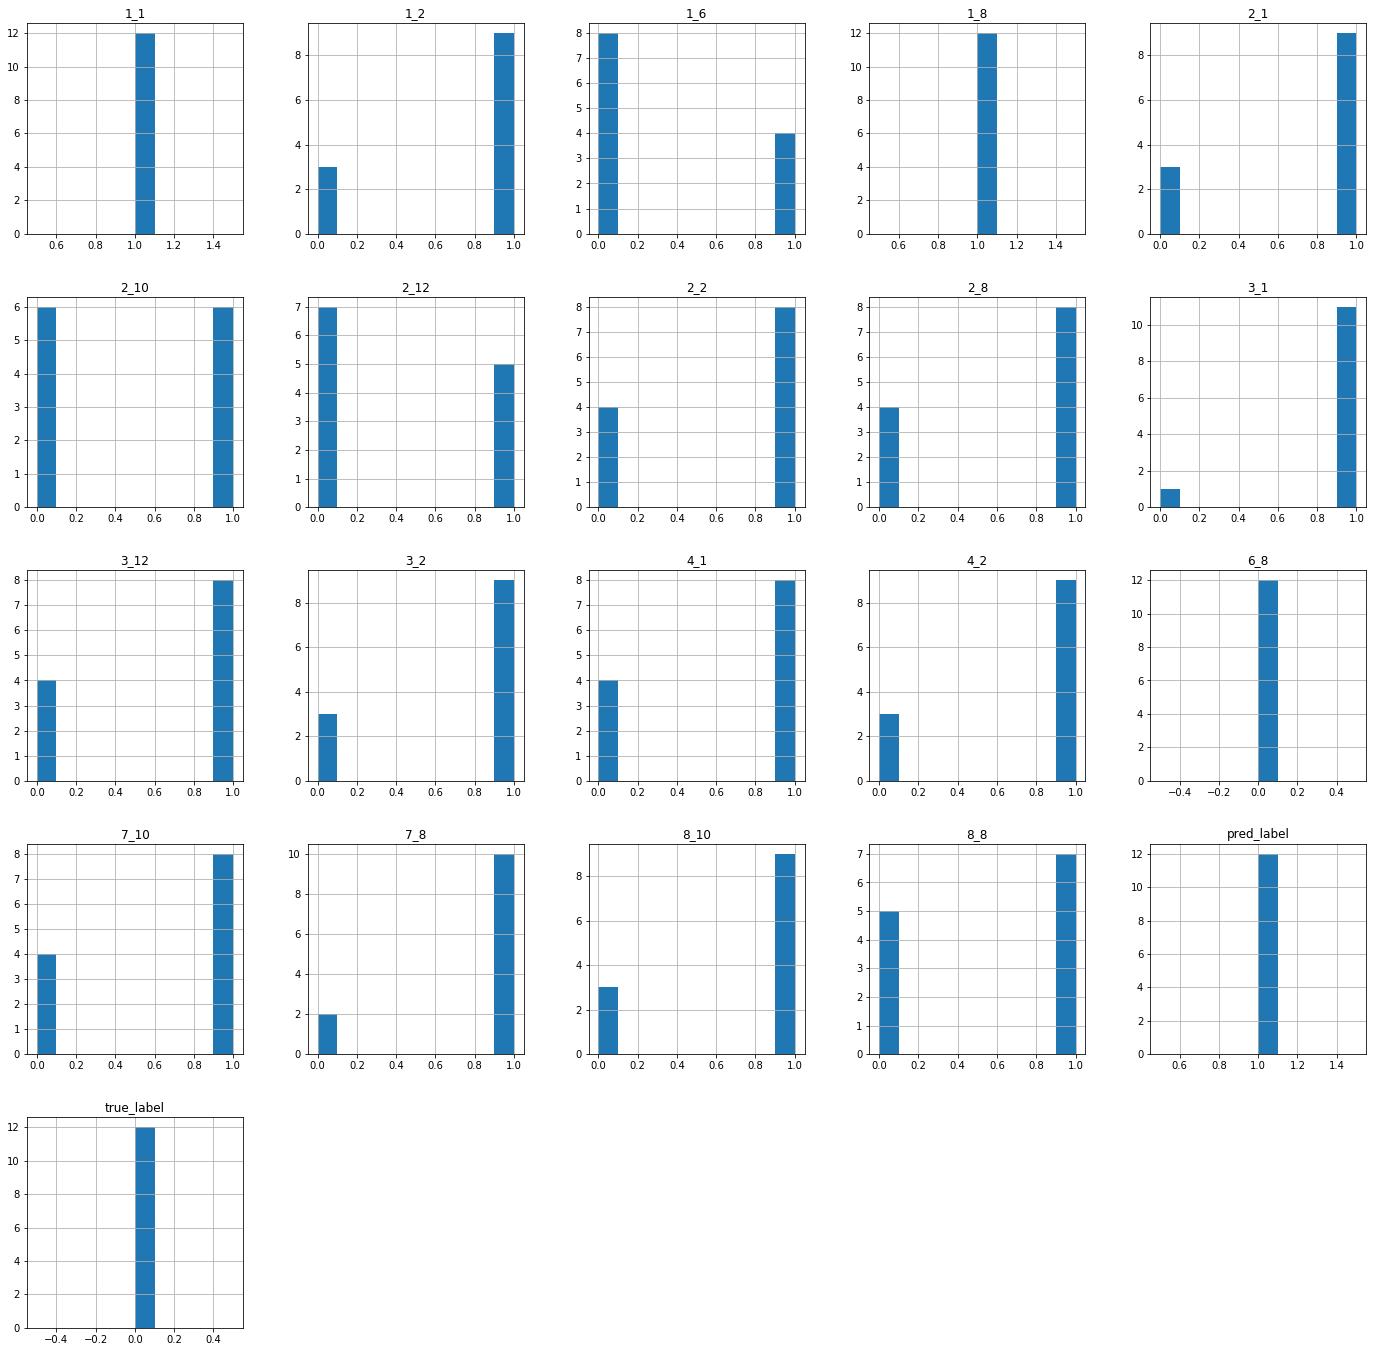

In [83]:
print_hist_models_predictions_fp(df_fp)

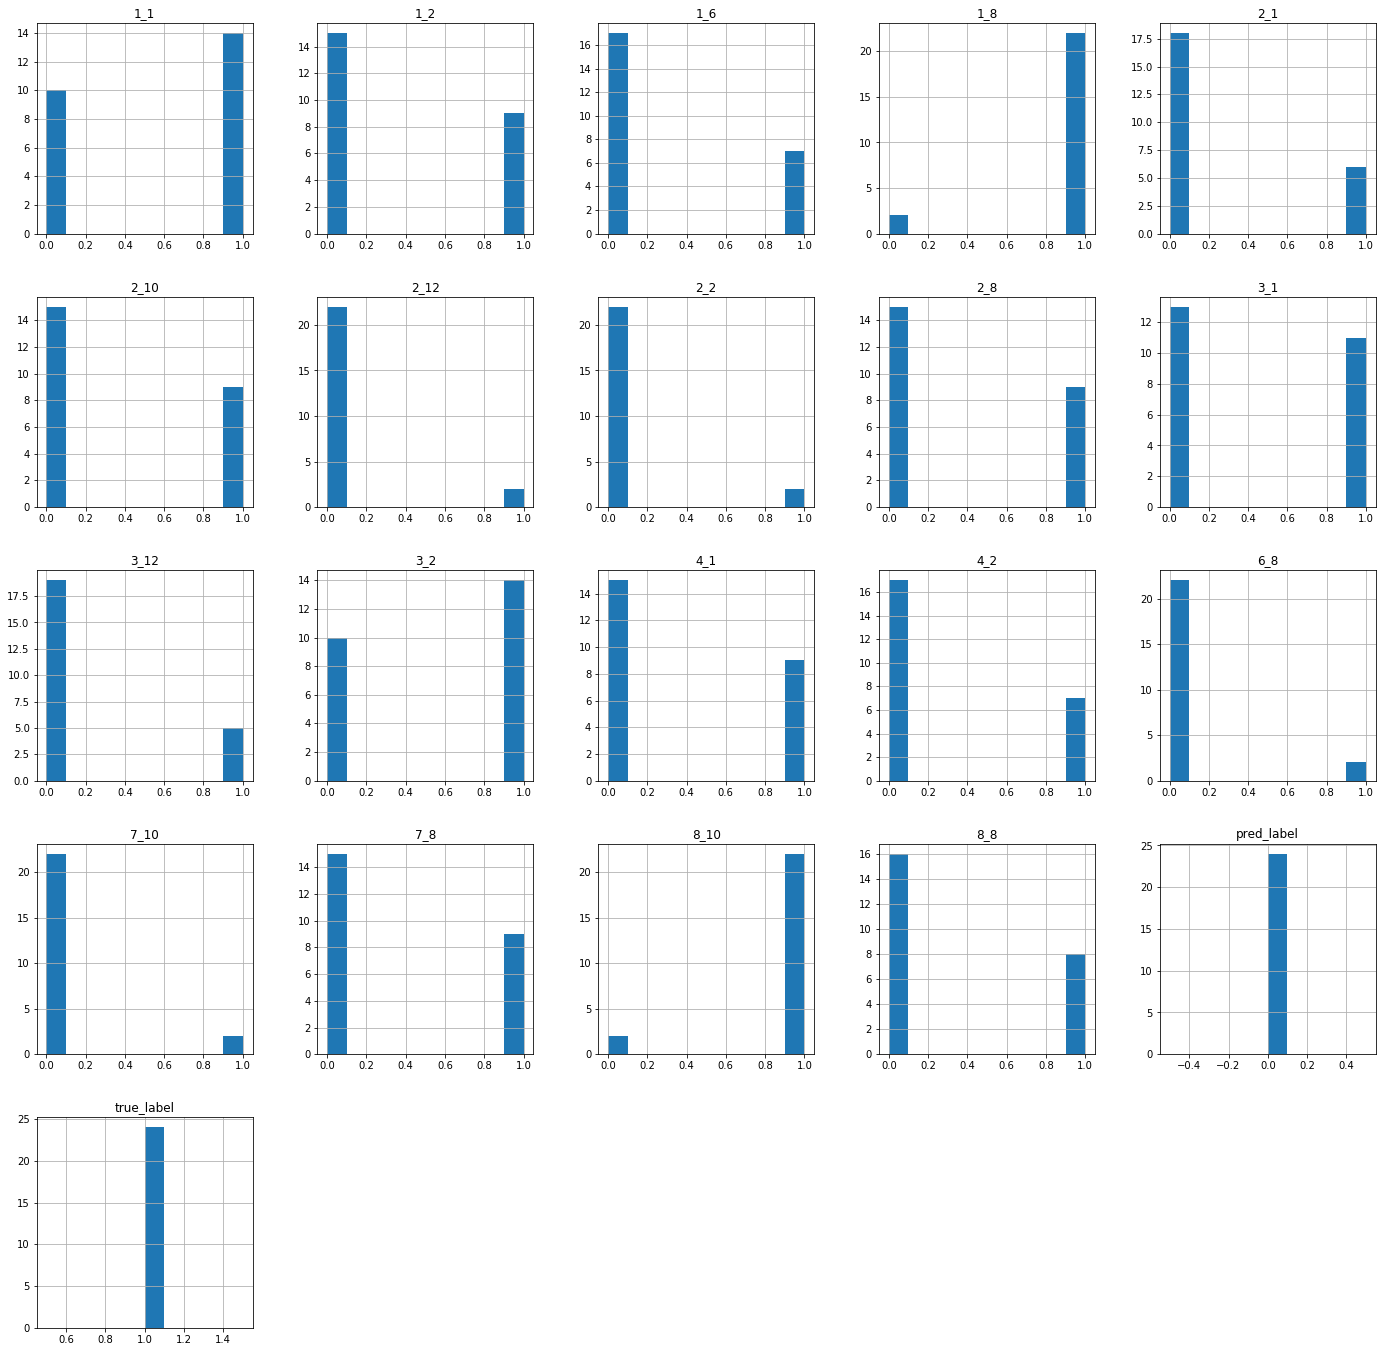

In [84]:
print_hist_models_predictions_fn(df_fn)

In [81]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       112
           1       0.90      0.81      0.85       128

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



In [82]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/majority_validation_1.csv"
df_res.to_csv(csv_path)

# Validation 2 - ALL DATASETS

We use the same code of the main.py of the real application, without VAD module

In [68]:
predictions, model_prediction_list = make_predictions(validation_dataset_2, prediction_scheme='majority')

  0%|          | 1/2000 [00:22<12:32:07, 22.58s/it]

[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]


  0%|          | 2/2000 [00:31<10:15:25, 18.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


  0%|          | 3/2000 [00:42<9:02:32, 16.30s/it] 

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


  0%|          | 4/2000 [00:54<8:13:46, 14.84s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


  0%|          | 5/2000 [01:06<7:48:14, 14.08s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


  0%|          | 6/2000 [01:15<7:02:30, 12.71s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  0%|          | 7/2000 [01:25<6:32:13, 11.81s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


  0%|          | 8/2000 [01:37<6:35:50, 11.92s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


  0%|          | 9/2000 [01:47<6:15:18, 11.31s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


  0%|          | 10/2000 [01:57<5:55:46, 10.73s/it]

[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  1%|          | 11/2000 [02:06<5:46:55, 10.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  1%|          | 12/2000 [02:15<5:31:05,  9.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


  1%|          | 13/2000 [02:25<5:26:31,  9.86s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


  1%|          | 14/2000 [02:34<5:21:54,  9.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


  1%|          | 15/2000 [02:43<5:13:26,  9.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


  1%|          | 16/2000 [02:53<5:13:53,  9.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  1%|          | 17/2000 [03:02<5:08:57,  9.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


  1%|          | 18/2000 [03:11<5:08:43,  9.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


  1%|          | 19/2000 [03:20<5:05:32,  9.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  1%|          | 20/2000 [03:29<5:02:20,  9.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


  1%|          | 21/2000 [03:38<5:03:49,  9.21s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


  1%|          | 22/2000 [03:47<5:01:21,  9.14s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  1%|          | 23/2000 [04:07<6:48:21, 12.39s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  1%|          | 24/2000 [04:21<6:57:23, 12.67s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  1%|▏         | 25/2000 [04:32<6:46:16, 12.34s/it]

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


  1%|▏         | 26/2000 [04:42<6:22:44, 11.63s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


  1%|▏         | 27/2000 [04:51<5:55:04, 10.80s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  1%|▏         | 28/2000 [05:00<5:39:33, 10.33s/it]

[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]


  1%|▏         | 29/2000 [05:10<5:31:48, 10.10s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


  2%|▏         | 30/2000 [05:19<5:24:15,  9.88s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]


  2%|▏         | 31/2000 [05:34<6:07:52, 11.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


  2%|▏         | 32/2000 [05:43<5:45:44, 10.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


  2%|▏         | 33/2000 [05:52<5:33:04, 10.16s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


  2%|▏         | 34/2000 [06:01<5:19:29,  9.75s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  2%|▏         | 35/2000 [06:10<5:19:06,  9.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  2%|▏         | 36/2000 [06:29<6:49:54, 12.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  2%|▏         | 37/2000 [06:40<6:34:14, 12.05s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]


  2%|▏         | 38/2000 [06:55<6:59:09, 12.82s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]


  2%|▏         | 39/2000 [07:08<7:06:11, 13.04s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


  2%|▏         | 40/2000 [07:20<6:48:44, 12.51s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  2%|▏         | 41/2000 [07:29<6:18:55, 11.61s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]


  2%|▏         | 42/2000 [07:41<6:21:35, 11.69s/it]

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]


  2%|▏         | 43/2000 [07:52<6:12:41, 11.43s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


  2%|▏         | 44/2000 [08:02<6:02:04, 11.11s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  2%|▏         | 45/2000 [08:11<5:41:06, 10.47s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


  2%|▏         | 46/2000 [08:20<5:25:00,  9.98s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]


  2%|▏         | 47/2000 [08:29<5:13:33,  9.63s/it]

[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]


  2%|▏         | 48/2000 [08:38<5:04:51,  9.37s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  2%|▏         | 49/2000 [08:47<5:02:59,  9.32s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]


  2%|▎         | 50/2000 [08:55<4:54:31,  9.06s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


  3%|▎         | 51/2000 [09:05<4:57:57,  9.17s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  3%|▎         | 52/2000 [09:14<5:01:23,  9.28s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


  3%|▎         | 53/2000 [09:23<4:53:09,  9.03s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  3%|▎         | 54/2000 [09:32<4:54:43,  9.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


  3%|▎         | 55/2000 [09:41<4:51:24,  8.99s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  3%|▎         | 56/2000 [09:50<4:49:11,  8.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


  3%|▎         | 57/2000 [09:58<4:48:35,  8.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  3%|▎         | 58/2000 [10:07<4:46:14,  8.84s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


  3%|▎         | 59/2000 [10:17<4:56:36,  9.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  3%|▎         | 60/2000 [10:27<5:00:29,  9.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  3%|▎         | 61/2000 [10:35<4:54:37,  9.12s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


  3%|▎         | 62/2000 [10:45<4:56:18,  9.17s/it]

[1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  3%|▎         | 63/2000 [10:53<4:51:53,  9.04s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


  3%|▎         | 64/2000 [11:02<4:49:46,  8.98s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


  3%|▎         | 65/2000 [11:11<4:46:05,  8.87s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


  3%|▎         | 66/2000 [11:21<4:57:35,  9.23s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


  3%|▎         | 67/2000 [11:31<5:06:43,  9.52s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  3%|▎         | 68/2000 [11:40<5:00:47,  9.34s/it]

[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


  3%|▎         | 69/2000 [11:49<5:01:42,  9.37s/it]

[0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]


  4%|▎         | 70/2000 [11:58<4:56:20,  9.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


  4%|▎         | 71/2000 [12:10<5:16:35,  9.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


  4%|▎         | 72/2000 [12:19<5:12:45,  9.73s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]


  4%|▎         | 73/2000 [12:28<5:05:23,  9.51s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


  4%|▎         | 74/2000 [12:38<5:09:30,  9.64s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  4%|▍         | 75/2000 [12:47<4:58:45,  9.31s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]


  4%|▍         | 76/2000 [12:56<4:56:17,  9.24s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


  4%|▍         | 77/2000 [13:04<4:46:35,  8.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


  4%|▍         | 78/2000 [13:13<4:49:32,  9.04s/it]

[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


  4%|▍         | 79/2000 [13:22<4:48:57,  9.03s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]


  4%|▍         | 80/2000 [13:30<4:41:58,  8.81s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


  4%|▍         | 81/2000 [13:40<4:44:11,  8.89s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  4%|▍         | 82/2000 [13:48<4:41:26,  8.80s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]


  4%|▍         | 83/2000 [13:57<4:44:56,  8.92s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


  4%|▍         | 84/2000 [14:07<4:48:43,  9.04s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


  4%|▍         | 85/2000 [14:15<4:45:22,  8.94s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  4%|▍         | 86/2000 [14:25<4:49:29,  9.07s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


  4%|▍         | 87/2000 [14:33<4:42:53,  8.87s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]


  4%|▍         | 88/2000 [14:42<4:41:10,  8.82s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  4%|▍         | 89/2000 [14:51<4:43:50,  8.91s/it]

[1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]


  4%|▍         | 90/2000 [14:59<4:39:58,  8.79s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


  5%|▍         | 91/2000 [15:08<4:39:27,  8.78s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]


  5%|▍         | 92/2000 [15:17<4:42:44,  8.89s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]


  5%|▍         | 93/2000 [15:27<4:48:03,  9.06s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


  5%|▍         | 94/2000 [15:35<4:41:27,  8.86s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


  5%|▍         | 95/2000 [15:44<4:39:39,  8.81s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  5%|▍         | 96/2000 [15:53<4:42:44,  8.91s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


  5%|▍         | 97/2000 [16:01<4:36:22,  8.71s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


  5%|▍         | 98/2000 [16:10<4:35:02,  8.68s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


  5%|▍         | 99/2000 [16:19<4:37:43,  8.77s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]


  5%|▌         | 100/2000 [16:28<4:36:07,  8.72s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


  5%|▌         | 101/2000 [16:36<4:36:13,  8.73s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


  5%|▌         | 102/2000 [16:49<5:10:31,  9.82s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  5%|▌         | 103/2000 [16:59<5:14:34,  9.95s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  5%|▌         | 104/2000 [17:07<5:01:44,  9.55s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


  5%|▌         | 105/2000 [17:18<5:09:48,  9.81s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


  5%|▌         | 106/2000 [17:31<5:45:25, 10.94s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  5%|▌         | 107/2000 [17:40<5:21:48, 10.20s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


  5%|▌         | 108/2000 [17:53<5:44:28, 10.92s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]


  5%|▌         | 109/2000 [18:02<5:28:32, 10.42s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


  6%|▌         | 110/2000 [18:14<5:47:31, 11.03s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


  6%|▌         | 111/2000 [18:27<6:03:27, 11.54s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


  6%|▌         | 112/2000 [18:36<5:40:51, 10.83s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


  6%|▌         | 113/2000 [18:45<5:17:08, 10.08s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


  6%|▌         | 114/2000 [18:53<5:02:05,  9.61s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


  6%|▌         | 115/2000 [19:02<4:54:21,  9.37s/it]

[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]


  6%|▌         | 116/2000 [19:11<4:51:42,  9.29s/it]

[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]


  6%|▌         | 117/2000 [19:20<4:47:46,  9.17s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


  6%|▌         | 118/2000 [19:28<4:40:05,  8.93s/it]

[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


  6%|▌         | 119/2000 [19:37<4:35:01,  8.77s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


  6%|▌         | 120/2000 [19:45<4:31:53,  8.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


  6%|▌         | 121/2000 [19:53<4:28:52,  8.59s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  6%|▌         | 122/2000 [20:02<4:32:07,  8.69s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


  6%|▌         | 123/2000 [20:10<4:25:59,  8.50s/it]

[1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  6%|▌         | 124/2000 [20:19<4:30:29,  8.65s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


  6%|▋         | 125/2000 [20:28<4:32:11,  8.71s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  6%|▋         | 126/2000 [20:36<4:25:52,  8.51s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  6%|▋         | 127/2000 [20:45<4:28:27,  8.60s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]


  6%|▋         | 128/2000 [20:53<4:25:34,  8.51s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  6%|▋         | 129/2000 [21:01<4:20:51,  8.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  6%|▋         | 130/2000 [21:10<4:23:46,  8.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  7%|▋         | 131/2000 [21:18<4:22:26,  8.42s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  7%|▋         | 132/2000 [21:27<4:22:22,  8.43s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


  7%|▋         | 133/2000 [21:35<4:21:54,  8.42s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  7%|▋         | 134/2000 [21:44<4:20:34,  8.38s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


  7%|▋         | 135/2000 [21:52<4:24:26,  8.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  7%|▋         | 136/2000 [22:00<4:20:06,  8.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


  7%|▋         | 137/2000 [22:09<4:18:40,  8.33s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  7%|▋         | 138/2000 [22:17<4:22:05,  8.45s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


  7%|▋         | 139/2000 [22:25<4:17:13,  8.29s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  7%|▋         | 140/2000 [22:34<4:20:59,  8.42s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  7%|▋         | 141/2000 [22:44<4:38:48,  9.00s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  7%|▋         | 142/2000 [22:53<4:34:24,  8.86s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  7%|▋         | 143/2000 [23:01<4:31:12,  8.76s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  7%|▋         | 144/2000 [23:10<4:31:41,  8.78s/it]

[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]


  7%|▋         | 145/2000 [23:20<4:39:41,  9.05s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  7%|▋         | 146/2000 [23:29<4:36:33,  8.95s/it]

[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]


  7%|▋         | 147/2000 [23:37<4:33:07,  8.84s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


  7%|▋         | 148/2000 [23:46<4:35:26,  8.92s/it]

[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  7%|▋         | 149/2000 [23:55<4:28:05,  8.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  8%|▊         | 150/2000 [24:04<4:34:39,  8.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  8%|▊         | 151/2000 [24:13<4:32:19,  8.84s/it]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  8%|▊         | 152/2000 [24:22<4:35:17,  8.94s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]


  8%|▊         | 153/2000 [24:31<4:34:50,  8.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


  8%|▊         | 154/2000 [24:39<4:29:52,  8.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


  8%|▊         | 155/2000 [24:48<4:31:17,  8.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  8%|▊         | 156/2000 [24:56<4:26:08,  8.66s/it]

[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 157/2000 [25:05<4:23:21,  8.57s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  8%|▊         | 158/2000 [25:15<4:34:13,  8.93s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  8%|▊         | 159/2000 [25:23<4:28:44,  8.76s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


  8%|▊         | 160/2000 [25:33<4:45:56,  9.32s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


  8%|▊         | 161/2000 [25:43<4:48:53,  9.43s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 162/2000 [25:52<4:47:01,  9.37s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 163/2000 [26:02<4:52:41,  9.56s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 164/2000 [26:12<4:54:20,  9.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


  8%|▊         | 165/2000 [26:22<4:51:39,  9.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  8%|▊         | 166/2000 [26:32<4:56:15,  9.69s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 167/2000 [26:42<5:05:38, 10.00s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 168/2000 [26:51<4:51:11,  9.54s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


  8%|▊         | 169/2000 [27:01<5:00:07,  9.83s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  8%|▊         | 170/2000 [27:12<5:05:42, 10.02s/it]

[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


  9%|▊         | 171/2000 [27:20<4:50:10,  9.52s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


  9%|▊         | 172/2000 [27:31<5:06:54, 10.07s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


  9%|▊         | 173/2000 [27:40<4:57:05,  9.76s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]


  9%|▊         | 174/2000 [27:49<4:49:17,  9.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  9%|▉         | 175/2000 [27:58<4:45:29,  9.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  9%|▉         | 176/2000 [28:08<4:45:27,  9.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


  9%|▉         | 177/2000 [28:16<4:33:52,  9.01s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  9%|▉         | 178/2000 [28:27<4:49:07,  9.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


  9%|▉         | 179/2000 [28:37<4:57:00,  9.79s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  9%|▉         | 180/2000 [28:46<4:47:50,  9.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


  9%|▉         | 181/2000 [28:55<4:39:38,  9.22s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


  9%|▉         | 182/2000 [29:04<4:44:53,  9.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


  9%|▉         | 183/2000 [29:13<4:38:13,  9.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


  9%|▉         | 184/2000 [29:22<4:37:26,  9.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  9%|▉         | 185/2000 [29:32<4:39:39,  9.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]


  9%|▉         | 186/2000 [29:43<4:56:04,  9.79s/it]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


  9%|▉         | 187/2000 [29:51<4:46:44,  9.49s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


  9%|▉         | 188/2000 [30:02<4:52:05,  9.67s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


  9%|▉         | 189/2000 [30:11<4:53:27,  9.72s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]


 10%|▉         | 190/2000 [30:22<5:05:01, 10.11s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]


 10%|▉         | 191/2000 [30:31<4:54:36,  9.77s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 10%|▉         | 192/2000 [30:41<4:51:49,  9.68s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 10%|▉         | 193/2000 [30:53<5:12:09, 10.36s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 10%|▉         | 194/2000 [31:02<4:59:45,  9.96s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 10%|▉         | 195/2000 [31:13<5:07:02, 10.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


 10%|▉         | 196/2000 [31:23<5:04:33, 10.13s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 10%|▉         | 197/2000 [31:33<5:07:23, 10.23s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 10%|▉         | 198/2000 [31:44<5:17:40, 10.58s/it]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]


 10%|▉         | 199/2000 [31:54<5:12:15, 10.40s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 10%|█         | 200/2000 [32:04<5:07:29, 10.25s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 10%|█         | 201/2000 [32:15<5:07:22, 10.25s/it]

[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]


 10%|█         | 202/2000 [32:23<4:51:41,  9.73s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 10%|█         | 203/2000 [32:33<4:51:34,  9.74s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 10%|█         | 204/2000 [32:43<4:51:19,  9.73s/it]

[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]


 10%|█         | 205/2000 [32:51<4:43:47,  9.49s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 10%|█         | 206/2000 [33:01<4:46:25,  9.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 10%|█         | 207/2000 [33:10<4:42:07,  9.44s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


 10%|█         | 208/2000 [33:20<4:39:52,  9.37s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 10%|█         | 209/2000 [33:28<4:34:28,  9.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]


 10%|█         | 210/2000 [33:37<4:25:34,  8.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


 11%|█         | 211/2000 [33:45<4:24:12,  8.86s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 11%|█         | 212/2000 [33:54<4:22:26,  8.81s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 11%|█         | 213/2000 [34:04<4:32:03,  9.13s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 11%|█         | 214/2000 [34:12<4:26:25,  8.95s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 11%|█         | 215/2000 [34:21<4:19:38,  8.73s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]


 11%|█         | 216/2000 [34:29<4:17:02,  8.64s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 11%|█         | 217/2000 [34:37<4:13:48,  8.54s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 11%|█         | 218/2000 [34:46<4:11:01,  8.45s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 11%|█         | 219/2000 [34:54<4:13:44,  8.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


 11%|█         | 220/2000 [35:02<4:09:07,  8.40s/it]

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 11%|█         | 221/2000 [35:11<4:07:32,  8.35s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]


 11%|█         | 222/2000 [35:20<4:14:42,  8.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 11%|█         | 223/2000 [35:28<4:12:25,  8.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 11%|█         | 224/2000 [35:37<4:16:21,  8.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 11%|█▏        | 225/2000 [35:46<4:13:21,  8.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 11%|█▏        | 226/2000 [35:54<4:10:41,  8.48s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


 11%|█▏        | 227/2000 [36:02<4:09:54,  8.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]


 11%|█▏        | 228/2000 [36:10<4:07:43,  8.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


 11%|█▏        | 229/2000 [36:19<4:07:20,  8.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]


 12%|█▏        | 230/2000 [36:27<4:07:47,  8.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]


 12%|█▏        | 231/2000 [36:35<4:05:12,  8.32s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 12%|█▏        | 232/2000 [36:44<4:07:36,  8.40s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 12%|█▏        | 233/2000 [36:52<4:07:01,  8.39s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


 12%|█▏        | 234/2000 [37:00<4:02:45,  8.25s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 12%|█▏        | 235/2000 [37:09<4:07:16,  8.41s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 12%|█▏        | 236/2000 [37:17<4:06:40,  8.39s/it]

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 237/2000 [37:25<4:02:16,  8.25s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 12%|█▏        | 238/2000 [37:34<4:08:19,  8.46s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 12%|█▏        | 239/2000 [37:43<4:08:36,  8.47s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 12%|█▏        | 240/2000 [37:51<4:10:25,  8.54s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 12%|█▏        | 241/2000 [38:01<4:16:41,  8.76s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 242/2000 [38:09<4:14:34,  8.69s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 243/2000 [38:18<4:14:13,  8.68s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 244/2000 [38:26<4:12:23,  8.62s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 245/2000 [38:35<4:11:12,  8.59s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]


 12%|█▏        | 246/2000 [38:43<4:05:49,  8.41s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 247/2000 [38:51<4:05:03,  8.39s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 12%|█▏        | 248/2000 [39:00<4:08:56,  8.53s/it]

[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 249/2000 [39:09<4:09:43,  8.56s/it]

[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▎        | 250/2000 [39:17<4:05:45,  8.43s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 251/2000 [39:26<4:08:58,  8.54s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 252/2000 [39:34<4:07:08,  8.48s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 253/2000 [39:43<4:10:05,  8.59s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 254/2000 [39:51<4:05:26,  8.43s/it]

[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 13%|█▎        | 255/2000 [39:59<4:02:42,  8.35s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 256/2000 [40:08<4:06:39,  8.49s/it]

[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


 13%|█▎        | 257/2000 [40:17<4:08:07,  8.54s/it]

[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 258/2000 [40:25<4:10:17,  8.62s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 259/2000 [40:33<4:05:08,  8.45s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 13%|█▎        | 260/2000 [40:42<4:04:08,  8.42s/it]

[1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


 13%|█▎        | 261/2000 [40:50<4:06:28,  8.50s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 13%|█▎        | 262/2000 [41:00<4:14:37,  8.79s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]


 13%|█▎        | 263/2000 [41:13<4:48:59,  9.98s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 264/2000 [41:27<5:27:55, 11.33s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 13%|█▎        | 265/2000 [41:37<5:14:43, 10.88s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 266/2000 [41:45<4:52:44, 10.13s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 267/2000 [41:54<4:41:31,  9.75s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 268/2000 [42:02<4:28:28,  9.30s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 269/2000 [42:11<4:21:45,  9.07s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


 14%|█▎        | 270/2000 [42:20<4:17:00,  8.91s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▎        | 271/2000 [42:28<4:14:40,  8.84s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


 14%|█▎        | 272/2000 [42:37<4:11:23,  8.73s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 14%|█▎        | 273/2000 [42:45<4:06:59,  8.58s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


 14%|█▎        | 274/2000 [42:53<4:05:24,  8.53s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 275/2000 [43:02<4:08:17,  8.64s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 276/2000 [43:11<4:07:29,  8.61s/it]

[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 277/2000 [43:19<4:02:39,  8.45s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 278/2000 [43:31<4:34:01,  9.55s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 279/2000 [43:40<4:29:49,  9.41s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


 14%|█▍        | 280/2000 [43:50<4:31:34,  9.47s/it]

[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 14%|█▍        | 281/2000 [43:58<4:19:57,  9.07s/it]

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 282/2000 [44:07<4:22:43,  9.18s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


 14%|█▍        | 283/2000 [44:17<4:24:56,  9.26s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


 14%|█▍        | 284/2000 [44:26<4:24:27,  9.25s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


 14%|█▍        | 285/2000 [44:35<4:23:14,  9.21s/it]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 286/2000 [44:43<4:16:15,  8.97s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


 14%|█▍        | 287/2000 [44:54<4:29:42,  9.45s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 288/2000 [45:03<4:22:03,  9.18s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 289/2000 [45:11<4:18:57,  9.08s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 290/2000 [45:21<4:21:42,  9.18s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 291/2000 [45:29<4:13:07,  8.89s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 292/2000 [45:38<4:11:26,  8.83s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 15%|█▍        | 293/2000 [45:46<4:09:43,  8.78s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 294/2000 [45:55<4:08:51,  8.75s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 295/2000 [46:04<4:08:11,  8.73s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 296/2000 [46:12<4:06:14,  8.67s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 297/2000 [46:20<4:00:56,  8.49s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 298/2000 [46:29<4:04:42,  8.63s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 299/2000 [46:37<3:59:32,  8.45s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


 15%|█▌        | 300/2000 [46:45<3:57:14,  8.37s/it]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 301/2000 [46:54<4:02:02,  8.55s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 302/2000 [47:03<3:58:43,  8.44s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 303/2000 [47:12<4:02:26,  8.57s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 304/2000 [47:20<3:57:51,  8.41s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 305/2000 [47:28<3:59:45,  8.49s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 306/2000 [47:37<4:00:12,  8.51s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 307/2000 [47:45<4:01:16,  8.55s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 308/2000 [47:54<3:57:27,  8.42s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 309/2000 [48:02<3:58:32,  8.46s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 310/2000 [48:11<3:58:56,  8.48s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 311/2000 [48:19<4:01:03,  8.56s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 312/2000 [48:28<3:59:16,  8.51s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 313/2000 [48:36<3:55:48,  8.39s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 16%|█▌        | 314/2000 [48:45<4:00:23,  8.56s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 315/2000 [48:53<3:56:07,  8.41s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 16%|█▌        | 316/2000 [49:02<4:03:46,  8.69s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 16%|█▌        | 317/2000 [49:10<3:59:33,  8.54s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 318/2000 [49:19<3:56:04,  8.42s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]


 16%|█▌        | 319/2000 [49:28<4:04:03,  8.71s/it]

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 16%|█▌        | 320/2000 [49:38<4:17:25,  9.19s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 321/2000 [49:50<4:41:38, 10.06s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


 16%|█▌        | 322/2000 [50:00<4:34:59,  9.83s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 323/2000 [50:12<4:54:19, 10.53s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 324/2000 [50:23<4:59:00, 10.70s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 16%|█▋        | 325/2000 [50:32<4:44:16, 10.18s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


 16%|█▋        | 326/2000 [50:40<4:30:05,  9.68s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▋        | 327/2000 [50:49<4:18:25,  9.27s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▋        | 328/2000 [50:58<4:14:40,  9.14s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 16%|█▋        | 329/2000 [51:06<4:09:14,  8.95s/it]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 16%|█▋        | 330/2000 [51:14<4:04:51,  8.80s/it]

[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]


 17%|█▋        | 331/2000 [51:23<4:02:26,  8.72s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 332/2000 [51:32<4:00:38,  8.66s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 333/2000 [51:40<3:59:59,  8.64s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 334/2000 [51:49<4:00:55,  8.68s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 335/2000 [51:57<3:55:45,  8.50s/it]

[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 336/2000 [52:06<3:56:07,  8.51s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 337/2000 [52:14<3:55:12,  8.49s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 338/2000 [52:22<3:52:43,  8.40s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 339/2000 [52:31<3:57:08,  8.57s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 340/2000 [52:39<3:53:42,  8.45s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 341/2000 [52:49<4:00:30,  8.70s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 342/2000 [52:57<3:56:06,  8.54s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 343/2000 [53:05<3:54:58,  8.51s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


 17%|█▋        | 344/2000 [53:14<3:55:49,  8.54s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 345/2000 [53:22<3:52:18,  8.42s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 346/2000 [53:31<3:58:14,  8.64s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 17%|█▋        | 347/2000 [53:39<3:53:47,  8.49s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 348/2000 [53:48<3:55:39,  8.56s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


 17%|█▋        | 349/2000 [53:57<3:55:53,  8.57s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 350/2000 [54:06<4:03:02,  8.84s/it]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 351/2000 [54:15<4:01:47,  8.80s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 352/2000 [54:23<3:59:15,  8.71s/it]

[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 353/2000 [54:31<3:54:01,  8.53s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 354/2000 [54:40<3:54:51,  8.56s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 355/2000 [54:48<3:54:02,  8.54s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 356/2000 [54:57<3:50:04,  8.40s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 357/2000 [55:05<3:53:37,  8.53s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 358/2000 [55:14<3:58:04,  8.70s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 18%|█▊        | 359/2000 [55:23<4:00:19,  8.79s/it]

[1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 360/2000 [55:32<3:54:42,  8.59s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 361/2000 [55:40<3:54:18,  8.58s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 362/2000 [55:49<4:00:21,  8.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]


 18%|█▊        | 363/2000 [55:58<3:54:51,  8.61s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 364/2000 [56:06<3:53:09,  8.55s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 365/2000 [56:15<3:53:11,  8.56s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 366/2000 [56:23<3:51:27,  8.50s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


 18%|█▊        | 367/2000 [56:32<3:52:06,  8.53s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 18%|█▊        | 368/2000 [56:40<3:50:59,  8.49s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]


 18%|█▊        | 369/2000 [56:48<3:48:08,  8.39s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 18%|█▊        | 370/2000 [56:57<3:51:17,  8.51s/it]

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 19%|█▊        | 371/2000 [57:05<3:48:25,  8.41s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


 19%|█▊        | 372/2000 [57:13<3:47:01,  8.37s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 19%|█▊        | 373/2000 [57:22<3:51:28,  8.54s/it]

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 19%|█▊        | 374/2000 [57:31<3:50:49,  8.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 19%|█▉        | 375/2000 [57:40<3:52:51,  8.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]


 19%|█▉        | 376/2000 [57:48<3:51:18,  8.55s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]


 19%|█▉        | 377/2000 [57:56<3:51:03,  8.54s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]


 19%|█▉        | 378/2000 [58:05<3:51:07,  8.55s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


 19%|█▉        | 379/2000 [58:14<3:50:27,  8.53s/it]

[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 19%|█▉        | 380/2000 [58:22<3:49:36,  8.50s/it]

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


 19%|█▉        | 381/2000 [58:30<3:45:56,  8.37s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 382/2000 [58:39<3:49:39,  8.52s/it]

[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


 19%|█▉        | 383/2000 [58:49<4:01:09,  8.95s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 384/2000 [59:01<4:29:51, 10.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 19%|█▉        | 385/2000 [59:11<4:23:29,  9.79s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 386/2000 [59:20<4:16:05,  9.52s/it]

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 387/2000 [59:30<4:23:18,  9.79s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 388/2000 [59:40<4:22:02,  9.75s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 389/2000 [59:50<4:24:16,  9.84s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 390/2000 [59:59<4:21:56,  9.76s/it]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]


 20%|█▉        | 391/2000 [1:00:09<4:18:11,  9.63s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 20%|█▉        | 392/2000 [1:00:18<4:16:36,  9.57s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 393/2000 [1:00:28<4:21:31,  9.76s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 394/2000 [1:00:38<4:24:49,  9.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 20%|█▉        | 395/2000 [1:00:48<4:22:45,  9.82s/it]

[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 396/2000 [1:00:57<4:15:12,  9.55s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 397/2000 [1:01:05<4:06:21,  9.22s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 20%|█▉        | 398/2000 [1:01:14<4:00:48,  9.02s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 399/2000 [1:01:22<3:54:53,  8.80s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|██        | 400/2000 [1:01:31<3:56:19,  8.86s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]


 20%|██        | 401/2000 [1:01:45<4:31:19, 10.18s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 20%|██        | 402/2000 [1:01:55<4:33:08, 10.26s/it]

[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 20%|██        | 403/2000 [1:02:04<4:22:09,  9.85s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|██        | 404/2000 [1:02:12<4:12:17,  9.48s/it]

[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|██        | 405/2000 [1:02:21<4:05:51,  9.25s/it]

[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|██        | 406/2000 [1:02:30<4:00:25,  9.05s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


 20%|██        | 407/2000 [1:02:40<4:07:12,  9.31s/it]

[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 20%|██        | 408/2000 [1:02:49<4:04:30,  9.22s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 20%|██        | 409/2000 [1:02:57<3:58:45,  9.00s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 20%|██        | 410/2000 [1:03:06<3:54:15,  8.84s/it]

[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 21%|██        | 411/2000 [1:03:14<3:51:10,  8.73s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 21%|██        | 412/2000 [1:03:22<3:46:04,  8.54s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


 21%|██        | 413/2000 [1:03:31<3:48:40,  8.65s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██        | 414/2000 [1:03:39<3:44:33,  8.50s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 21%|██        | 415/2000 [1:03:49<3:51:45,  8.77s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██        | 416/2000 [1:03:57<3:48:47,  8.67s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 21%|██        | 417/2000 [1:04:06<3:50:20,  8.73s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]


 21%|██        | 418/2000 [1:04:15<3:54:50,  8.91s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██        | 419/2000 [1:04:23<3:48:38,  8.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]


 21%|██        | 420/2000 [1:04:32<3:50:51,  8.77s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]


 21%|██        | 421/2000 [1:04:41<3:46:05,  8.59s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 21%|██        | 422/2000 [1:04:49<3:45:12,  8.56s/it]

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 21%|██        | 423/2000 [1:04:58<3:44:52,  8.56s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 21%|██        | 424/2000 [1:05:06<3:44:13,  8.54s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██▏       | 425/2000 [1:05:16<3:51:50,  8.83s/it]

[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 21%|██▏       | 426/2000 [1:05:25<3:52:58,  8.88s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 21%|██▏       | 427/2000 [1:05:34<3:58:28,  9.10s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 21%|██▏       | 428/2000 [1:05:42<3:50:37,  8.80s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██▏       | 429/2000 [1:05:51<3:47:57,  8.71s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 22%|██▏       | 430/2000 [1:06:00<3:49:04,  8.75s/it]

[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 431/2000 [1:06:08<3:46:58,  8.68s/it]

[1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 432/2000 [1:06:17<3:46:01,  8.65s/it]

[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 22%|██▏       | 433/2000 [1:06:25<3:45:05,  8.62s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]


 22%|██▏       | 434/2000 [1:06:33<3:40:29,  8.45s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 435/2000 [1:06:42<3:41:10,  8.48s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 436/2000 [1:06:50<3:41:24,  8.49s/it]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 437/2000 [1:06:59<3:38:34,  8.39s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 438/2000 [1:07:07<3:42:11,  8.53s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 439/2000 [1:07:16<3:38:39,  8.40s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 22%|██▏       | 440/2000 [1:07:25<3:42:33,  8.56s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 441/2000 [1:07:33<3:38:59,  8.43s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 442/2000 [1:07:41<3:39:04,  8.44s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 22%|██▏       | 443/2000 [1:07:50<3:43:36,  8.62s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 22%|██▏       | 444/2000 [1:08:03<4:19:34, 10.01s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 445/2000 [1:08:18<4:51:37, 11.25s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]


 22%|██▏       | 446/2000 [1:08:28<4:48:46, 11.15s/it]

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 447/2000 [1:08:37<4:31:34, 10.49s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 22%|██▏       | 448/2000 [1:08:46<4:19:04, 10.02s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 449/2000 [1:08:56<4:12:33,  9.77s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]


 22%|██▎       | 450/2000 [1:09:05<4:08:15,  9.61s/it]

[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 451/2000 [1:09:14<4:07:05,  9.57s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 452/2000 [1:09:23<3:57:41,  9.21s/it]

[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 23%|██▎       | 453/2000 [1:09:31<3:51:49,  8.99s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 454/2000 [1:09:41<3:58:08,  9.24s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 23%|██▎       | 455/2000 [1:09:51<4:06:32,  9.57s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 456/2000 [1:10:01<4:05:17,  9.53s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


 23%|██▎       | 457/2000 [1:10:13<4:23:41, 10.25s/it]

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 458/2000 [1:10:25<4:43:34, 11.03s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 23%|██▎       | 459/2000 [1:10:36<4:41:21, 10.95s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 460/2000 [1:10:50<5:01:23, 11.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 23%|██▎       | 461/2000 [1:11:12<6:23:49, 14.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 23%|██▎       | 462/2000 [1:11:24<5:55:38, 13.87s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


 23%|██▎       | 463/2000 [1:11:35<5:35:48, 13.11s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 23%|██▎       | 464/2000 [1:11:45<5:13:01, 12.23s/it]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 465/2000 [1:12:02<5:47:17, 13.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 466/2000 [1:12:19<6:17:10, 14.75s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 467/2000 [1:12:34<6:16:33, 14.74s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 468/2000 [1:12:54<6:58:45, 16.40s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 469/2000 [1:13:12<7:05:05, 16.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 24%|██▎       | 470/2000 [1:13:25<6:42:54, 15.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 24%|██▎       | 471/2000 [1:13:41<6:40:53, 15.73s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


 24%|██▎       | 472/2000 [1:13:57<6:46:32, 15.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 24%|██▎       | 473/2000 [1:14:17<7:16:59, 17.17s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 24%|██▎       | 474/2000 [1:14:28<6:23:19, 15.07s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 24%|██▍       | 475/2000 [1:14:43<6:22:50, 15.06s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 24%|██▍       | 476/2000 [1:15:00<6:42:12, 15.84s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 24%|██▍       | 477/2000 [1:15:13<6:14:15, 14.74s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1]


 24%|██▍       | 478/2000 [1:15:28<6:15:59, 14.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 24%|██▍       | 479/2000 [1:15:42<6:13:13, 14.72s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 24%|██▍       | 480/2000 [1:15:54<5:55:45, 14.04s/it]

[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 24%|██▍       | 481/2000 [1:16:06<5:39:01, 13.39s/it]

[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 482/2000 [1:16:19<5:36:02, 13.28s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 24%|██▍       | 483/2000 [1:16:32<5:31:44, 13.12s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 484/2000 [1:16:46<5:39:22, 13.43s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 485/2000 [1:16:59<5:33:28, 13.21s/it]

[1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 486/2000 [1:17:12<5:32:36, 13.18s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 487/2000 [1:17:25<5:28:46, 13.04s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 488/2000 [1:17:38<5:28:30, 13.04s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 489/2000 [1:17:55<5:56:48, 14.17s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 24%|██▍       | 490/2000 [1:18:07<5:42:59, 13.63s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 491/2000 [1:18:22<5:55:54, 14.15s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]


 25%|██▍       | 492/2000 [1:18:36<5:54:25, 14.10s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 493/2000 [1:18:47<5:26:35, 13.00s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 494/2000 [1:19:01<5:34:35, 13.33s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 495/2000 [1:19:15<5:41:42, 13.62s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 496/2000 [1:19:33<6:10:43, 14.79s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 497/2000 [1:19:49<6:21:05, 15.21s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 498/2000 [1:20:03<6:13:39, 14.93s/it]

[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 25%|██▍       | 499/2000 [1:20:22<6:46:25, 16.25s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 25%|██▌       | 500/2000 [1:20:34<6:13:48, 14.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 501/2000 [1:20:45<5:44:18, 13.78s/it]

[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 502/2000 [1:20:58<5:33:26, 13.36s/it]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 503/2000 [1:21:09<5:18:48, 12.78s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 25%|██▌       | 504/2000 [1:21:20<5:00:54, 12.07s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 505/2000 [1:21:36<5:32:20, 13.34s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 25%|██▌       | 506/2000 [1:21:48<5:24:33, 13.03s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 507/2000 [1:21:59<5:03:43, 12.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 508/2000 [1:22:09<4:47:32, 11.56s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 25%|██▌       | 509/2000 [1:22:20<4:42:51, 11.38s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]


 26%|██▌       | 510/2000 [1:22:30<4:38:43, 11.22s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 511/2000 [1:22:49<5:31:47, 13.37s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]


 26%|██▌       | 512/2000 [1:23:09<6:23:35, 15.47s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 26%|██▌       | 513/2000 [1:23:26<6:33:07, 15.86s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


 26%|██▌       | 514/2000 [1:23:41<6:25:46, 15.58s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 515/2000 [1:23:52<5:55:35, 14.37s/it]

[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 516/2000 [1:24:02<5:18:16, 12.87s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 517/2000 [1:24:12<4:56:38, 12.00s/it]

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 518/2000 [1:24:22<4:40:10, 11.34s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 519/2000 [1:24:32<4:33:50, 11.09s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 520/2000 [1:24:45<4:43:46, 11.50s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]


 26%|██▌       | 521/2000 [1:24:57<4:53:29, 11.91s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 522/2000 [1:25:07<4:34:22, 11.14s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]


 26%|██▌       | 523/2000 [1:25:18<4:38:18, 11.31s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▌       | 524/2000 [1:25:31<4:47:46, 11.70s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▋       | 525/2000 [1:25:44<4:56:22, 12.06s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 26%|██▋       | 526/2000 [1:26:01<5:29:19, 13.41s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 26%|██▋       | 527/2000 [1:26:10<5:02:57, 12.34s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 26%|██▋       | 528/2000 [1:26:30<5:58:46, 14.62s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 26%|██▋       | 529/2000 [1:26:44<5:55:11, 14.49s/it]

[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 26%|██▋       | 530/2000 [1:27:04<6:29:26, 15.90s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 531/2000 [1:27:18<6:21:07, 15.57s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 532/2000 [1:27:33<6:14:13, 15.30s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 533/2000 [1:27:45<5:46:03, 14.15s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 534/2000 [1:27:54<5:11:45, 12.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 535/2000 [1:28:03<4:46:18, 11.73s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 536/2000 [1:28:13<4:29:08, 11.03s/it]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 537/2000 [1:28:28<4:58:13, 12.23s/it]

[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 538/2000 [1:28:40<4:57:10, 12.20s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 539/2000 [1:28:55<5:15:21, 12.95s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 540/2000 [1:29:09<5:28:31, 13.50s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 541/2000 [1:29:22<5:20:07, 13.17s/it]

[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 542/2000 [1:29:35<5:18:08, 13.09s/it]

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 543/2000 [1:29:46<5:02:31, 12.46s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 544/2000 [1:29:56<4:42:38, 11.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 545/2000 [1:30:04<4:21:07, 10.77s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 546/2000 [1:30:14<4:12:31, 10.42s/it]

[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 547/2000 [1:30:23<4:05:15, 10.13s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 27%|██▋       | 548/2000 [1:30:32<3:57:47,  9.83s/it]

[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 27%|██▋       | 549/2000 [1:30:41<3:52:14,  9.60s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 550/2000 [1:30:51<3:54:28,  9.70s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 551/2000 [1:31:01<3:49:46,  9.51s/it]

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 552/2000 [1:31:10<3:48:49,  9.48s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 553/2000 [1:31:19<3:44:52,  9.32s/it]

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 554/2000 [1:31:28<3:42:27,  9.23s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 555/2000 [1:31:37<3:40:59,  9.18s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 28%|██▊       | 556/2000 [1:31:46<3:40:07,  9.15s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 28%|██▊       | 557/2000 [1:31:55<3:38:42,  9.09s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 558/2000 [1:32:04<3:37:33,  9.05s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 559/2000 [1:32:14<3:43:46,  9.32s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 560/2000 [1:32:23<3:40:55,  9.20s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 561/2000 [1:32:33<3:45:39,  9.41s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 562/2000 [1:32:42<3:47:34,  9.50s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 563/2000 [1:32:53<3:56:43,  9.88s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 564/2000 [1:33:13<5:08:49, 12.90s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 565/2000 [1:33:27<5:13:18, 13.10s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 566/2000 [1:33:47<6:01:31, 15.13s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 28%|██▊       | 567/2000 [1:33:56<5:22:13, 13.49s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 568/2000 [1:34:07<5:05:43, 12.81s/it]

[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 569/2000 [1:34:16<4:36:08, 11.58s/it]

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 28%|██▊       | 570/2000 [1:34:26<4:20:59, 10.95s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▊       | 571/2000 [1:34:35<4:06:58, 10.37s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▊       | 572/2000 [1:34:44<3:58:00, 10.00s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▊       | 573/2000 [1:34:53<3:51:00,  9.71s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▊       | 574/2000 [1:35:02<3:46:11,  9.52s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 575/2000 [1:35:12<3:47:00,  9.56s/it]

[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 576/2000 [1:35:21<3:43:32,  9.42s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 577/2000 [1:35:30<3:43:26,  9.42s/it]

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 578/2000 [1:35:40<3:46:32,  9.56s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 579/2000 [1:35:55<4:24:20, 11.16s/it]

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 29%|██▉       | 580/2000 [1:36:05<4:15:17, 10.79s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 581/2000 [1:36:14<4:02:51, 10.27s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 582/2000 [1:36:24<4:01:16, 10.21s/it]

[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 583/2000 [1:36:35<4:09:50, 10.58s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 584/2000 [1:36:49<4:28:13, 11.37s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 585/2000 [1:37:00<4:31:26, 11.51s/it]

[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]


 29%|██▉       | 586/2000 [1:37:12<4:29:53, 11.45s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 29%|██▉       | 587/2000 [1:37:22<4:23:32, 11.19s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 29%|██▉       | 588/2000 [1:37:32<4:13:30, 10.77s/it]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 29%|██▉       | 589/2000 [1:37:43<4:17:38, 10.96s/it]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 30%|██▉       | 590/2000 [1:38:00<4:53:40, 12.50s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|██▉       | 591/2000 [1:38:17<5:28:09, 13.97s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 30%|██▉       | 592/2000 [1:38:32<5:33:09, 14.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 30%|██▉       | 593/2000 [1:38:47<5:43:53, 14.67s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 30%|██▉       | 594/2000 [1:39:02<5:40:58, 14.55s/it]

[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 30%|██▉       | 595/2000 [1:39:12<5:08:08, 13.16s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 30%|██▉       | 596/2000 [1:39:24<4:59:09, 12.78s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 30%|██▉       | 597/2000 [1:39:36<4:54:59, 12.62s/it]

[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|██▉       | 598/2000 [1:39:49<4:58:15, 12.76s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 30%|██▉       | 599/2000 [1:39:58<4:33:28, 11.71s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 30%|███       | 600/2000 [1:40:09<4:27:19, 11.46s/it]

[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 601/2000 [1:40:22<4:39:26, 11.98s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 602/2000 [1:40:36<4:50:41, 12.48s/it]

[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 30%|███       | 603/2000 [1:40:46<4:37:21, 11.91s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 604/2000 [1:40:57<4:28:28, 11.54s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 30%|███       | 605/2000 [1:41:07<4:13:40, 10.91s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 606/2000 [1:41:22<4:43:40, 12.21s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 607/2000 [1:41:33<4:33:58, 11.80s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 608/2000 [1:41:43<4:23:37, 11.36s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 30%|███       | 609/2000 [1:41:52<4:07:47, 10.69s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 30%|███       | 610/2000 [1:42:09<4:53:13, 12.66s/it]

[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 611/2000 [1:42:24<5:09:27, 13.37s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 31%|███       | 612/2000 [1:42:37<5:07:04, 13.27s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 31%|███       | 613/2000 [1:42:51<5:10:32, 13.43s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 614/2000 [1:43:03<5:00:48, 13.02s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 615/2000 [1:43:19<5:15:47, 13.68s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 616/2000 [1:43:30<5:01:38, 13.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 617/2000 [1:43:42<4:51:59, 12.67s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


 31%|███       | 618/2000 [1:43:52<4:34:42, 11.93s/it]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 31%|███       | 619/2000 [1:44:03<4:28:06, 11.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 620/2000 [1:44:18<4:48:48, 12.56s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 31%|███       | 621/2000 [1:44:31<4:52:57, 12.75s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 31%|███       | 622/2000 [1:44:48<5:21:28, 14.00s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 31%|███       | 623/2000 [1:45:02<5:20:25, 13.96s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 31%|███       | 624/2000 [1:45:19<5:43:47, 14.99s/it]

[1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 31%|███▏      | 625/2000 [1:45:35<5:47:36, 15.17s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 31%|███▏      | 626/2000 [1:45:55<6:19:29, 16.57s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 31%|███▏      | 627/2000 [1:46:13<6:29:13, 17.01s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 31%|███▏      | 628/2000 [1:46:30<6:32:01, 17.14s/it]

[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 31%|███▏      | 629/2000 [1:46:52<7:06:25, 18.66s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 630/2000 [1:47:20<8:10:10, 21.47s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 32%|███▏      | 631/2000 [1:47:37<7:40:23, 20.18s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 632/2000 [1:47:57<7:34:01, 19.91s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 633/2000 [1:48:16<7:30:40, 19.78s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 32%|███▏      | 634/2000 [1:48:37<7:37:09, 20.08s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 635/2000 [1:48:55<7:23:51, 19.51s/it]

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 636/2000 [1:49:12<7:05:59, 18.74s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 32%|███▏      | 637/2000 [1:49:30<6:57:25, 18.38s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 32%|███▏      | 638/2000 [1:49:48<6:58:40, 18.44s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 639/2000 [1:50:08<7:10:33, 18.98s/it]

[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 640/2000 [1:50:29<7:23:39, 19.57s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 641/2000 [1:50:50<7:29:44, 19.86s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]


 32%|███▏      | 642/2000 [1:51:27<9:23:52, 24.91s/it]

[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 643/2000 [1:51:48<9:00:36, 23.90s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


 32%|███▏      | 644/2000 [1:52:09<8:37:11, 22.88s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 645/2000 [1:52:24<7:43:07, 20.51s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 646/2000 [1:52:38<7:03:26, 18.76s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 647/2000 [1:52:57<6:59:38, 18.61s/it]

[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]


 32%|███▏      | 648/2000 [1:53:17<7:09:40, 19.07s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 32%|███▏      | 649/2000 [1:53:34<6:53:47, 18.38s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


 32%|███▎      | 650/2000 [1:54:00<7:48:28, 20.82s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 651/2000 [1:54:25<8:17:57, 22.15s/it]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 33%|███▎      | 652/2000 [1:54:52<8:48:15, 23.51s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 33%|███▎      | 653/2000 [1:55:19<9:12:04, 24.59s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 654/2000 [1:55:51<10:00:26, 26.77s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 655/2000 [1:56:09<9:02:23, 24.20s/it] 

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 656/2000 [1:56:28<8:25:11, 22.55s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 657/2000 [1:56:44<7:40:36, 20.58s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 658/2000 [1:57:05<7:47:10, 20.89s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 659/2000 [1:57:25<7:41:07, 20.63s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 660/2000 [1:57:41<7:09:47, 19.24s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 661/2000 [1:57:58<6:53:40, 18.54s/it]

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 662/2000 [1:58:15<6:39:49, 17.93s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 663/2000 [1:58:31<6:24:17, 17.25s/it]

[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 664/2000 [1:58:45<6:06:37, 16.47s/it]

[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 33%|███▎      | 665/2000 [1:59:13<7:20:17, 19.79s/it]

[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 33%|███▎      | 666/2000 [1:59:37<7:51:41, 21.22s/it]

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 667/2000 [1:59:54<7:19:03, 19.76s/it]

[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 668/2000 [2:00:11<6:59:49, 18.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 33%|███▎      | 669/2000 [2:00:27<6:44:38, 18.24s/it]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 34%|███▎      | 670/2000 [2:00:43<6:30:07, 17.60s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 34%|███▎      | 671/2000 [2:00:58<6:13:18, 16.85s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 34%|███▎      | 672/2000 [2:01:23<7:03:15, 19.12s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 34%|███▎      | 673/2000 [2:01:42<7:01:41, 19.07s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 34%|███▎      | 674/2000 [2:02:02<7:11:18, 19.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 675/2000 [2:02:22<7:11:43, 19.55s/it]

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 676/2000 [2:02:46<7:37:53, 20.75s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 34%|███▍      | 677/2000 [2:03:06<7:36:11, 20.69s/it]

[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 678/2000 [2:03:29<7:48:59, 21.29s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 679/2000 [2:03:51<7:57:37, 21.69s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


 34%|███▍      | 680/2000 [2:04:09<7:32:45, 20.58s/it]

[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 34%|███▍      | 681/2000 [2:04:39<8:29:35, 23.18s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 682/2000 [2:04:59<8:10:03, 22.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 683/2000 [2:05:21<8:10:48, 22.36s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 34%|███▍      | 684/2000 [2:05:44<8:14:09, 22.53s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 34%|███▍      | 685/2000 [2:06:08<8:18:28, 22.74s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


 34%|███▍      | 686/2000 [2:06:30<8:16:25, 22.67s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 34%|███▍      | 687/2000 [2:06:52<8:11:19, 22.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


 34%|███▍      | 688/2000 [2:07:18<8:34:26, 23.53s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 34%|███▍      | 689/2000 [2:07:44<8:53:01, 24.40s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 34%|███▍      | 690/2000 [2:08:09<8:55:01, 24.51s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


 35%|███▍      | 691/2000 [2:08:29<8:23:13, 23.07s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 35%|███▍      | 692/2000 [2:08:49<8:01:01, 22.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


 35%|███▍      | 693/2000 [2:09:09<7:52:30, 21.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 35%|███▍      | 694/2000 [2:09:43<9:11:43, 25.35s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 35%|███▍      | 695/2000 [2:10:04<8:39:37, 23.89s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 35%|███▍      | 696/2000 [2:10:24<8:14:00, 22.73s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 35%|███▍      | 697/2000 [2:10:45<8:05:12, 22.34s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 35%|███▍      | 698/2000 [2:11:10<8:21:17, 23.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 35%|███▍      | 699/2000 [2:11:26<7:34:16, 20.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 35%|███▌      | 700/2000 [2:11:47<7:34:00, 20.95s/it]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]


 35%|███▌      | 701/2000 [2:12:12<7:56:47, 22.02s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]


 35%|███▌      | 702/2000 [2:12:35<8:04:29, 22.40s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 35%|███▌      | 703/2000 [2:13:00<8:20:31, 23.15s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 35%|███▌      | 704/2000 [2:13:22<8:11:18, 22.75s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 35%|███▌      | 705/2000 [2:13:39<7:35:00, 21.08s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 35%|███▌      | 706/2000 [2:14:03<7:55:19, 22.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 35%|███▌      | 707/2000 [2:14:33<8:45:50, 24.40s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 35%|███▌      | 708/2000 [2:14:51<8:02:15, 22.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


 35%|███▌      | 709/2000 [2:15:10<7:39:18, 21.35s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 36%|███▌      | 710/2000 [2:15:32<7:42:46, 21.52s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 36%|███▌      | 711/2000 [2:15:53<7:42:39, 21.54s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 36%|███▌      | 712/2000 [2:16:09<7:04:37, 19.78s/it]

[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 36%|███▌      | 713/2000 [2:16:24<6:35:23, 18.43s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


 36%|███▌      | 714/2000 [2:16:39<6:13:39, 17.43s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 36%|███▌      | 715/2000 [2:16:55<6:01:02, 16.86s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]


 36%|███▌      | 716/2000 [2:17:11<5:55:55, 16.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


 36%|███▌      | 717/2000 [2:17:27<5:50:42, 16.40s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]


 36%|███▌      | 718/2000 [2:17:41<5:39:43, 15.90s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 36%|███▌      | 719/2000 [2:17:59<5:49:01, 16.35s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]


 36%|███▌      | 720/2000 [2:18:14<5:42:43, 16.07s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 36%|███▌      | 721/2000 [2:18:30<5:38:04, 15.86s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 36%|███▌      | 722/2000 [2:18:45<5:33:44, 15.67s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]


 36%|███▌      | 723/2000 [2:19:00<5:31:34, 15.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 36%|███▌      | 724/2000 [2:19:16<5:35:11, 15.76s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 36%|███▋      | 725/2000 [2:19:36<6:02:20, 17.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 36%|███▋      | 726/2000 [2:20:01<6:49:53, 19.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 36%|███▋      | 727/2000 [2:20:27<7:35:03, 21.45s/it]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 36%|███▋      | 728/2000 [2:20:48<7:28:42, 21.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 36%|███▋      | 729/2000 [2:21:02<6:44:28, 19.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 36%|███▋      | 730/2000 [2:21:18<6:23:28, 18.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 37%|███▋      | 731/2000 [2:21:34<6:07:06, 17.36s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 37%|███▋      | 732/2000 [2:21:50<6:02:20, 17.15s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]


 37%|███▋      | 733/2000 [2:22:06<5:52:27, 16.69s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 37%|███▋      | 734/2000 [2:22:22<5:46:36, 16.43s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 37%|███▋      | 735/2000 [2:22:38<5:42:44, 16.26s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 37%|███▋      | 736/2000 [2:22:54<5:46:39, 16.46s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 37%|███▋      | 737/2000 [2:23:12<5:51:49, 16.71s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 37%|███▋      | 738/2000 [2:23:28<5:50:02, 16.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 37%|███▋      | 739/2000 [2:23:44<5:43:38, 16.35s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 37%|███▋      | 740/2000 [2:24:01<5:50:12, 16.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 37%|███▋      | 741/2000 [2:24:17<5:41:42, 16.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 37%|███▋      | 742/2000 [2:24:35<5:51:58, 16.79s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 37%|███▋      | 743/2000 [2:24:51<5:47:11, 16.57s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 37%|███▋      | 744/2000 [2:25:08<5:50:17, 16.73s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 37%|███▋      | 745/2000 [2:25:24<5:43:07, 16.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]


 37%|███▋      | 746/2000 [2:25:39<5:38:44, 16.21s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


 37%|███▋      | 747/2000 [2:25:55<5:35:48, 16.08s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 37%|███▋      | 748/2000 [2:26:14<5:51:12, 16.83s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]


 37%|███▋      | 749/2000 [2:26:32<5:58:21, 17.19s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 38%|███▊      | 750/2000 [2:26:50<6:07:16, 17.63s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 38%|███▊      | 751/2000 [2:27:07<6:02:48, 17.43s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 38%|███▊      | 752/2000 [2:27:24<5:59:20, 17.28s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]


 38%|███▊      | 753/2000 [2:27:40<5:48:30, 16.77s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]


 38%|███▊      | 754/2000 [2:27:56<5:44:44, 16.60s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]


 38%|███▊      | 755/2000 [2:28:12<5:39:57, 16.38s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 38%|███▊      | 756/2000 [2:28:32<6:03:44, 17.54s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 38%|███▊      | 757/2000 [2:28:50<6:06:34, 17.69s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 38%|███▊      | 758/2000 [2:29:09<6:10:34, 17.90s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


 38%|███▊      | 759/2000 [2:29:25<6:00:31, 17.43s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 38%|███▊      | 760/2000 [2:29:44<6:10:43, 17.94s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


 38%|███▊      | 761/2000 [2:30:02<6:12:07, 18.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 38%|███▊      | 762/2000 [2:30:20<6:12:07, 18.04s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 38%|███▊      | 763/2000 [2:30:37<6:02:52, 17.60s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


 38%|███▊      | 764/2000 [2:30:55<6:03:46, 17.66s/it]

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 38%|███▊      | 765/2000 [2:31:12<5:59:56, 17.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 38%|███▊      | 766/2000 [2:31:29<5:56:07, 17.32s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]


 38%|███▊      | 767/2000 [2:31:49<6:16:28, 18.32s/it]

[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 38%|███▊      | 768/2000 [2:32:07<6:14:51, 18.26s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 38%|███▊      | 769/2000 [2:32:28<6:30:31, 19.03s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 38%|███▊      | 770/2000 [2:32:49<6:38:47, 19.45s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 39%|███▊      | 771/2000 [2:33:07<6:34:05, 19.24s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 39%|███▊      | 772/2000 [2:33:22<6:07:27, 17.95s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 39%|███▊      | 773/2000 [2:33:40<6:04:43, 17.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 39%|███▊      | 774/2000 [2:34:02<6:30:07, 19.09s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 39%|███▉      | 775/2000 [2:34:29<7:15:41, 21.34s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 39%|███▉      | 776/2000 [2:34:45<6:45:17, 19.87s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 39%|███▉      | 777/2000 [2:35:01<6:18:47, 18.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 39%|███▉      | 778/2000 [2:35:16<6:02:10, 17.78s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 39%|███▉      | 779/2000 [2:35:32<5:46:51, 17.04s/it]

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


 39%|███▉      | 780/2000 [2:35:48<5:40:58, 16.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 39%|███▉      | 781/2000 [2:36:03<5:29:34, 16.22s/it]

[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 39%|███▉      | 782/2000 [2:36:18<5:25:02, 16.01s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 39%|███▉      | 783/2000 [2:36:36<5:33:35, 16.45s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 39%|███▉      | 784/2000 [2:36:52<5:33:56, 16.48s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 39%|███▉      | 785/2000 [2:37:08<5:29:00, 16.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 39%|███▉      | 786/2000 [2:37:30<6:03:55, 17.99s/it]

[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 39%|███▉      | 787/2000 [2:37:47<5:54:53, 17.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 39%|███▉      | 788/2000 [2:38:06<6:04:54, 18.06s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


 39%|███▉      | 789/2000 [2:38:29<6:33:12, 19.48s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 40%|███▉      | 790/2000 [2:38:45<6:15:29, 18.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 40%|███▉      | 791/2000 [2:39:04<6:16:33, 18.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]


 40%|███▉      | 792/2000 [2:39:23<6:15:13, 18.64s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 40%|███▉      | 793/2000 [2:39:39<5:59:18, 17.86s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 40%|███▉      | 794/2000 [2:39:58<6:05:47, 18.20s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 40%|███▉      | 795/2000 [2:40:18<6:16:11, 18.73s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]


 40%|███▉      | 796/2000 [2:40:35<6:07:28, 18.31s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]


 40%|███▉      | 797/2000 [2:40:55<6:15:55, 18.75s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 40%|███▉      | 798/2000 [2:41:13<6:12:42, 18.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 40%|███▉      | 799/2000 [2:41:31<6:05:09, 18.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 40%|████      | 800/2000 [2:41:47<5:51:41, 17.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 40%|████      | 801/2000 [2:42:02<5:39:45, 17.00s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


 40%|████      | 802/2000 [2:42:18<5:32:21, 16.65s/it]

[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 40%|████      | 803/2000 [2:42:33<5:20:35, 16.07s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 40%|████      | 804/2000 [2:42:49<5:21:17, 16.12s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 40%|████      | 805/2000 [2:43:05<5:18:05, 15.97s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 40%|████      | 806/2000 [2:43:19<5:09:29, 15.55s/it]

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 40%|████      | 807/2000 [2:43:41<5:49:28, 17.58s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 40%|████      | 808/2000 [2:44:00<5:55:25, 17.89s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 40%|████      | 809/2000 [2:44:17<5:47:31, 17.51s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 40%|████      | 810/2000 [2:44:34<5:43:01, 17.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 41%|████      | 811/2000 [2:44:52<5:51:36, 17.74s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 41%|████      | 812/2000 [2:45:09<5:47:15, 17.54s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 41%|████      | 813/2000 [2:45:33<6:20:07, 19.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 41%|████      | 814/2000 [2:46:02<7:18:05, 22.16s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 41%|████      | 815/2000 [2:46:19<6:50:14, 20.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 41%|████      | 816/2000 [2:46:38<6:39:19, 20.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


 41%|████      | 817/2000 [2:46:57<6:33:54, 19.98s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 41%|████      | 818/2000 [2:47:16<6:24:48, 19.53s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 41%|████      | 819/2000 [2:47:36<6:26:17, 19.63s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 41%|████      | 820/2000 [2:47:52<6:06:11, 18.62s/it]

[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 41%|████      | 821/2000 [2:48:07<5:43:56, 17.50s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


 41%|████      | 822/2000 [2:48:25<5:47:27, 17.70s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 41%|████      | 823/2000 [2:48:47<6:11:50, 18.96s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 41%|████      | 824/2000 [2:49:06<6:10:52, 18.92s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 41%|████▏     | 825/2000 [2:49:25<6:12:51, 19.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 41%|████▏     | 826/2000 [2:49:45<6:19:06, 19.38s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 41%|████▏     | 827/2000 [2:50:05<6:18:35, 19.37s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 41%|████▏     | 828/2000 [2:50:26<6:29:11, 19.92s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 41%|████▏     | 829/2000 [2:50:49<6:48:39, 20.94s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 42%|████▏     | 830/2000 [2:51:07<6:28:26, 19.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]


 42%|████▏     | 831/2000 [2:51:24<6:15:31, 19.27s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 42%|████▏     | 832/2000 [2:51:41<6:00:47, 18.53s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]


 42%|████▏     | 833/2000 [2:51:57<5:44:36, 17.72s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]


 42%|████▏     | 834/2000 [2:52:13<5:31:22, 17.05s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 42%|████▏     | 835/2000 [2:52:29<5:25:52, 16.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 42%|████▏     | 836/2000 [2:52:45<5:20:45, 16.53s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]


 42%|████▏     | 837/2000 [2:52:59<5:09:51, 15.99s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 42%|████▏     | 838/2000 [2:53:17<5:18:19, 16.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


 42%|████▏     | 839/2000 [2:53:35<5:27:20, 16.92s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 42%|████▏     | 840/2000 [2:53:52<5:27:22, 16.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 42%|████▏     | 841/2000 [2:54:19<6:26:04, 19.99s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 42%|████▏     | 842/2000 [2:54:47<7:10:40, 22.31s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 42%|████▏     | 843/2000 [2:55:22<8:22:23, 26.05s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 42%|████▏     | 844/2000 [2:55:44<8:03:01, 25.07s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 42%|████▏     | 845/2000 [2:56:11<8:14:29, 25.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


 42%|████▏     | 846/2000 [2:56:32<7:44:58, 24.18s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]


 42%|████▏     | 847/2000 [2:56:51<7:11:37, 22.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 42%|████▏     | 848/2000 [2:57:08<6:39:37, 20.81s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 42%|████▏     | 849/2000 [2:57:25<6:21:08, 19.87s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]


 42%|████▎     | 850/2000 [2:57:43<6:11:37, 19.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 43%|████▎     | 851/2000 [2:58:00<5:55:44, 18.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 43%|████▎     | 852/2000 [2:58:16<5:37:19, 17.63s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 43%|████▎     | 853/2000 [2:58:32<5:30:01, 17.26s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


 43%|████▎     | 854/2000 [2:58:48<5:23:33, 16.94s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 43%|████▎     | 855/2000 [2:59:05<5:20:59, 16.82s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 43%|████▎     | 856/2000 [2:59:22<5:25:02, 17.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 43%|████▎     | 857/2000 [2:59:42<5:40:27, 17.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 43%|████▎     | 858/2000 [2:59:59<5:35:53, 17.65s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]


 43%|████▎     | 859/2000 [3:00:20<5:52:24, 18.53s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 43%|████▎     | 860/2000 [3:00:39<5:57:15, 18.80s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]


 43%|████▎     | 861/2000 [3:00:59<6:00:54, 19.01s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 43%|████▎     | 862/2000 [3:01:17<5:57:35, 18.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 43%|████▎     | 863/2000 [3:01:41<6:22:46, 20.20s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]


 43%|████▎     | 864/2000 [3:02:01<6:25:44, 20.37s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 43%|████▎     | 865/2000 [3:02:22<6:24:54, 20.35s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 43%|████▎     | 866/2000 [3:02:41<6:19:21, 20.07s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


 43%|████▎     | 867/2000 [3:02:59<6:07:39, 19.47s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 43%|████▎     | 868/2000 [3:03:17<5:58:47, 19.02s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]


 43%|████▎     | 869/2000 [3:03:38<6:09:30, 19.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


 44%|████▎     | 870/2000 [3:04:02<6:33:42, 20.90s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]


 44%|████▎     | 871/2000 [3:04:21<6:23:16, 20.37s/it]

[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 44%|████▎     | 872/2000 [3:04:41<6:18:50, 20.15s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 44%|████▎     | 873/2000 [3:05:01<6:19:01, 20.18s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 44%|████▎     | 874/2000 [3:05:21<6:19:49, 20.24s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


 44%|████▍     | 875/2000 [3:05:49<6:59:55, 22.40s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 44%|████▍     | 876/2000 [3:06:06<6:31:36, 20.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 44%|████▍     | 877/2000 [3:06:22<6:00:13, 19.25s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 44%|████▍     | 878/2000 [3:06:37<5:38:19, 18.09s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 44%|████▍     | 879/2000 [3:06:56<5:45:04, 18.47s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 44%|████▍     | 880/2000 [3:07:19<6:10:22, 19.84s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 44%|████▍     | 881/2000 [3:07:35<5:48:33, 18.69s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]


 44%|████▍     | 882/2000 [3:07:57<6:05:48, 19.63s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 44%|████▍     | 883/2000 [3:08:22<6:32:14, 21.07s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


 44%|████▍     | 884/2000 [3:08:46<6:49:27, 22.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 44%|████▍     | 885/2000 [3:09:06<6:39:53, 21.52s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 44%|████▍     | 886/2000 [3:09:24<6:21:16, 20.54s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 44%|████▍     | 887/2000 [3:09:42<6:02:53, 19.56s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]


 44%|████▍     | 888/2000 [3:10:04<6:16:04, 20.29s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 44%|████▍     | 889/2000 [3:10:27<6:29:30, 21.04s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 44%|████▍     | 890/2000 [3:10:47<6:26:08, 20.87s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▍     | 891/2000 [3:11:11<6:40:35, 21.67s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▍     | 892/2000 [3:11:34<6:52:14, 22.32s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▍     | 893/2000 [3:11:51<6:22:23, 20.73s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▍     | 894/2000 [3:12:09<6:06:18, 19.87s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


 45%|████▍     | 895/2000 [3:12:25<5:44:01, 18.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 45%|████▍     | 896/2000 [3:12:40<5:23:25, 17.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 45%|████▍     | 897/2000 [3:12:56<5:12:46, 17.01s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 45%|████▍     | 898/2000 [3:13:11<5:03:45, 16.54s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▍     | 899/2000 [3:13:26<4:55:45, 16.12s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 45%|████▌     | 900/2000 [3:13:42<4:50:12, 15.83s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 45%|████▌     | 901/2000 [3:13:58<4:52:19, 15.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 45%|████▌     | 902/2000 [3:14:15<4:55:57, 16.17s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 45%|████▌     | 903/2000 [3:14:30<4:51:07, 15.92s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 45%|████▌     | 904/2000 [3:14:45<4:48:49, 15.81s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]


 45%|████▌     | 905/2000 [3:15:01<4:46:06, 15.68s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▌     | 906/2000 [3:15:16<4:45:22, 15.65s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▌     | 907/2000 [3:15:32<4:43:39, 15.57s/it]

[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 45%|████▌     | 908/2000 [3:15:48<4:44:40, 15.64s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 45%|████▌     | 909/2000 [3:16:03<4:42:30, 15.54s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 46%|████▌     | 910/2000 [3:16:19<4:45:17, 15.70s/it]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


 46%|████▌     | 911/2000 [3:16:35<4:48:45, 15.91s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 46%|████▌     | 912/2000 [3:16:52<4:54:46, 16.26s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 46%|████▌     | 913/2000 [3:17:08<4:48:28, 15.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 46%|████▌     | 914/2000 [3:17:23<4:45:35, 15.78s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 46%|████▌     | 915/2000 [3:17:39<4:48:20, 15.95s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 46%|████▌     | 916/2000 [3:17:54<4:42:36, 15.64s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]


 46%|████▌     | 917/2000 [3:18:11<4:48:43, 16.00s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 46%|████▌     | 918/2000 [3:18:26<4:44:27, 15.77s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 46%|████▌     | 919/2000 [3:18:42<4:44:10, 15.77s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 46%|████▌     | 920/2000 [3:18:57<4:36:34, 15.36s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 46%|████▌     | 921/2000 [3:19:13<4:41:36, 15.66s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 46%|████▌     | 922/2000 [3:19:28<4:40:50, 15.63s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 46%|████▌     | 923/2000 [3:19:43<4:35:47, 15.36s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]


 46%|████▌     | 924/2000 [3:19:59<4:36:22, 15.41s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 46%|████▋     | 925/2000 [3:20:16<4:45:28, 15.93s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 46%|████▋     | 926/2000 [3:20:32<4:43:52, 15.86s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 46%|████▋     | 927/2000 [3:20:46<4:37:01, 15.49s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 46%|████▋     | 928/2000 [3:21:02<4:37:35, 15.54s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 46%|████▋     | 929/2000 [3:21:17<4:37:37, 15.55s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 46%|████▋     | 930/2000 [3:21:32<4:33:25, 15.33s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 47%|████▋     | 931/2000 [3:21:48<4:35:07, 15.44s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 47%|████▋     | 932/2000 [3:22:03<4:33:36, 15.37s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


 47%|████▋     | 933/2000 [3:22:20<4:40:17, 15.76s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 47%|████▋     | 934/2000 [3:22:35<4:34:44, 15.46s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 47%|████▋     | 935/2000 [3:22:50<4:35:29, 15.52s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 47%|████▋     | 936/2000 [3:23:05<4:32:49, 15.38s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 47%|████▋     | 937/2000 [3:23:20<4:29:37, 15.22s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


 47%|████▋     | 938/2000 [3:23:35<4:29:37, 15.23s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 47%|████▋     | 939/2000 [3:23:51<4:30:01, 15.27s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]


 47%|████▋     | 940/2000 [3:24:07<4:32:46, 15.44s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 47%|████▋     | 941/2000 [3:24:23<4:37:27, 15.72s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 47%|████▋     | 942/2000 [3:24:38<4:35:58, 15.65s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 47%|████▋     | 943/2000 [3:24:54<4:34:06, 15.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 47%|████▋     | 944/2000 [3:25:09<4:30:40, 15.38s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 47%|████▋     | 945/2000 [3:25:25<4:33:13, 15.54s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 47%|████▋     | 946/2000 [3:25:40<4:34:06, 15.60s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 47%|████▋     | 947/2000 [3:25:56<4:31:53, 15.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 47%|████▋     | 948/2000 [3:26:11<4:28:58, 15.34s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 47%|████▋     | 949/2000 [3:26:27<4:35:35, 15.73s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 48%|████▊     | 950/2000 [3:26:43<4:32:49, 15.59s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 951/2000 [3:26:57<4:29:06, 15.39s/it]

[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 952/2000 [3:27:13<4:30:11, 15.47s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 48%|████▊     | 953/2000 [3:27:29<4:30:58, 15.53s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 954/2000 [3:27:44<4:29:14, 15.44s/it]

[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 48%|████▊     | 955/2000 [3:27:59<4:26:06, 15.28s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 48%|████▊     | 956/2000 [3:28:14<4:25:46, 15.27s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 957/2000 [3:28:35<4:52:56, 16.85s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 958/2000 [3:28:51<4:47:09, 16.54s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 48%|████▊     | 959/2000 [3:29:06<4:41:41, 16.24s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 48%|████▊     | 960/2000 [3:29:22<4:39:37, 16.13s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 961/2000 [3:29:38<4:38:56, 16.11s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


 48%|████▊     | 962/2000 [3:29:54<4:36:26, 15.98s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 963/2000 [3:30:09<4:30:37, 15.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 964/2000 [3:30:25<4:34:46, 15.91s/it]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 48%|████▊     | 965/2000 [3:30:42<4:38:20, 16.14s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 48%|████▊     | 966/2000 [3:30:56<4:30:04, 15.67s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 48%|████▊     | 967/2000 [3:31:12<4:28:42, 15.61s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 48%|████▊     | 968/2000 [3:31:27<4:26:59, 15.52s/it]

[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 48%|████▊     | 969/2000 [3:31:43<4:26:44, 15.52s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 48%|████▊     | 970/2000 [3:31:57<4:22:47, 15.31s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


 49%|████▊     | 971/2000 [3:32:13<4:25:52, 15.50s/it]

[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 49%|████▊     | 972/2000 [3:32:29<4:24:35, 15.44s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▊     | 973/2000 [3:32:45<4:29:33, 15.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▊     | 974/2000 [3:33:01<4:28:09, 15.68s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▉     | 975/2000 [3:33:16<4:24:36, 15.49s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▉     | 976/2000 [3:33:31<4:24:17, 15.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 49%|████▉     | 977/2000 [3:33:46<4:19:12, 15.20s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▉     | 978/2000 [3:34:02<4:24:57, 15.56s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 49%|████▉     | 979/2000 [3:34:18<4:24:23, 15.54s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 49%|████▉     | 980/2000 [3:34:33<4:23:12, 15.48s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]


 49%|████▉     | 981/2000 [3:34:49<4:27:52, 15.77s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]


 49%|████▉     | 982/2000 [3:35:05<4:26:39, 15.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 49%|████▉     | 983/2000 [3:35:21<4:27:04, 15.76s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 49%|████▉     | 984/2000 [3:35:35<4:20:18, 15.37s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 49%|████▉     | 985/2000 [3:35:51<4:21:07, 15.44s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▉     | 986/2000 [3:36:06<4:19:49, 15.37s/it]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 49%|████▉     | 987/2000 [3:36:21<4:16:41, 15.20s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]


 49%|████▉     | 988/2000 [3:36:36<4:16:07, 15.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 49%|████▉     | 989/2000 [3:36:56<4:40:47, 16.66s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 50%|████▉     | 990/2000 [3:37:15<4:50:31, 17.26s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 50%|████▉     | 991/2000 [3:37:33<4:53:15, 17.44s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 50%|████▉     | 992/2000 [3:37:48<4:39:59, 16.67s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 50%|████▉     | 993/2000 [3:38:06<4:50:44, 17.32s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 50%|████▉     | 994/2000 [3:38:24<4:49:11, 17.25s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 50%|████▉     | 995/2000 [3:38:40<4:47:04, 17.14s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 50%|████▉     | 996/2000 [3:38:58<4:49:04, 17.28s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]


 50%|████▉     | 997/2000 [3:39:18<4:59:57, 17.94s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 50%|████▉     | 998/2000 [3:39:36<5:01:07, 18.03s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 50%|████▉     | 999/2000 [3:39:52<4:52:31, 17.53s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 50%|█████     | 1000/2000 [3:40:07<4:41:10, 16.87s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 50%|█████     | 1001/2000 [3:40:23<4:35:27, 16.54s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 50%|█████     | 1002/2000 [3:40:38<4:24:12, 15.88s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 50%|█████     | 1003/2000 [3:40:55<4:33:29, 16.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 50%|█████     | 1004/2000 [3:41:11<4:28:53, 16.20s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 50%|█████     | 1005/2000 [3:41:29<4:35:30, 16.61s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 50%|█████     | 1006/2000 [3:41:47<4:42:46, 17.07s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 50%|█████     | 1007/2000 [3:42:08<5:05:03, 18.43s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]


 50%|█████     | 1008/2000 [3:42:24<4:51:03, 17.60s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 50%|█████     | 1009/2000 [3:42:40<4:44:30, 17.23s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 50%|█████     | 1010/2000 [3:42:57<4:41:05, 17.04s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 51%|█████     | 1011/2000 [3:43:15<4:48:11, 17.48s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 51%|█████     | 1012/2000 [3:43:35<4:56:41, 18.02s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1013/2000 [3:43:53<4:59:55, 18.23s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1014/2000 [3:44:11<4:57:08, 18.08s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1015/2000 [3:44:30<5:02:15, 18.41s/it]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1016/2000 [3:44:52<5:16:41, 19.31s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 51%|█████     | 1017/2000 [3:45:11<5:15:42, 19.27s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 51%|█████     | 1018/2000 [3:45:31<5:20:45, 19.60s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1019/2000 [3:45:53<5:29:02, 20.12s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 51%|█████     | 1020/2000 [3:46:13<5:28:54, 20.14s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1021/2000 [3:46:32<5:25:41, 19.96s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████     | 1022/2000 [3:46:49<5:10:48, 19.07s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 51%|█████     | 1023/2000 [3:47:12<5:29:27, 20.23s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 51%|█████     | 1024/2000 [3:47:32<5:27:02, 20.10s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 51%|█████▏    | 1025/2000 [3:47:51<5:21:54, 19.81s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 51%|█████▏    | 1026/2000 [3:48:12<5:25:30, 20.05s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 51%|█████▏    | 1027/2000 [3:48:34<5:34:45, 20.64s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████▏    | 1028/2000 [3:48:50<5:11:26, 19.22s/it]

[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 51%|█████▏    | 1029/2000 [3:49:07<5:01:02, 18.60s/it]

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1030/2000 [3:49:29<5:19:51, 19.78s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 52%|█████▏    | 1031/2000 [3:49:50<5:24:06, 20.07s/it]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 52%|█████▏    | 1032/2000 [3:50:07<5:09:56, 19.21s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 52%|█████▏    | 1033/2000 [3:50:26<5:06:23, 19.01s/it]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1034/2000 [3:50:44<5:00:53, 18.69s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 52%|█████▏    | 1035/2000 [3:51:02<4:58:33, 18.56s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


 52%|█████▏    | 1036/2000 [3:51:25<5:17:14, 19.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1037/2000 [3:51:48<5:32:32, 20.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 52%|█████▏    | 1038/2000 [3:52:08<5:32:38, 20.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 52%|█████▏    | 1039/2000 [3:52:28<5:24:18, 20.25s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1040/2000 [3:52:46<5:13:55, 19.62s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1041/2000 [3:53:05<5:12:59, 19.58s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1042/2000 [3:53:22<4:57:27, 18.63s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 52%|█████▏    | 1043/2000 [3:53:44<5:14:29, 19.72s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 52%|█████▏    | 1044/2000 [3:54:07<5:28:16, 20.60s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 52%|█████▏    | 1045/2000 [3:54:24<5:14:53, 19.78s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1046/2000 [3:54:43<5:10:01, 19.50s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 52%|█████▏    | 1047/2000 [3:55:02<5:04:58, 19.20s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▏    | 1048/2000 [3:55:22<5:11:05, 19.61s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 52%|█████▏    | 1049/2000 [3:55:43<5:14:47, 19.86s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 52%|█████▎    | 1050/2000 [3:55:58<4:51:32, 18.41s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 53%|█████▎    | 1051/2000 [3:56:14<4:40:39, 17.74s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 53%|█████▎    | 1052/2000 [3:56:33<4:46:18, 18.12s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]


 53%|█████▎    | 1053/2000 [3:56:49<4:36:10, 17.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 53%|█████▎    | 1054/2000 [3:57:16<5:19:02, 20.24s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 53%|█████▎    | 1055/2000 [3:57:42<5:46:22, 21.99s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 53%|█████▎    | 1056/2000 [3:58:07<6:00:58, 22.94s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 53%|█████▎    | 1057/2000 [3:58:35<6:26:04, 24.56s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 53%|█████▎    | 1058/2000 [3:58:54<5:56:35, 22.71s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 53%|█████▎    | 1059/2000 [3:59:16<5:55:58, 22.70s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 53%|█████▎    | 1060/2000 [3:59:39<5:53:20, 22.55s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]


 53%|█████▎    | 1061/2000 [4:00:01<5:54:35, 22.66s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 53%|█████▎    | 1062/2000 [4:00:20<5:34:07, 21.37s/it]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 53%|█████▎    | 1063/2000 [4:00:42<5:37:02, 21.58s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 53%|█████▎    | 1064/2000 [4:01:03<5:36:16, 21.56s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 53%|█████▎    | 1065/2000 [4:01:24<5:32:59, 21.37s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


 53%|█████▎    | 1066/2000 [4:01:46<5:36:22, 21.61s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 53%|█████▎    | 1067/2000 [4:02:06<5:28:21, 21.12s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 53%|█████▎    | 1068/2000 [4:02:27<5:27:14, 21.07s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 53%|█████▎    | 1069/2000 [4:02:50<5:35:48, 21.64s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 54%|█████▎    | 1070/2000 [4:03:09<5:22:15, 20.79s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▎    | 1071/2000 [4:03:28<5:13:28, 20.25s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▎    | 1072/2000 [4:03:46<5:04:01, 19.66s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 54%|█████▎    | 1073/2000 [4:04:04<4:55:47, 19.14s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 54%|█████▎    | 1074/2000 [4:04:27<5:10:58, 20.15s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 54%|█████▍    | 1075/2000 [4:04:51<5:28:02, 21.28s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 54%|█████▍    | 1076/2000 [4:05:13<5:30:02, 21.43s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 54%|█████▍    | 1077/2000 [4:05:36<5:41:02, 22.17s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 54%|█████▍    | 1078/2000 [4:05:55<5:26:10, 21.23s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 54%|█████▍    | 1079/2000 [4:06:17<5:28:21, 21.39s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]


 54%|█████▍    | 1080/2000 [4:06:36<5:15:25, 20.57s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]


 54%|█████▍    | 1081/2000 [4:07:01<5:33:56, 21.80s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1082/2000 [4:07:23<5:34:09, 21.84s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1083/2000 [4:07:40<5:16:01, 20.68s/it]

[1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1084/2000 [4:08:03<5:22:19, 21.11s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1085/2000 [4:08:28<5:40:52, 22.35s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1086/2000 [4:08:49<5:37:10, 22.13s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1087/2000 [4:09:10<5:31:40, 21.80s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1088/2000 [4:09:32<5:27:56, 21.57s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 54%|█████▍    | 1089/2000 [4:09:52<5:24:29, 21.37s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1090/2000 [4:10:24<6:09:22, 24.35s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 55%|█████▍    | 1091/2000 [4:10:45<5:52:58, 23.30s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1092/2000 [4:11:07<5:46:31, 22.90s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1093/2000 [4:11:28<5:41:35, 22.60s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 55%|█████▍    | 1094/2000 [4:11:50<5:37:44, 22.37s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 55%|█████▍    | 1095/2000 [4:12:09<5:20:37, 21.26s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1096/2000 [4:12:31<5:22:30, 21.41s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1097/2000 [4:12:51<5:18:45, 21.18s/it]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1098/2000 [4:13:09<5:03:12, 20.17s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▍    | 1099/2000 [4:13:31<5:12:25, 20.81s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1100/2000 [4:13:52<5:12:19, 20.82s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1101/2000 [4:14:16<5:22:47, 21.54s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1102/2000 [4:14:39<5:32:34, 22.22s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]


 55%|█████▌    | 1103/2000 [4:15:00<5:26:53, 21.87s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1104/2000 [4:15:21<5:19:55, 21.42s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1105/2000 [4:15:41<5:16:08, 21.19s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 55%|█████▌    | 1106/2000 [4:16:02<5:11:16, 20.89s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1107/2000 [4:16:22<5:06:28, 20.59s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1108/2000 [4:16:46<5:24:56, 21.86s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 55%|█████▌    | 1109/2000 [4:17:05<5:10:23, 20.90s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1110/2000 [4:17:26<5:10:53, 20.96s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 56%|█████▌    | 1111/2000 [4:17:46<5:04:42, 20.56s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1112/2000 [4:18:06<5:02:06, 20.41s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1113/2000 [4:18:26<5:02:46, 20.48s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 56%|█████▌    | 1114/2000 [4:18:47<5:04:13, 20.60s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 56%|█████▌    | 1115/2000 [4:19:07<4:58:25, 20.23s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1116/2000 [4:19:28<5:03:35, 20.61s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]


 56%|█████▌    | 1117/2000 [4:19:53<5:21:35, 21.85s/it]

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1118/2000 [4:20:16<5:28:44, 22.36s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1119/2000 [4:20:43<5:44:34, 23.47s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1120/2000 [4:21:03<5:31:07, 22.58s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1121/2000 [4:21:25<5:29:39, 22.50s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 56%|█████▌    | 1122/2000 [4:21:45<5:17:31, 21.70s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1123/2000 [4:22:06<5:13:23, 21.44s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▌    | 1124/2000 [4:22:28<5:13:55, 21.50s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▋    | 1125/2000 [4:22:53<5:30:03, 22.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 56%|█████▋    | 1126/2000 [4:23:15<5:28:04, 22.52s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 56%|█████▋    | 1127/2000 [4:23:36<5:22:22, 22.16s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 56%|█████▋    | 1128/2000 [4:23:58<5:17:37, 21.85s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


 56%|█████▋    | 1129/2000 [4:24:23<5:32:25, 22.90s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 56%|█████▋    | 1130/2000 [4:24:45<5:26:16, 22.50s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 57%|█████▋    | 1131/2000 [4:25:07<5:26:57, 22.57s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1132/2000 [4:25:29<5:21:21, 22.21s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1133/2000 [4:25:51<5:21:44, 22.27s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 57%|█████▋    | 1134/2000 [4:26:13<5:21:20, 22.26s/it]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1135/2000 [4:26:31<5:03:17, 21.04s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1136/2000 [4:26:50<4:51:59, 20.28s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]


 57%|█████▋    | 1137/2000 [4:27:12<5:00:03, 20.86s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1138/2000 [4:27:32<4:55:16, 20.55s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1139/2000 [4:27:53<4:54:38, 20.53s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1140/2000 [4:28:13<4:53:46, 20.50s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1141/2000 [4:28:38<5:13:59, 21.93s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1142/2000 [4:29:03<5:24:17, 22.68s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1143/2000 [4:29:27<5:30:17, 23.12s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1144/2000 [4:29:55<5:49:41, 24.51s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]


 57%|█████▋    | 1145/2000 [4:30:16<5:37:40, 23.70s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1146/2000 [4:30:39<5:33:38, 23.44s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]


 57%|█████▋    | 1147/2000 [4:31:00<5:20:57, 22.58s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1148/2000 [4:31:25<5:29:50, 23.23s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 57%|█████▋    | 1149/2000 [4:31:47<5:26:06, 22.99s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 57%|█████▊    | 1150/2000 [4:32:06<5:09:24, 21.84s/it]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 58%|█████▊    | 1151/2000 [4:32:26<5:00:21, 21.23s/it]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1152/2000 [4:32:44<4:47:23, 20.33s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1153/2000 [4:33:04<4:44:20, 20.14s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1154/2000 [4:33:27<4:54:47, 20.91s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1155/2000 [4:33:45<4:45:31, 20.27s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1156/2000 [4:34:07<4:49:29, 20.58s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 58%|█████▊    | 1157/2000 [4:34:27<4:46:58, 20.43s/it]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 58%|█████▊    | 1158/2000 [4:34:48<4:48:18, 20.54s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1159/2000 [4:35:12<5:02:44, 21.60s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1160/2000 [4:35:50<6:13:10, 26.65s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1161/2000 [4:36:08<5:35:25, 23.99s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1162/2000 [4:36:31<5:30:17, 23.65s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 58%|█████▊    | 1163/2000 [4:36:51<5:14:55, 22.58s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 58%|█████▊    | 1164/2000 [4:37:12<5:10:13, 22.27s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1165/2000 [4:37:36<5:14:55, 22.63s/it]

[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1166/2000 [4:37:59<5:18:19, 22.90s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1167/2000 [4:38:23<5:21:47, 23.18s/it]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1168/2000 [4:38:46<5:19:47, 23.06s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 58%|█████▊    | 1169/2000 [4:39:12<5:33:13, 24.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 58%|█████▊    | 1170/2000 [4:39:33<5:21:03, 23.21s/it]

[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▊    | 1171/2000 [4:39:53<5:06:41, 22.20s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▊    | 1172/2000 [4:40:11<4:48:35, 20.91s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▊    | 1173/2000 [4:40:31<4:41:26, 20.42s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▊    | 1174/2000 [4:40:52<4:44:30, 20.67s/it]

[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1175/2000 [4:41:12<4:43:16, 20.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 59%|█████▉    | 1176/2000 [4:41:31<4:34:01, 19.95s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1177/2000 [4:42:01<5:15:31, 23.00s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1178/2000 [4:42:38<6:14:58, 27.37s/it]

[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1179/2000 [4:43:52<9:23:30, 41.18s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1180/2000 [4:44:33<9:23:14, 41.21s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 59%|█████▉    | 1181/2000 [4:44:52<7:53:19, 34.68s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1182/2000 [4:45:10<6:43:05, 29.57s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 59%|█████▉    | 1183/2000 [4:45:33<6:13:43, 27.45s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1184/2000 [4:45:55<5:54:22, 26.06s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1185/2000 [4:46:25<6:10:13, 27.26s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


 59%|█████▉    | 1186/2000 [4:46:51<6:03:12, 26.77s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1187/2000 [4:47:13<5:44:09, 25.40s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 59%|█████▉    | 1188/2000 [4:47:46<6:13:53, 27.63s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 59%|█████▉    | 1189/2000 [4:48:20<6:36:50, 29.36s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 60%|█████▉    | 1190/2000 [4:48:48<6:32:36, 29.08s/it]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1191/2000 [4:49:12<6:12:05, 27.60s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1192/2000 [4:49:36<5:58:19, 26.61s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1193/2000 [4:49:56<5:29:17, 24.48s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1194/2000 [4:50:21<5:31:24, 24.67s/it]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1195/2000 [4:50:52<5:54:28, 26.42s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1196/2000 [4:51:20<6:02:21, 27.04s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1197/2000 [4:51:43<5:46:36, 25.90s/it]

[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1198/2000 [4:52:05<5:27:47, 24.52s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|█████▉    | 1199/2000 [4:52:33<5:41:58, 25.62s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|██████    | 1200/2000 [4:53:13<6:41:11, 30.09s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 60%|██████    | 1201/2000 [4:53:35<6:08:15, 27.65s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 60%|██████    | 1202/2000 [4:53:58<5:47:37, 26.14s/it]

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 60%|██████    | 1203/2000 [4:54:20<5:31:56, 24.99s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


 60%|██████    | 1204/2000 [4:54:42<5:17:12, 23.91s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 60%|██████    | 1205/2000 [4:55:02<5:01:25, 22.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]


 60%|██████    | 1206/2000 [4:55:25<5:03:00, 22.90s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 60%|██████    | 1207/2000 [4:55:48<5:03:32, 22.97s/it]

[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|██████    | 1208/2000 [4:56:07<4:48:41, 21.87s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|██████    | 1209/2000 [4:56:29<4:46:20, 21.72s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 60%|██████    | 1210/2000 [4:56:53<4:58:25, 22.67s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1211/2000 [4:57:14<4:48:06, 21.91s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 61%|██████    | 1212/2000 [4:57:38<4:56:43, 22.59s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1213/2000 [4:58:00<4:56:23, 22.60s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1214/2000 [4:58:22<4:51:33, 22.26s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1215/2000 [4:58:43<4:45:28, 21.82s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 61%|██████    | 1216/2000 [4:59:08<4:58:14, 22.83s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1217/2000 [4:59:33<5:08:37, 23.65s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1218/2000 [4:59:57<5:06:22, 23.51s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1219/2000 [5:00:21<5:11:12, 23.91s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 61%|██████    | 1220/2000 [5:00:44<5:05:53, 23.53s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1221/2000 [5:01:05<4:53:48, 22.63s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1222/2000 [5:01:27<4:53:49, 22.66s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████    | 1223/2000 [5:01:49<4:47:42, 22.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 61%|██████    | 1224/2000 [5:02:11<4:46:36, 22.16s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 61%|██████▏   | 1225/2000 [5:02:31<4:41:15, 21.77s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 61%|██████▏   | 1226/2000 [5:03:05<5:27:14, 25.37s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 61%|██████▏   | 1227/2000 [5:03:35<5:42:55, 26.62s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 61%|██████▏   | 1228/2000 [5:04:01<5:39:34, 26.39s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 61%|██████▏   | 1229/2000 [5:04:21<5:14:48, 24.50s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1230/2000 [5:04:52<5:38:58, 26.41s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1231/2000 [5:05:18<5:40:08, 26.54s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]


 62%|██████▏   | 1232/2000 [5:05:53<6:11:00, 28.98s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 62%|██████▏   | 1233/2000 [5:06:17<5:50:38, 27.43s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 62%|██████▏   | 1234/2000 [5:06:37<5:21:33, 25.19s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1235/2000 [5:06:59<5:10:37, 24.36s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1236/2000 [5:07:17<4:45:09, 22.39s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]


 62%|██████▏   | 1237/2000 [5:07:43<4:56:53, 23.35s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1238/2000 [5:08:05<4:52:17, 23.01s/it]

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1239/2000 [5:08:24<4:35:24, 21.71s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 62%|██████▏   | 1240/2000 [5:08:43<4:26:16, 21.02s/it]

[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1241/2000 [5:09:04<4:25:22, 20.98s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1242/2000 [5:09:23<4:17:28, 20.38s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1243/2000 [5:09:41<4:09:32, 19.78s/it]

[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1244/2000 [5:10:00<4:03:36, 19.33s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1245/2000 [5:10:20<4:08:44, 19.77s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 62%|██████▏   | 1246/2000 [5:10:40<4:07:51, 19.72s/it]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]


 62%|██████▏   | 1247/2000 [5:10:57<3:58:43, 19.02s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 62%|██████▏   | 1248/2000 [5:11:24<4:28:31, 21.43s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]


 62%|██████▏   | 1249/2000 [5:11:41<4:11:55, 20.13s/it]

[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 62%|██████▎   | 1250/2000 [5:11:58<3:59:21, 19.15s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1251/2000 [5:12:16<3:53:12, 18.68s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


 63%|██████▎   | 1252/2000 [5:12:33<3:48:48, 18.35s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1253/2000 [5:12:55<4:01:09, 19.37s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1254/2000 [5:13:15<4:03:38, 19.60s/it]

[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1255/2000 [5:13:33<3:54:36, 18.89s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 63%|██████▎   | 1256/2000 [5:13:49<3:44:31, 18.11s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1257/2000 [5:14:08<3:47:25, 18.37s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1258/2000 [5:14:26<3:47:41, 18.41s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1259/2000 [5:14:54<4:21:15, 21.15s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1260/2000 [5:15:14<4:16:56, 20.83s/it]

[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1261/2000 [5:15:38<4:28:33, 21.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 63%|██████▎   | 1262/2000 [5:15:59<4:25:54, 21.62s/it]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1263/2000 [5:16:25<4:42:22, 22.99s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]


 63%|██████▎   | 1264/2000 [5:16:53<4:58:34, 24.34s/it]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1265/2000 [5:17:16<4:54:52, 24.07s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1266/2000 [5:17:44<5:08:35, 25.23s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1267/2000 [5:18:13<5:20:52, 26.26s/it]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 63%|██████▎   | 1268/2000 [5:18:49<5:55:48, 29.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 63%|██████▎   | 1269/2000 [5:19:15<5:43:41, 28.21s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


 64%|██████▎   | 1270/2000 [5:19:37<5:22:02, 26.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▎   | 1271/2000 [5:19:56<4:53:10, 24.13s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 64%|██████▎   | 1272/2000 [5:20:24<5:07:26, 25.34s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 64%|██████▎   | 1273/2000 [5:20:51<5:12:01, 25.75s/it]

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 64%|██████▎   | 1274/2000 [5:21:12<4:53:37, 24.27s/it]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1275/2000 [5:21:43<5:17:46, 26.30s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 64%|██████▍   | 1276/2000 [5:22:02<4:53:24, 24.32s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 64%|██████▍   | 1277/2000 [5:22:26<4:49:26, 24.02s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]


 64%|██████▍   | 1278/2000 [5:22:48<4:43:18, 23.54s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1279/2000 [5:23:52<7:08:24, 35.65s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1280/2000 [5:25:07<9:30:54, 47.58s/it]

[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1281/2000 [5:26:02<9:56:43, 49.80s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 64%|██████▍   | 1282/2000 [5:26:37<9:00:28, 45.17s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1283/2000 [5:26:58<7:34:38, 38.05s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1284/2000 [5:27:19<6:32:39, 32.91s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1285/2000 [5:27:43<6:00:44, 30.27s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 64%|██████▍   | 1286/2000 [5:28:05<5:30:47, 27.80s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 64%|██████▍   | 1287/2000 [5:28:41<5:58:33, 30.17s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 64%|██████▍   | 1288/2000 [5:29:24<6:43:56, 34.04s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 64%|██████▍   | 1289/2000 [5:29:50<6:13:38, 31.53s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 64%|██████▍   | 1290/2000 [5:30:11<5:36:19, 28.42s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▍   | 1291/2000 [5:30:33<5:14:59, 26.66s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▍   | 1292/2000 [5:30:49<4:35:55, 23.38s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 65%|██████▍   | 1293/2000 [5:31:06<4:12:14, 21.41s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▍   | 1294/2000 [5:31:24<4:00:28, 20.44s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 65%|██████▍   | 1295/2000 [5:31:41<3:48:47, 19.47s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 65%|██████▍   | 1296/2000 [5:31:57<3:36:41, 18.47s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▍   | 1297/2000 [5:32:15<3:32:14, 18.11s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▍   | 1298/2000 [5:32:32<3:29:00, 17.86s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▍   | 1299/2000 [5:33:03<4:16:05, 21.92s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▌   | 1300/2000 [5:33:25<4:14:29, 21.81s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▌   | 1301/2000 [5:33:48<4:17:49, 22.13s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 65%|██████▌   | 1302/2000 [5:34:10<4:17:41, 22.15s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 65%|██████▌   | 1303/2000 [5:34:29<4:05:57, 21.17s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▌   | 1304/2000 [5:34:50<4:05:01, 21.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]


 65%|██████▌   | 1305/2000 [5:35:08<3:54:23, 20.24s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 65%|██████▌   | 1306/2000 [5:35:31<4:03:27, 21.05s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 65%|██████▌   | 1307/2000 [5:35:51<3:58:27, 20.65s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 65%|██████▌   | 1308/2000 [5:36:11<3:54:56, 20.37s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 65%|██████▌   | 1309/2000 [5:36:31<3:55:48, 20.47s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1310/2000 [5:36:51<3:53:52, 20.34s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 66%|██████▌   | 1311/2000 [5:37:09<3:45:11, 19.61s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1312/2000 [5:37:32<3:55:23, 20.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1313/2000 [5:37:59<4:16:21, 22.39s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 66%|██████▌   | 1314/2000 [5:38:16<3:59:31, 20.95s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 66%|██████▌   | 1315/2000 [5:38:41<4:13:34, 22.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1316/2000 [5:39:12<4:41:53, 24.73s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]


 66%|██████▌   | 1317/2000 [5:39:29<4:14:43, 22.38s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1318/2000 [5:39:47<3:58:47, 21.01s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1319/2000 [5:40:05<3:50:30, 20.31s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1320/2000 [5:40:22<3:37:00, 19.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1321/2000 [5:40:39<3:29:10, 18.48s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▌   | 1322/2000 [5:41:02<3:44:05, 19.83s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 66%|██████▌   | 1323/2000 [5:41:33<4:21:15, 23.15s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 66%|██████▌   | 1324/2000 [5:41:51<4:05:02, 21.75s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 66%|██████▋   | 1325/2000 [5:42:09<3:50:33, 20.49s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 66%|██████▋   | 1326/2000 [5:42:28<3:46:05, 20.13s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


 66%|██████▋   | 1327/2000 [5:42:45<3:34:56, 19.16s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]


 66%|██████▋   | 1328/2000 [5:43:07<3:44:03, 20.01s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 66%|██████▋   | 1329/2000 [5:43:31<3:56:46, 21.17s/it]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 66%|██████▋   | 1330/2000 [5:43:50<3:50:05, 20.61s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 67%|██████▋   | 1331/2000 [5:44:09<3:43:56, 20.08s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 67%|██████▋   | 1332/2000 [5:44:29<3:45:31, 20.26s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1333/2000 [5:44:55<4:03:49, 21.93s/it]

[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]


 67%|██████▋   | 1334/2000 [5:45:16<3:59:33, 21.58s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


 67%|██████▋   | 1335/2000 [5:45:39<4:03:25, 21.96s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1336/2000 [5:45:59<3:56:28, 21.37s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 67%|██████▋   | 1337/2000 [5:46:16<3:42:16, 20.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1338/2000 [5:46:32<3:29:39, 19.00s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 67%|██████▋   | 1339/2000 [5:46:50<3:25:50, 18.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1340/2000 [5:47:08<3:21:37, 18.33s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]


 67%|██████▋   | 1341/2000 [5:47:27<3:25:03, 18.67s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 67%|██████▋   | 1342/2000 [5:47:55<3:52:46, 21.23s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 67%|██████▋   | 1343/2000 [5:48:15<3:48:55, 20.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1344/2000 [5:48:34<3:41:43, 20.28s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1345/2000 [5:48:53<3:38:56, 20.06s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]


 67%|██████▋   | 1346/2000 [5:49:15<3:45:31, 20.69s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1347/2000 [5:49:34<3:37:34, 19.99s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 67%|██████▋   | 1348/2000 [5:49:53<3:34:43, 19.76s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 67%|██████▋   | 1349/2000 [5:50:18<3:50:19, 21.23s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1350/2000 [5:50:40<3:54:50, 21.68s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 68%|██████▊   | 1351/2000 [5:51:01<3:51:05, 21.36s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 68%|██████▊   | 1352/2000 [5:51:23<3:54:46, 21.74s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 68%|██████▊   | 1353/2000 [5:51:42<3:42:41, 20.65s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1354/2000 [5:52:01<3:39:49, 20.42s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1355/2000 [5:52:18<3:27:48, 19.33s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1356/2000 [5:52:39<3:32:21, 19.79s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 68%|██████▊   | 1357/2000 [5:52:59<3:32:33, 19.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1358/2000 [5:53:23<3:45:15, 21.05s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1359/2000 [5:53:41<3:35:40, 20.19s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1360/2000 [5:54:01<3:33:37, 20.03s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1361/2000 [5:54:19<3:29:01, 19.63s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1362/2000 [5:54:39<3:29:16, 19.68s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 68%|██████▊   | 1363/2000 [5:55:07<3:54:18, 22.07s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1364/2000 [5:55:35<4:11:33, 23.73s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1365/2000 [5:55:55<3:59:15, 22.61s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1366/2000 [5:56:14<3:48:00, 21.58s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 68%|██████▊   | 1367/2000 [5:56:33<3:39:00, 20.76s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 68%|██████▊   | 1368/2000 [5:56:58<3:52:01, 22.03s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1369/2000 [5:57:19<3:51:07, 21.98s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 68%|██████▊   | 1370/2000 [5:57:42<3:53:09, 22.21s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▊   | 1371/2000 [5:58:03<3:48:37, 21.81s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▊   | 1372/2000 [5:58:21<3:36:55, 20.73s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 69%|██████▊   | 1373/2000 [5:58:42<3:37:32, 20.82s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 69%|██████▊   | 1374/2000 [5:59:14<4:10:01, 23.96s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]


 69%|██████▉   | 1375/2000 [5:59:43<4:25:58, 25.53s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 69%|██████▉   | 1376/2000 [6:00:11<4:34:32, 26.40s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 69%|██████▉   | 1377/2000 [6:00:34<4:22:52, 25.32s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▉   | 1378/2000 [6:01:04<4:35:53, 26.61s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▉   | 1379/2000 [6:01:29<4:31:07, 26.19s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 69%|██████▉   | 1380/2000 [6:01:54<4:27:53, 25.93s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 69%|██████▉   | 1381/2000 [6:02:15<4:10:35, 24.29s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▉   | 1382/2000 [6:02:36<4:02:14, 23.52s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 69%|██████▉   | 1383/2000 [6:03:07<4:25:30, 25.82s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▉   | 1384/2000 [6:03:33<4:23:32, 25.67s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 69%|██████▉   | 1385/2000 [6:03:53<4:07:29, 24.15s/it]

[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 69%|██████▉   | 1386/2000 [6:04:13<3:51:58, 22.67s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 69%|██████▉   | 1387/2000 [6:04:29<3:31:59, 20.75s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]


 69%|██████▉   | 1388/2000 [6:04:53<3:42:53, 21.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 69%|██████▉   | 1389/2000 [6:05:22<4:03:50, 23.95s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 70%|██████▉   | 1390/2000 [6:05:42<3:50:52, 22.71s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 70%|██████▉   | 1391/2000 [6:06:03<3:45:48, 22.25s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 70%|██████▉   | 1392/2000 [6:06:22<3:35:14, 21.24s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 70%|██████▉   | 1393/2000 [6:06:40<3:26:08, 20.38s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]


 70%|██████▉   | 1394/2000 [6:07:02<3:28:47, 20.67s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 70%|██████▉   | 1395/2000 [6:07:23<3:29:42, 20.80s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 70%|██████▉   | 1396/2000 [6:07:46<3:35:25, 21.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 70%|██████▉   | 1397/2000 [6:08:05<3:28:07, 20.71s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 70%|██████▉   | 1398/2000 [6:08:26<3:29:39, 20.90s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]


 70%|██████▉   | 1399/2000 [6:08:48<3:31:54, 21.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 70%|███████   | 1400/2000 [6:09:13<3:44:40, 22.47s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 70%|███████   | 1401/2000 [6:09:30<3:27:31, 20.79s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 70%|███████   | 1402/2000 [6:09:56<3:41:27, 22.22s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 70%|███████   | 1403/2000 [6:10:18<3:41:11, 22.23s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 70%|███████   | 1404/2000 [6:10:36<3:27:50, 20.92s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 70%|███████   | 1405/2000 [6:10:57<3:28:14, 21.00s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 70%|███████   | 1406/2000 [6:11:16<3:21:33, 20.36s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 70%|███████   | 1407/2000 [6:11:45<3:47:13, 22.99s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 70%|███████   | 1408/2000 [6:12:05<3:39:12, 22.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 70%|███████   | 1409/2000 [6:12:24<3:28:19, 21.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 70%|███████   | 1410/2000 [6:12:44<3:24:59, 20.85s/it]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 71%|███████   | 1411/2000 [6:13:03<3:18:42, 20.24s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 71%|███████   | 1412/2000 [6:13:20<3:07:57, 19.18s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 71%|███████   | 1413/2000 [6:13:42<3:17:04, 20.14s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 71%|███████   | 1414/2000 [6:14:05<3:23:45, 20.86s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 71%|███████   | 1415/2000 [6:14:31<3:37:46, 22.34s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 71%|███████   | 1416/2000 [6:14:53<3:37:35, 22.36s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 71%|███████   | 1417/2000 [6:15:12<3:26:25, 21.24s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 71%|███████   | 1418/2000 [6:15:32<3:25:02, 21.14s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 71%|███████   | 1419/2000 [6:16:01<3:45:40, 23.31s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 71%|███████   | 1420/2000 [6:16:35<4:17:33, 26.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 71%|███████   | 1421/2000 [6:16:59<4:09:17, 25.83s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 71%|███████   | 1422/2000 [6:17:35<4:38:47, 28.94s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


 71%|███████   | 1423/2000 [6:17:58<4:20:13, 27.06s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 71%|███████   | 1424/2000 [6:18:23<4:14:20, 26.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 71%|███████▏  | 1425/2000 [6:18:44<3:58:38, 24.90s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 71%|███████▏  | 1426/2000 [6:19:05<3:45:43, 23.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 71%|███████▏  | 1427/2000 [6:19:23<3:30:09, 22.01s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 71%|███████▏  | 1428/2000 [6:19:43<3:22:22, 21.23s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 71%|███████▏  | 1429/2000 [6:20:02<3:15:17, 20.52s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1430/2000 [6:20:24<3:21:33, 21.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1431/2000 [6:20:45<3:20:38, 21.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1432/2000 [6:21:04<3:11:32, 20.23s/it]

[1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 72%|███████▏  | 1433/2000 [6:21:23<3:08:12, 19.92s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1434/2000 [6:21:43<3:10:10, 20.16s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 72%|███████▏  | 1435/2000 [6:22:05<3:14:12, 20.62s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 72%|███████▏  | 1436/2000 [6:22:32<3:31:22, 22.49s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 72%|███████▏  | 1437/2000 [6:22:53<3:27:32, 22.12s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 72%|███████▏  | 1438/2000 [6:23:12<3:17:47, 21.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1439/2000 [6:23:33<3:15:47, 20.94s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1440/2000 [6:23:54<3:15:41, 20.97s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]


 72%|███████▏  | 1441/2000 [6:24:22<3:36:34, 23.25s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 72%|███████▏  | 1442/2000 [6:24:45<3:35:52, 23.21s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 72%|███████▏  | 1443/2000 [6:25:10<3:40:26, 23.75s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 72%|███████▏  | 1444/2000 [6:25:33<3:38:35, 23.59s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1445/2000 [6:25:58<3:39:45, 23.76s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 72%|███████▏  | 1446/2000 [6:26:20<3:36:43, 23.47s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 72%|███████▏  | 1447/2000 [6:26:40<3:26:39, 22.42s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1448/2000 [6:27:03<3:26:00, 22.39s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▏  | 1449/2000 [6:27:24<3:22:11, 22.02s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 72%|███████▎  | 1450/2000 [6:27:50<3:34:12, 23.37s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1451/2000 [6:28:15<3:36:03, 23.61s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1452/2000 [6:28:43<3:48:36, 25.03s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1453/2000 [6:29:10<3:52:35, 25.51s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 73%|███████▎  | 1454/2000 [6:29:32<3:43:58, 24.61s/it]

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 73%|███████▎  | 1455/2000 [6:29:51<3:27:34, 22.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 73%|███████▎  | 1456/2000 [6:30:08<3:13:10, 21.31s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 73%|███████▎  | 1457/2000 [6:30:33<3:22:44, 22.40s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1458/2000 [6:30:56<3:22:57, 22.47s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 73%|███████▎  | 1459/2000 [6:31:20<3:26:35, 22.91s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 73%|███████▎  | 1460/2000 [6:31:41<3:20:22, 22.26s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 73%|███████▎  | 1461/2000 [6:32:03<3:19:35, 22.22s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 73%|███████▎  | 1462/2000 [6:32:25<3:19:46, 22.28s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 73%|███████▎  | 1463/2000 [6:32:44<3:10:06, 21.24s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 73%|███████▎  | 1464/2000 [6:33:05<3:08:37, 21.11s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 73%|███████▎  | 1465/2000 [6:33:25<3:04:13, 20.66s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1466/2000 [6:33:42<2:56:30, 19.83s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1467/2000 [6:34:00<2:49:21, 19.06s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1468/2000 [6:34:24<3:02:37, 20.60s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 73%|███████▎  | 1469/2000 [6:34:43<2:58:43, 20.19s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 74%|███████▎  | 1470/2000 [6:35:07<3:06:46, 21.14s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]


 74%|███████▎  | 1471/2000 [6:35:37<3:30:29, 23.87s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 74%|███████▎  | 1472/2000 [6:36:08<3:49:12, 26.05s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 74%|███████▎  | 1473/2000 [6:36:37<3:56:29, 26.93s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 74%|███████▎  | 1474/2000 [6:37:01<3:48:05, 26.02s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 74%|███████▍  | 1475/2000 [6:37:29<3:54:35, 26.81s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 74%|███████▍  | 1476/2000 [6:37:47<3:28:54, 23.92s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 74%|███████▍  | 1477/2000 [6:38:06<3:15:26, 22.42s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 74%|███████▍  | 1478/2000 [6:38:30<3:19:25, 22.92s/it]

[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 74%|███████▍  | 1479/2000 [6:38:54<3:21:46, 23.24s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 74%|███████▍  | 1480/2000 [6:39:13<3:10:13, 21.95s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 74%|███████▍  | 1481/2000 [6:39:33<3:07:16, 21.65s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


 74%|███████▍  | 1482/2000 [6:39:52<2:57:50, 20.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 74%|███████▍  | 1483/2000 [6:40:10<2:52:37, 20.03s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 74%|███████▍  | 1484/2000 [6:40:33<3:00:10, 20.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 74%|███████▍  | 1485/2000 [6:40:48<2:43:35, 19.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 74%|███████▍  | 1486/2000 [6:41:06<2:41:18, 18.83s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]


 74%|███████▍  | 1487/2000 [6:41:29<2:51:30, 20.06s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


 74%|███████▍  | 1488/2000 [6:41:51<2:55:30, 20.57s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 74%|███████▍  | 1489/2000 [6:42:12<2:55:59, 20.66s/it]

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 74%|███████▍  | 1490/2000 [6:42:34<2:59:10, 21.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


 75%|███████▍  | 1491/2000 [6:42:51<2:49:33, 19.99s/it]

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 75%|███████▍  | 1492/2000 [6:43:09<2:44:07, 19.38s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 75%|███████▍  | 1493/2000 [6:43:27<2:40:13, 18.96s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 75%|███████▍  | 1494/2000 [6:43:46<2:38:48, 18.83s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 75%|███████▍  | 1495/2000 [6:44:13<2:58:23, 21.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 75%|███████▍  | 1496/2000 [6:44:42<3:17:40, 23.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 75%|███████▍  | 1497/2000 [6:45:01<3:06:18, 22.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 75%|███████▍  | 1498/2000 [6:45:19<2:55:48, 21.01s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]


 75%|███████▍  | 1499/2000 [6:45:40<2:55:32, 21.02s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 75%|███████▌  | 1500/2000 [6:46:08<3:12:39, 23.12s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 75%|███████▌  | 1501/2000 [6:46:36<3:25:40, 24.73s/it]

[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 75%|███████▌  | 1502/2000 [6:47:05<3:34:20, 25.82s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 75%|███████▌  | 1503/2000 [6:47:29<3:29:58, 25.35s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 75%|███████▌  | 1504/2000 [6:47:52<3:23:54, 24.67s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 75%|███████▌  | 1505/2000 [6:48:17<3:24:18, 24.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 75%|███████▌  | 1506/2000 [6:48:47<3:35:54, 26.22s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


 75%|███████▌  | 1507/2000 [6:49:11<3:30:06, 25.57s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]


 75%|███████▌  | 1508/2000 [6:49:29<3:11:20, 23.34s/it]

[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]


 75%|███████▌  | 1509/2000 [6:49:50<3:05:54, 22.72s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]


 76%|███████▌  | 1510/2000 [6:50:11<3:01:45, 22.26s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 76%|███████▌  | 1511/2000 [6:50:32<2:57:52, 21.83s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]


 76%|███████▌  | 1512/2000 [6:50:51<2:48:58, 20.78s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 76%|███████▌  | 1513/2000 [6:51:10<2:44:15, 20.24s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]


 76%|███████▌  | 1514/2000 [6:51:27<2:37:41, 19.47s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 76%|███████▌  | 1515/2000 [6:51:46<2:35:12, 19.20s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 76%|███████▌  | 1516/2000 [6:52:06<2:36:26, 19.39s/it]

[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]


 76%|███████▌  | 1517/2000 [6:52:29<2:46:28, 20.68s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 76%|███████▌  | 1518/2000 [6:52:51<2:48:04, 20.92s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 76%|███████▌  | 1519/2000 [6:53:10<2:44:43, 20.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 76%|███████▌  | 1520/2000 [6:53:29<2:38:41, 19.84s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


 76%|███████▌  | 1521/2000 [6:53:47<2:34:04, 19.30s/it]

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]


 76%|███████▌  | 1522/2000 [6:54:10<2:43:56, 20.58s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 76%|███████▌  | 1523/2000 [6:54:32<2:46:35, 20.95s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 76%|███████▌  | 1524/2000 [6:54:52<2:43:20, 20.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]


 76%|███████▋  | 1525/2000 [6:55:08<2:33:07, 19.34s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 76%|███████▋  | 1526/2000 [6:55:27<2:31:18, 19.15s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]


 76%|███████▋  | 1527/2000 [6:55:45<2:28:49, 18.88s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]


 76%|███████▋  | 1528/2000 [6:56:03<2:25:43, 18.52s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 76%|███████▋  | 1529/2000 [6:56:25<2:34:35, 19.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 76%|███████▋  | 1530/2000 [6:56:48<2:41:39, 20.64s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 77%|███████▋  | 1531/2000 [6:57:09<2:41:48, 20.70s/it]

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]


 77%|███████▋  | 1532/2000 [6:57:30<2:41:15, 20.68s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1533/2000 [6:57:52<2:44:00, 21.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]


 77%|███████▋  | 1534/2000 [6:58:15<2:49:18, 21.80s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1535/2000 [6:58:36<2:46:34, 21.49s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1536/2000 [6:58:56<2:42:59, 21.08s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1537/2000 [6:59:15<2:38:23, 20.53s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1538/2000 [6:59:43<2:55:32, 22.80s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]


 77%|███████▋  | 1539/2000 [7:00:03<2:48:01, 21.87s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1540/2000 [7:00:23<2:42:05, 21.14s/it]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]


 77%|███████▋  | 1541/2000 [7:00:44<2:41:56, 21.17s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 77%|███████▋  | 1542/2000 [7:01:07<2:45:45, 21.72s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 77%|███████▋  | 1543/2000 [7:01:24<2:35:26, 20.41s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 77%|███████▋  | 1544/2000 [7:01:42<2:29:14, 19.64s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 77%|███████▋  | 1545/2000 [7:02:00<2:25:00, 19.12s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 77%|███████▋  | 1546/2000 [7:02:17<2:20:35, 18.58s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 77%|███████▋  | 1547/2000 [7:02:35<2:19:09, 18.43s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 77%|███████▋  | 1548/2000 [7:02:56<2:24:34, 19.19s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 77%|███████▋  | 1549/2000 [7:03:21<2:37:34, 20.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 78%|███████▊  | 1550/2000 [7:03:43<2:38:49, 21.18s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 78%|███████▊  | 1551/2000 [7:04:11<2:53:04, 23.13s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 78%|███████▊  | 1552/2000 [7:04:39<3:04:59, 24.78s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 78%|███████▊  | 1553/2000 [7:05:03<3:03:03, 24.57s/it]

[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 78%|███████▊  | 1554/2000 [7:05:23<2:51:48, 23.11s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


 78%|███████▊  | 1555/2000 [7:05:41<2:39:39, 21.53s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 78%|███████▊  | 1556/2000 [7:06:01<2:36:02, 21.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 78%|███████▊  | 1557/2000 [7:06:21<2:33:08, 20.74s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 78%|███████▊  | 1558/2000 [7:06:39<2:26:32, 19.89s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


 78%|███████▊  | 1559/2000 [7:06:58<2:23:35, 19.54s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 78%|███████▊  | 1560/2000 [7:07:19<2:28:01, 20.18s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 78%|███████▊  | 1561/2000 [7:07:37<2:22:20, 19.45s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 78%|███████▊  | 1562/2000 [7:07:57<2:23:12, 19.62s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 78%|███████▊  | 1563/2000 [7:08:15<2:19:59, 19.22s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 78%|███████▊  | 1564/2000 [7:08:32<2:14:03, 18.45s/it]

[1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 78%|███████▊  | 1565/2000 [7:08:51<2:14:02, 18.49s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]


 78%|███████▊  | 1566/2000 [7:09:10<2:16:41, 18.90s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 78%|███████▊  | 1567/2000 [7:09:30<2:17:53, 19.11s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


 78%|███████▊  | 1568/2000 [7:09:49<2:17:29, 19.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 78%|███████▊  | 1569/2000 [7:10:08<2:16:24, 18.99s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 78%|███████▊  | 1570/2000 [7:10:26<2:15:06, 18.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 79%|███████▊  | 1571/2000 [7:10:45<2:14:58, 18.88s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 79%|███████▊  | 1572/2000 [7:11:03<2:11:47, 18.48s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 79%|███████▊  | 1573/2000 [7:11:30<2:29:53, 21.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 79%|███████▊  | 1574/2000 [7:11:50<2:27:26, 20.77s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 79%|███████▉  | 1575/2000 [7:12:08<2:20:48, 19.88s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 79%|███████▉  | 1576/2000 [7:12:28<2:20:32, 19.89s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 79%|███████▉  | 1577/2000 [7:12:45<2:14:59, 19.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]


 79%|███████▉  | 1578/2000 [7:13:03<2:12:59, 18.91s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 79%|███████▉  | 1579/2000 [7:13:21<2:09:22, 18.44s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]


 79%|███████▉  | 1580/2000 [7:13:43<2:16:54, 19.56s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 79%|███████▉  | 1581/2000 [7:14:04<2:20:04, 20.06s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]


 79%|███████▉  | 1582/2000 [7:14:23<2:16:56, 19.66s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 79%|███████▉  | 1583/2000 [7:14:40<2:11:30, 18.92s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 79%|███████▉  | 1584/2000 [7:15:01<2:15:32, 19.55s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 79%|███████▉  | 1585/2000 [7:15:21<2:15:49, 19.64s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 79%|███████▉  | 1586/2000 [7:15:59<2:52:46, 25.04s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 79%|███████▉  | 1587/2000 [7:16:21<2:45:58, 24.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 79%|███████▉  | 1588/2000 [7:16:42<2:40:01, 23.30s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


 79%|███████▉  | 1589/2000 [7:17:03<2:34:47, 22.60s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 80%|███████▉  | 1590/2000 [7:17:26<2:36:03, 22.84s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]


 80%|███████▉  | 1591/2000 [7:17:45<2:26:48, 21.54s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 80%|███████▉  | 1592/2000 [7:18:05<2:24:31, 21.25s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


 80%|███████▉  | 1593/2000 [7:18:23<2:16:01, 20.05s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 80%|███████▉  | 1594/2000 [7:18:43<2:16:24, 20.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 80%|███████▉  | 1595/2000 [7:19:03<2:15:54, 20.14s/it]

[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]


 80%|███████▉  | 1596/2000 [7:19:25<2:19:11, 20.67s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 80%|███████▉  | 1597/2000 [7:19:43<2:13:51, 19.93s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 80%|███████▉  | 1598/2000 [7:20:08<2:23:59, 21.49s/it]

[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]


 80%|███████▉  | 1599/2000 [7:20:29<2:22:07, 21.27s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 80%|████████  | 1600/2000 [7:20:45<2:11:53, 19.78s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]


 80%|████████  | 1601/2000 [7:21:04<2:08:13, 19.28s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 80%|████████  | 1602/2000 [7:21:22<2:06:15, 19.03s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


 80%|████████  | 1603/2000 [7:21:39<2:02:24, 18.50s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 80%|████████  | 1604/2000 [7:21:57<2:01:28, 18.40s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]


 80%|████████  | 1605/2000 [7:22:23<2:14:24, 20.42s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 80%|████████  | 1606/2000 [7:22:43<2:13:37, 20.35s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 80%|████████  | 1607/2000 [7:23:04<2:15:38, 20.71s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]


 80%|████████  | 1608/2000 [7:23:27<2:20:06, 21.45s/it]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 80%|████████  | 1609/2000 [7:23:53<2:28:15, 22.75s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 80%|████████  | 1610/2000 [7:24:21<2:36:48, 24.12s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 81%|████████  | 1611/2000 [7:24:43<2:33:14, 23.64s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]


 81%|████████  | 1612/2000 [7:25:01<2:22:00, 21.96s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 81%|████████  | 1613/2000 [7:25:20<2:16:07, 21.10s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]


 81%|████████  | 1614/2000 [7:25:38<2:08:42, 20.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 81%|████████  | 1615/2000 [7:25:55<2:03:55, 19.31s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 81%|████████  | 1616/2000 [7:26:15<2:03:39, 19.32s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 81%|████████  | 1617/2000 [7:26:37<2:08:18, 20.10s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 81%|████████  | 1618/2000 [7:26:54<2:03:19, 19.37s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 81%|████████  | 1619/2000 [7:27:12<1:59:43, 18.85s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 81%|████████  | 1620/2000 [7:27:28<1:54:06, 18.02s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 81%|████████  | 1621/2000 [7:27:45<1:51:22, 17.63s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 81%|████████  | 1622/2000 [7:28:02<1:50:36, 17.56s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 81%|████████  | 1623/2000 [7:28:20<1:50:30, 17.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 81%|████████  | 1624/2000 [7:28:42<1:59:01, 18.99s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 81%|████████▏ | 1625/2000 [7:28:58<1:52:03, 17.93s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 81%|████████▏ | 1626/2000 [7:29:18<1:56:27, 18.68s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]


 81%|████████▏ | 1627/2000 [7:29:53<2:25:54, 23.47s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 81%|████████▏ | 1628/2000 [7:30:15<2:22:44, 23.02s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 81%|████████▏ | 1629/2000 [7:30:31<2:10:31, 21.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 82%|████████▏ | 1630/2000 [7:30:51<2:07:01, 20.60s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 82%|████████▏ | 1631/2000 [7:31:11<2:06:07, 20.51s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 82%|████████▏ | 1632/2000 [7:31:29<2:00:22, 19.63s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 82%|████████▏ | 1633/2000 [7:31:45<1:53:32, 18.56s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]


 82%|████████▏ | 1634/2000 [7:32:02<1:50:44, 18.16s/it]

[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]


 82%|████████▏ | 1635/2000 [7:32:18<1:47:30, 17.67s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 82%|████████▏ | 1636/2000 [7:32:34<1:44:12, 17.18s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 82%|████████▏ | 1637/2000 [7:33:25<2:44:24, 27.18s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 82%|████████▏ | 1638/2000 [7:34:00<2:58:46, 29.63s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 82%|████████▏ | 1639/2000 [7:34:19<2:38:11, 26.29s/it]

[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]


 82%|████████▏ | 1640/2000 [7:34:38<2:25:36, 24.27s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]


 82%|████████▏ | 1641/2000 [7:35:03<2:25:07, 24.25s/it]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 82%|████████▏ | 1642/2000 [7:35:21<2:13:43, 22.41s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]


 82%|████████▏ | 1643/2000 [7:35:37<2:02:09, 20.53s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 82%|████████▏ | 1644/2000 [7:35:54<1:55:46, 19.51s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 82%|████████▏ | 1645/2000 [7:36:10<1:49:17, 18.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 82%|████████▏ | 1646/2000 [7:36:28<1:47:52, 18.28s/it]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 82%|████████▏ | 1647/2000 [7:36:44<1:43:46, 17.64s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 82%|████████▏ | 1648/2000 [7:37:05<1:50:20, 18.81s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 82%|████████▏ | 1649/2000 [7:37:23<1:47:33, 18.39s/it]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 82%|████████▎ | 1650/2000 [7:37:42<1:48:10, 18.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 83%|████████▎ | 1651/2000 [7:37:58<1:43:37, 17.81s/it]

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]


 83%|████████▎ | 1652/2000 [7:38:14<1:40:35, 17.34s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 83%|████████▎ | 1653/2000 [7:38:32<1:41:29, 17.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]


 83%|████████▎ | 1654/2000 [7:38:50<1:41:28, 17.60s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 83%|████████▎ | 1655/2000 [7:39:13<1:50:47, 19.27s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 83%|████████▎ | 1656/2000 [7:39:29<1:44:55, 18.30s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]


 83%|████████▎ | 1657/2000 [7:39:46<1:42:41, 17.96s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


 83%|████████▎ | 1658/2000 [7:40:04<1:42:03, 17.91s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 83%|████████▎ | 1659/2000 [7:40:21<1:39:43, 17.55s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 83%|████████▎ | 1660/2000 [7:40:36<1:36:13, 16.98s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 83%|████████▎ | 1661/2000 [7:41:01<1:49:22, 19.36s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 83%|████████▎ | 1662/2000 [7:41:35<2:12:38, 23.55s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 83%|████████▎ | 1663/2000 [7:41:57<2:10:08, 23.17s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


 83%|████████▎ | 1664/2000 [7:42:21<2:10:49, 23.36s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 83%|████████▎ | 1665/2000 [7:42:38<1:59:42, 21.44s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 83%|████████▎ | 1666/2000 [7:42:57<1:55:10, 20.69s/it]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 83%|████████▎ | 1667/2000 [7:43:14<1:48:43, 19.59s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 83%|████████▎ | 1668/2000 [7:43:31<1:45:07, 19.00s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


 83%|████████▎ | 1669/2000 [7:43:50<1:44:15, 18.90s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 84%|████████▎ | 1670/2000 [7:44:13<1:51:12, 20.22s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


 84%|████████▎ | 1671/2000 [7:44:36<1:54:44, 20.93s/it]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 84%|████████▎ | 1672/2000 [7:44:53<1:48:05, 19.77s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 84%|████████▎ | 1673/2000 [7:45:13<1:48:00, 19.82s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 84%|████████▎ | 1674/2000 [7:45:33<1:49:01, 20.07s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


 84%|████████▍ | 1675/2000 [7:45:52<1:45:50, 19.54s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


 84%|████████▍ | 1676/2000 [7:46:08<1:39:43, 18.47s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


 84%|████████▍ | 1677/2000 [7:46:26<1:38:59, 18.39s/it]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 84%|████████▍ | 1678/2000 [7:46:46<1:41:20, 18.88s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 84%|████████▍ | 1679/2000 [7:47:05<1:41:51, 19.04s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


 84%|████████▍ | 1680/2000 [7:47:23<1:39:59, 18.75s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 84%|████████▍ | 1681/2000 [7:47:46<1:45:55, 19.92s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 84%|████████▍ | 1682/2000 [7:48:03<1:41:26, 19.14s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 84%|████████▍ | 1683/2000 [7:48:19<1:35:19, 18.04s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]


 84%|████████▍ | 1684/2000 [7:48:40<1:39:50, 18.96s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 84%|████████▍ | 1685/2000 [7:48:58<1:37:43, 18.62s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 84%|████████▍ | 1686/2000 [7:49:17<1:38:32, 18.83s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 84%|████████▍ | 1687/2000 [7:49:35<1:37:13, 18.64s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 84%|████████▍ | 1688/2000 [7:49:54<1:36:18, 18.52s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 84%|████████▍ | 1689/2000 [7:50:13<1:37:52, 18.88s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 84%|████████▍ | 1690/2000 [7:50:35<1:42:30, 19.84s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 85%|████████▍ | 1691/2000 [7:50:56<1:43:05, 20.02s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 85%|████████▍ | 1692/2000 [7:51:14<1:39:15, 19.34s/it]

[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 85%|████████▍ | 1693/2000 [7:51:31<1:36:38, 18.89s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]


 85%|████████▍ | 1694/2000 [7:51:48<1:32:56, 18.22s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 85%|████████▍ | 1695/2000 [7:52:05<1:30:38, 17.83s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 85%|████████▍ | 1696/2000 [7:52:27<1:36:34, 19.06s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


 85%|████████▍ | 1697/2000 [7:52:49<1:40:39, 19.93s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 85%|████████▍ | 1698/2000 [7:53:10<1:41:55, 20.25s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 85%|████████▍ | 1699/2000 [7:53:38<1:53:23, 22.60s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 85%|████████▌ | 1700/2000 [7:53:58<1:48:52, 21.77s/it]

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 85%|████████▌ | 1701/2000 [7:54:16<1:42:58, 20.66s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 85%|████████▌ | 1702/2000 [7:54:33<1:37:38, 19.66s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 85%|████████▌ | 1703/2000 [7:54:52<1:35:28, 19.29s/it]

[1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


 85%|████████▌ | 1704/2000 [7:55:08<1:30:45, 18.40s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


 85%|████████▌ | 1705/2000 [7:55:25<1:28:14, 17.95s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]


 85%|████████▌ | 1706/2000 [7:55:40<1:24:25, 17.23s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 85%|████████▌ | 1707/2000 [7:55:58<1:25:21, 17.48s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 85%|████████▌ | 1708/2000 [7:56:21<1:32:25, 18.99s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 85%|████████▌ | 1709/2000 [7:56:40<1:32:24, 19.05s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1710/2000 [7:57:02<1:35:47, 19.82s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1711/2000 [7:57:23<1:37:18, 20.20s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1712/2000 [7:57:41<1:33:38, 19.51s/it]

[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1713/2000 [7:58:01<1:34:20, 19.72s/it]

[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1714/2000 [7:58:26<1:40:59, 21.19s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 86%|████████▌ | 1715/2000 [7:58:48<1:42:11, 21.51s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 86%|████████▌ | 1716/2000 [7:59:11<1:43:54, 21.95s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1717/2000 [7:59:36<1:48:30, 23.00s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 86%|████████▌ | 1718/2000 [7:59:55<1:42:09, 21.73s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]


 86%|████████▌ | 1719/2000 [8:00:14<1:38:15, 20.98s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1720/2000 [8:00:36<1:38:39, 21.14s/it]

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 86%|████████▌ | 1721/2000 [8:00:57<1:37:49, 21.04s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 86%|████████▌ | 1722/2000 [8:01:20<1:41:02, 21.81s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 86%|████████▌ | 1723/2000 [8:01:37<1:33:38, 20.28s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▌ | 1724/2000 [8:01:56<1:31:48, 19.96s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 86%|████████▋ | 1725/2000 [8:02:15<1:30:10, 19.68s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 86%|████████▋ | 1726/2000 [8:02:42<1:39:36, 21.81s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▋ | 1727/2000 [8:03:00<1:33:54, 20.64s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 86%|████████▋ | 1728/2000 [8:03:18<1:30:41, 20.01s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 86%|████████▋ | 1729/2000 [8:03:38<1:30:19, 20.00s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 86%|████████▋ | 1730/2000 [8:03:58<1:29:10, 19.82s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 87%|████████▋ | 1731/2000 [8:04:16<1:27:21, 19.49s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 87%|████████▋ | 1732/2000 [8:04:36<1:26:39, 19.40s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1733/2000 [8:04:59<1:31:40, 20.60s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1734/2000 [8:05:21<1:32:46, 20.93s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1735/2000 [8:05:38<1:27:40, 19.85s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 87%|████████▋ | 1736/2000 [8:05:56<1:24:20, 19.17s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 87%|████████▋ | 1737/2000 [8:06:15<1:23:42, 19.10s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 87%|████████▋ | 1738/2000 [8:06:32<1:21:32, 18.67s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1739/2000 [8:07:01<1:34:25, 21.71s/it]

[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


 87%|████████▋ | 1740/2000 [8:07:28<1:40:47, 23.26s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1741/2000 [8:07:50<1:38:24, 22.80s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1742/2000 [8:08:07<1:30:54, 21.14s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 87%|████████▋ | 1743/2000 [8:08:25<1:27:10, 20.35s/it]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 87%|████████▋ | 1744/2000 [8:08:46<1:26:41, 20.32s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1745/2000 [8:09:10<1:32:02, 21.66s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1746/2000 [8:09:27<1:25:20, 20.16s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


 87%|████████▋ | 1747/2000 [8:09:44<1:20:26, 19.08s/it]

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 87%|████████▋ | 1748/2000 [8:10:02<1:19:03, 18.82s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 87%|████████▋ | 1749/2000 [8:10:21<1:18:37, 18.79s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 88%|████████▊ | 1750/2000 [8:10:40<1:18:45, 18.90s/it]

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 88%|████████▊ | 1751/2000 [8:11:03<1:23:12, 20.05s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1752/2000 [8:11:24<1:25:03, 20.58s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]


 88%|████████▊ | 1753/2000 [8:11:41<1:19:54, 19.41s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]


 88%|████████▊ | 1754/2000 [8:11:57<1:15:47, 18.49s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 88%|████████▊ | 1755/2000 [8:12:16<1:15:36, 18.51s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 88%|████████▊ | 1756/2000 [8:12:32<1:12:41, 17.87s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1757/2000 [8:12:50<1:12:06, 17.80s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1758/2000 [8:13:08<1:12:36, 18.00s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


 88%|████████▊ | 1759/2000 [8:13:29<1:15:27, 18.78s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1760/2000 [8:13:49<1:16:21, 19.09s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 88%|████████▊ | 1761/2000 [8:14:13<1:22:30, 20.71s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 88%|████████▊ | 1762/2000 [8:14:31<1:18:03, 19.68s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1763/2000 [8:14:49<1:15:41, 19.16s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1764/2000 [8:15:08<1:15:45, 19.26s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1765/2000 [8:15:44<1:34:36, 24.16s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1766/2000 [8:16:07<1:33:42, 24.03s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1767/2000 [8:16:28<1:29:42, 23.10s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1768/2000 [8:16:47<1:23:53, 21.69s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1769/2000 [8:17:03<1:16:59, 20.00s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 88%|████████▊ | 1770/2000 [8:17:20<1:13:23, 19.15s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 89%|████████▊ | 1771/2000 [8:17:41<1:14:52, 19.62s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 89%|████████▊ | 1772/2000 [8:18:01<1:15:29, 19.86s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 89%|████████▊ | 1773/2000 [8:18:19<1:13:06, 19.32s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 89%|████████▊ | 1774/2000 [8:18:37<1:10:49, 18.80s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 89%|████████▉ | 1775/2000 [8:18:57<1:12:03, 19.21s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 89%|████████▉ | 1776/2000 [8:19:15<1:10:48, 18.97s/it]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 89%|████████▉ | 1777/2000 [8:19:38<1:14:38, 20.08s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 89%|████████▉ | 1778/2000 [8:20:01<1:17:25, 20.93s/it]

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 89%|████████▉ | 1779/2000 [8:20:20<1:15:34, 20.52s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 89%|████████▉ | 1780/2000 [8:20:38<1:11:34, 19.52s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 89%|████████▉ | 1781/2000 [8:20:57<1:11:01, 19.46s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 89%|████████▉ | 1782/2000 [8:21:14<1:08:09, 18.76s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 89%|████████▉ | 1783/2000 [8:21:32<1:07:18, 18.61s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 89%|████████▉ | 1784/2000 [8:21:51<1:06:45, 18.54s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]


 89%|████████▉ | 1785/2000 [8:22:12<1:09:07, 19.29s/it]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]


 89%|████████▉ | 1786/2000 [8:22:30<1:07:57, 19.05s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


 89%|████████▉ | 1787/2000 [8:22:49<1:06:54, 18.85s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 89%|████████▉ | 1788/2000 [8:23:05<1:03:37, 18.01s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]


 89%|████████▉ | 1789/2000 [8:23:23<1:03:58, 18.19s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1790/2000 [8:23:40<1:02:08, 17.75s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1791/2000 [8:23:56<1:00:18, 17.31s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 90%|████████▉ | 1792/2000 [8:24:22<1:09:05, 19.93s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 90%|████████▉ | 1793/2000 [8:24:40<1:05:57, 19.12s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1794/2000 [8:25:07<1:14:34, 21.72s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1795/2000 [8:25:31<1:15:54, 22.22s/it]

[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1796/2000 [8:25:46<1:08:50, 20.25s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1797/2000 [8:26:03<1:04:40, 19.12s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1798/2000 [8:26:22<1:04:41, 19.22s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 90%|████████▉ | 1799/2000 [8:26:38<1:01:18, 18.30s/it]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 90%|█████████ | 1800/2000 [8:26:55<59:41, 17.91s/it]  

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 90%|█████████ | 1801/2000 [8:27:18<1:03:45, 19.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 90%|█████████ | 1802/2000 [8:27:50<1:15:57, 23.02s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 90%|█████████ | 1803/2000 [8:28:10<1:13:09, 22.28s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 90%|█████████ | 1804/2000 [8:29:09<1:48:12, 33.13s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 90%|█████████ | 1805/2000 [8:29:27<1:33:19, 28.72s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 90%|█████████ | 1806/2000 [8:29:54<1:30:41, 28.05s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 90%|█████████ | 1807/2000 [8:30:12<1:21:18, 25.28s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 90%|█████████ | 1808/2000 [8:30:35<1:18:04, 24.40s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]


 90%|█████████ | 1809/2000 [8:30:54<1:12:42, 22.84s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 90%|█████████ | 1810/2000 [8:31:19<1:14:21, 23.48s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 91%|█████████ | 1811/2000 [8:31:35<1:06:47, 21.20s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]


 91%|█████████ | 1812/2000 [8:31:56<1:06:08, 21.11s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 91%|█████████ | 1813/2000 [8:32:13<1:01:50, 19.84s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████ | 1814/2000 [8:32:31<59:58, 19.35s/it]  

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████ | 1815/2000 [8:32:50<59:52, 19.42s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 91%|█████████ | 1816/2000 [8:33:11<1:00:27, 19.71s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████ | 1817/2000 [8:33:30<1:00:03, 19.69s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████ | 1818/2000 [8:33:55<1:03:52, 21.06s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 91%|█████████ | 1819/2000 [8:34:16<1:04:05, 21.25s/it]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████ | 1820/2000 [8:34:37<1:03:09, 21.05s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████ | 1821/2000 [8:35:01<1:05:11, 21.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


 91%|█████████ | 1822/2000 [8:35:23<1:05:02, 21.92s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 91%|█████████ | 1823/2000 [8:35:41<1:01:30, 20.85s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


 91%|█████████ | 1824/2000 [8:36:00<59:22, 20.24s/it]  

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████▏| 1825/2000 [8:36:20<58:44, 20.14s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████▏| 1826/2000 [8:36:36<54:52, 18.92s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████▏| 1827/2000 [8:36:51<51:28, 17.85s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 91%|█████████▏| 1828/2000 [8:37:08<50:10, 17.50s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 91%|█████████▏| 1829/2000 [8:37:23<47:50, 16.79s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1830/2000 [8:37:39<47:07, 16.63s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1831/2000 [8:37:56<47:04, 16.71s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 92%|█████████▏| 1832/2000 [8:38:12<45:59, 16.42s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1833/2000 [8:38:28<45:41, 16.42s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1834/2000 [8:38:43<44:18, 16.01s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1835/2000 [8:38:59<44:05, 16.03s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 92%|█████████▏| 1836/2000 [8:39:16<44:06, 16.14s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1837/2000 [8:39:32<43:26, 15.99s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1838/2000 [8:39:47<42:49, 15.86s/it]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1839/2000 [8:40:04<43:21, 16.16s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1840/2000 [8:40:21<43:31, 16.32s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1841/2000 [8:40:37<42:55, 16.20s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]


 92%|█████████▏| 1842/2000 [8:40:52<42:09, 16.01s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1843/2000 [8:41:07<41:19, 15.79s/it]

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1844/2000 [8:41:24<41:34, 15.99s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1845/2000 [8:41:39<40:35, 15.71s/it]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1846/2000 [8:41:54<40:07, 15.63s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 92%|█████████▏| 1847/2000 [8:42:10<40:00, 15.69s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 92%|█████████▏| 1848/2000 [8:42:27<40:35, 16.02s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 92%|█████████▏| 1849/2000 [8:42:42<39:51, 15.83s/it]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 92%|█████████▎| 1850/2000 [8:42:58<39:16, 15.71s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 93%|█████████▎| 1851/2000 [8:43:14<39:07, 15.76s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1852/2000 [8:43:29<38:25, 15.58s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1853/2000 [8:43:44<38:10, 15.58s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 93%|█████████▎| 1854/2000 [8:44:01<38:20, 15.76s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 93%|█████████▎| 1855/2000 [8:44:18<38:58, 16.13s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 93%|█████████▎| 1856/2000 [8:44:34<38:55, 16.22s/it]

[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 93%|█████████▎| 1857/2000 [8:44:50<38:39, 16.22s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1858/2000 [8:45:05<37:24, 15.81s/it]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1859/2000 [8:45:22<38:17, 16.29s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


 93%|█████████▎| 1860/2000 [8:45:38<37:24, 16.03s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1861/2000 [8:45:53<36:17, 15.66s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1862/2000 [8:46:09<36:15, 15.76s/it]

[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 93%|█████████▎| 1863/2000 [8:46:24<35:53, 15.72s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


 93%|█████████▎| 1864/2000 [8:46:41<36:35, 16.15s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1865/2000 [8:46:56<35:30, 15.78s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]


 93%|█████████▎| 1866/2000 [8:47:12<35:07, 15.73s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1867/2000 [8:47:28<35:00, 15.80s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 93%|█████████▎| 1868/2000 [8:47:43<34:18, 15.59s/it]

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 93%|█████████▎| 1869/2000 [8:47:59<34:16, 15.69s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


 94%|█████████▎| 1870/2000 [8:48:14<33:49, 15.61s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]


 94%|█████████▎| 1871/2000 [8:48:31<34:05, 15.86s/it]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 94%|█████████▎| 1872/2000 [8:48:47<34:02, 15.96s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


 94%|█████████▎| 1873/2000 [8:49:04<34:26, 16.27s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 94%|█████████▎| 1874/2000 [8:49:19<33:22, 15.89s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


 94%|█████████▍| 1875/2000 [8:49:35<33:10, 15.93s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 94%|█████████▍| 1876/2000 [8:49:50<32:31, 15.74s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 94%|█████████▍| 1877/2000 [8:50:05<31:46, 15.50s/it]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


 94%|█████████▍| 1878/2000 [8:50:23<32:38, 16.05s/it]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


 94%|█████████▍| 1879/2000 [8:50:37<31:35, 15.67s/it]

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 94%|█████████▍| 1880/2000 [8:50:54<32:00, 16.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


 94%|█████████▍| 1881/2000 [8:51:09<31:11, 15.73s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 94%|█████████▍| 1882/2000 [8:51:25<30:42, 15.62s/it]

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 94%|█████████▍| 1883/2000 [8:51:41<30:48, 15.80s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 94%|█████████▍| 1884/2000 [8:51:57<30:28, 15.76s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 94%|█████████▍| 1885/2000 [8:52:12<29:47, 15.54s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 94%|█████████▍| 1886/2000 [8:52:27<29:40, 15.62s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 94%|█████████▍| 1887/2000 [8:52:43<29:28, 15.65s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 94%|█████████▍| 1888/2000 [8:53:00<29:44, 15.93s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 94%|█████████▍| 1889/2000 [8:53:15<29:03, 15.71s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 94%|█████████▍| 1890/2000 [8:53:30<28:27, 15.52s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▍| 1891/2000 [8:53:46<28:38, 15.76s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 95%|█████████▍| 1892/2000 [8:54:02<28:18, 15.73s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


 95%|█████████▍| 1893/2000 [8:54:17<27:53, 15.64s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▍| 1894/2000 [8:54:33<27:44, 15.71s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▍| 1895/2000 [8:54:48<27:05, 15.48s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


 95%|█████████▍| 1896/2000 [8:55:05<27:32, 15.89s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


 95%|█████████▍| 1897/2000 [8:55:21<27:07, 15.80s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]


 95%|█████████▍| 1898/2000 [8:55:36<26:36, 15.65s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▍| 1899/2000 [8:55:52<26:32, 15.77s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▌| 1900/2000 [8:56:07<26:07, 15.67s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]


 95%|█████████▌| 1901/2000 [8:56:22<25:31, 15.47s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 95%|█████████▌| 1902/2000 [8:56:39<25:39, 15.71s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 95%|█████████▌| 1903/2000 [8:56:54<25:13, 15.60s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 95%|█████████▌| 1904/2000 [8:57:11<25:22, 15.86s/it]

[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▌| 1905/2000 [8:57:26<24:55, 15.74s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 95%|█████████▌| 1906/2000 [8:57:41<24:26, 15.61s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 95%|█████████▌| 1907/2000 [8:57:58<24:37, 15.88s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]


 95%|█████████▌| 1908/2000 [8:58:13<24:00, 15.65s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]


 95%|█████████▌| 1909/2000 [8:58:29<23:46, 15.68s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 96%|█████████▌| 1910/2000 [8:58:45<23:40, 15.79s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 96%|█████████▌| 1911/2000 [8:59:01<23:40, 15.96s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]


 96%|█████████▌| 1912/2000 [8:59:18<23:37, 16.11s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 96%|█████████▌| 1913/2000 [8:59:36<24:18, 16.77s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 96%|█████████▌| 1914/2000 [8:59:53<24:22, 17.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


 96%|█████████▌| 1915/2000 [9:00:08<23:11, 16.37s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


 96%|█████████▌| 1916/2000 [9:00:24<22:51, 16.33s/it]

[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]


 96%|█████████▌| 1917/2000 [9:00:40<22:25, 16.21s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 96%|█████████▌| 1918/2000 [9:00:56<21:53, 16.02s/it]

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 96%|█████████▌| 1919/2000 [9:01:11<21:18, 15.78s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 96%|█████████▌| 1920/2000 [9:01:28<21:28, 16.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 96%|█████████▌| 1921/2000 [9:01:43<20:48, 15.81s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 96%|█████████▌| 1922/2000 [9:01:59<20:38, 15.88s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 96%|█████████▌| 1923/2000 [9:02:15<20:21, 15.87s/it]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 96%|█████████▌| 1924/2000 [9:02:30<19:48, 15.64s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 96%|█████████▋| 1925/2000 [9:02:46<19:41, 15.75s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 96%|█████████▋| 1926/2000 [9:03:01<19:04, 15.46s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]


 96%|█████████▋| 1927/2000 [9:03:16<18:45, 15.42s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 96%|█████████▋| 1928/2000 [9:03:33<18:52, 15.73s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 96%|█████████▋| 1929/2000 [9:03:48<18:29, 15.63s/it]

[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 96%|█████████▋| 1930/2000 [9:04:05<18:30, 15.87s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1931/2000 [9:04:20<18:08, 15.78s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]


 97%|█████████▋| 1932/2000 [9:04:36<17:44, 15.66s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1933/2000 [9:04:52<17:43, 15.87s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 97%|█████████▋| 1934/2000 [9:05:07<17:17, 15.72s/it]

[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]


 97%|█████████▋| 1935/2000 [9:05:25<17:43, 16.37s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1936/2000 [9:05:43<18:05, 16.96s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


 97%|█████████▋| 1937/2000 [9:05:59<17:21, 16.54s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1938/2000 [9:06:15<16:58, 16.43s/it]

[1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


 97%|█████████▋| 1939/2000 [9:06:30<16:20, 16.08s/it]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 97%|█████████▋| 1940/2000 [9:06:46<15:51, 15.85s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1941/2000 [9:07:03<16:01, 16.30s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 97%|█████████▋| 1942/2000 [9:07:18<15:24, 15.94s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1943/2000 [9:07:34<14:59, 15.78s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 97%|█████████▋| 1944/2000 [9:07:51<15:06, 16.18s/it]

[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 97%|█████████▋| 1945/2000 [9:08:07<14:58, 16.34s/it]

[1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 97%|█████████▋| 1946/2000 [9:08:23<14:23, 15.99s/it]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 97%|█████████▋| 1947/2000 [9:08:46<16:00, 18.13s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 97%|█████████▋| 1948/2000 [9:09:04<15:43, 18.14s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 97%|█████████▋| 1949/2000 [9:09:23<15:36, 18.36s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]


 98%|█████████▊| 1950/2000 [9:09:40<15:04, 18.09s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


 98%|█████████▊| 1951/2000 [9:09:57<14:30, 17.77s/it]

[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]


 98%|█████████▊| 1952/2000 [9:10:15<14:12, 17.77s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 98%|█████████▊| 1953/2000 [9:10:33<14:00, 17.88s/it]

[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 98%|█████████▊| 1954/2000 [9:10:50<13:26, 17.53s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]


 98%|█████████▊| 1955/2000 [9:11:07<12:58, 17.30s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 98%|█████████▊| 1956/2000 [9:11:23<12:26, 16.97s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 98%|█████████▊| 1957/2000 [9:11:38<11:48, 16.47s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 98%|█████████▊| 1958/2000 [9:11:55<11:36, 16.59s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 98%|█████████▊| 1959/2000 [9:12:12<11:19, 16.58s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]


 98%|█████████▊| 1960/2000 [9:12:28<10:56, 16.41s/it]

[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 98%|█████████▊| 1961/2000 [9:12:44<10:37, 16.33s/it]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


 98%|█████████▊| 1962/2000 [9:13:00<10:14, 16.16s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 98%|█████████▊| 1963/2000 [9:13:16<10:03, 16.32s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 98%|█████████▊| 1964/2000 [9:13:32<09:39, 16.10s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 98%|█████████▊| 1965/2000 [9:13:48<09:24, 16.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]


 98%|█████████▊| 1966/2000 [9:14:06<09:28, 16.72s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 98%|█████████▊| 1967/2000 [9:14:22<09:08, 16.62s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


 98%|█████████▊| 1968/2000 [9:14:38<08:42, 16.34s/it]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]


 98%|█████████▊| 1969/2000 [9:14:54<08:22, 16.23s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


 98%|█████████▊| 1970/2000 [9:15:11<08:08, 16.28s/it]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


 99%|█████████▊| 1971/2000 [9:15:26<07:48, 16.17s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▊| 1972/2000 [9:15:42<07:28, 16.00s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


 99%|█████████▊| 1973/2000 [9:15:57<07:04, 15.73s/it]

[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


 99%|█████████▊| 1974/2000 [9:16:15<07:02, 16.26s/it]

[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]


 99%|█████████▉| 1975/2000 [9:16:31<06:44, 16.17s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▉| 1976/2000 [9:16:46<06:24, 16.01s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▉| 1977/2000 [9:17:02<06:06, 15.95s/it]

[0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 99%|█████████▉| 1978/2000 [9:17:18<05:51, 15.99s/it]

[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]


 99%|█████████▉| 1979/2000 [9:17:34<05:35, 16.00s/it]

[0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


 99%|█████████▉| 1980/2000 [9:17:50<05:17, 15.85s/it]

[1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▉| 1981/2000 [9:18:05<05:00, 15.84s/it]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


 99%|█████████▉| 1982/2000 [9:18:22<04:49, 16.09s/it]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▉| 1983/2000 [9:18:38<04:33, 16.09s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▉| 1984/2000 [9:18:54<04:13, 15.85s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


 99%|█████████▉| 1985/2000 [9:19:10<03:58, 15.92s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


 99%|█████████▉| 1986/2000 [9:19:26<03:45, 16.12s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


 99%|█████████▉| 1987/2000 [9:19:41<03:26, 15.86s/it]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


 99%|█████████▉| 1988/2000 [9:19:57<03:09, 15.75s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


 99%|█████████▉| 1989/2000 [9:20:13<02:53, 15.73s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


100%|█████████▉| 1990/2000 [9:20:31<02:45, 16.52s/it]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]


100%|█████████▉| 1991/2000 [9:20:47<02:26, 16.26s/it]

[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


100%|█████████▉| 1992/2000 [9:21:02<02:08, 16.10s/it]

[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


100%|█████████▉| 1993/2000 [9:21:18<01:51, 15.94s/it]

[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]


100%|█████████▉| 1994/2000 [9:21:34<01:35, 15.91s/it]

[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


100%|█████████▉| 1995/2000 [9:21:50<01:19, 15.90s/it]

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


100%|█████████▉| 1996/2000 [9:22:05<01:02, 15.71s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]


100%|█████████▉| 1997/2000 [9:22:20<00:46, 15.66s/it]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]


100%|█████████▉| 1998/2000 [9:22:38<00:32, 16.20s/it]

[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]


100%|█████████▉| 1999/2000 [9:22:54<00:16, 16.07s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


100%|██████████| 2000/2000 [9:23:09<00:00, 16.89s/it]

[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]


In [69]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_2, df_predictions, df_model_predictions, validation_dataset_2)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

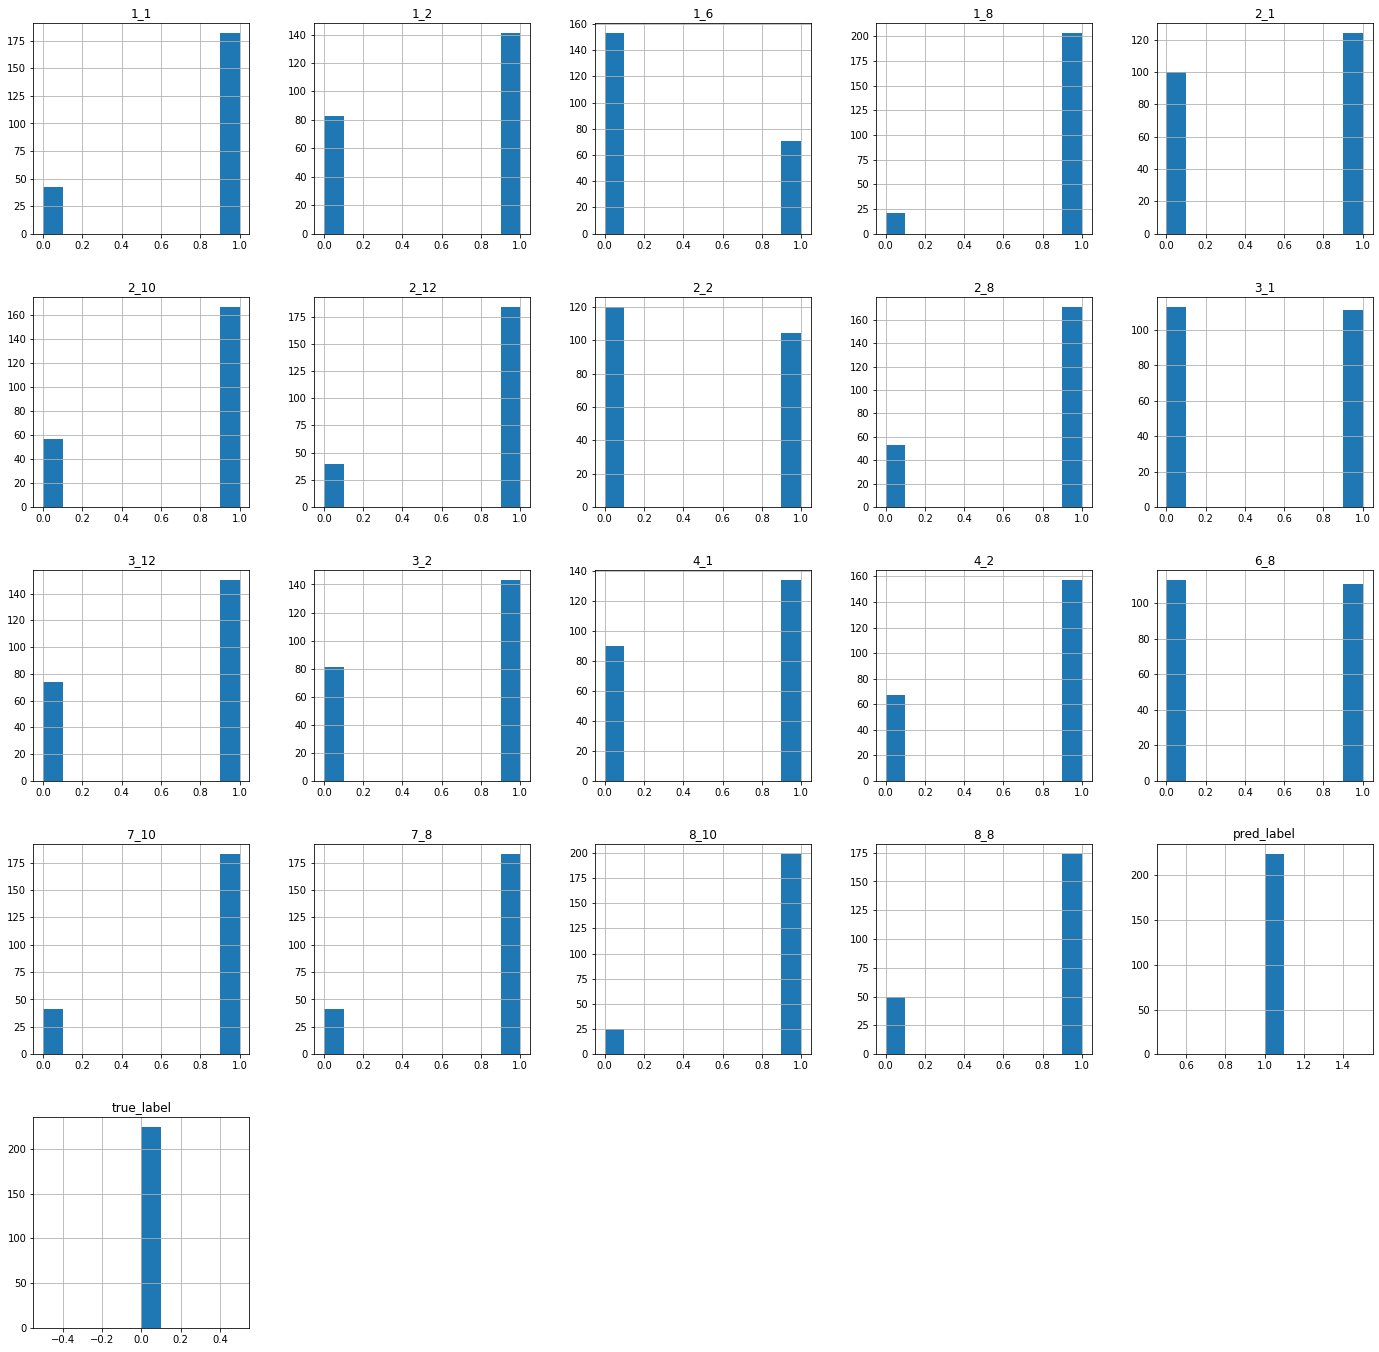

In [70]:
print_hist_models_predictions_fp(df_fp)

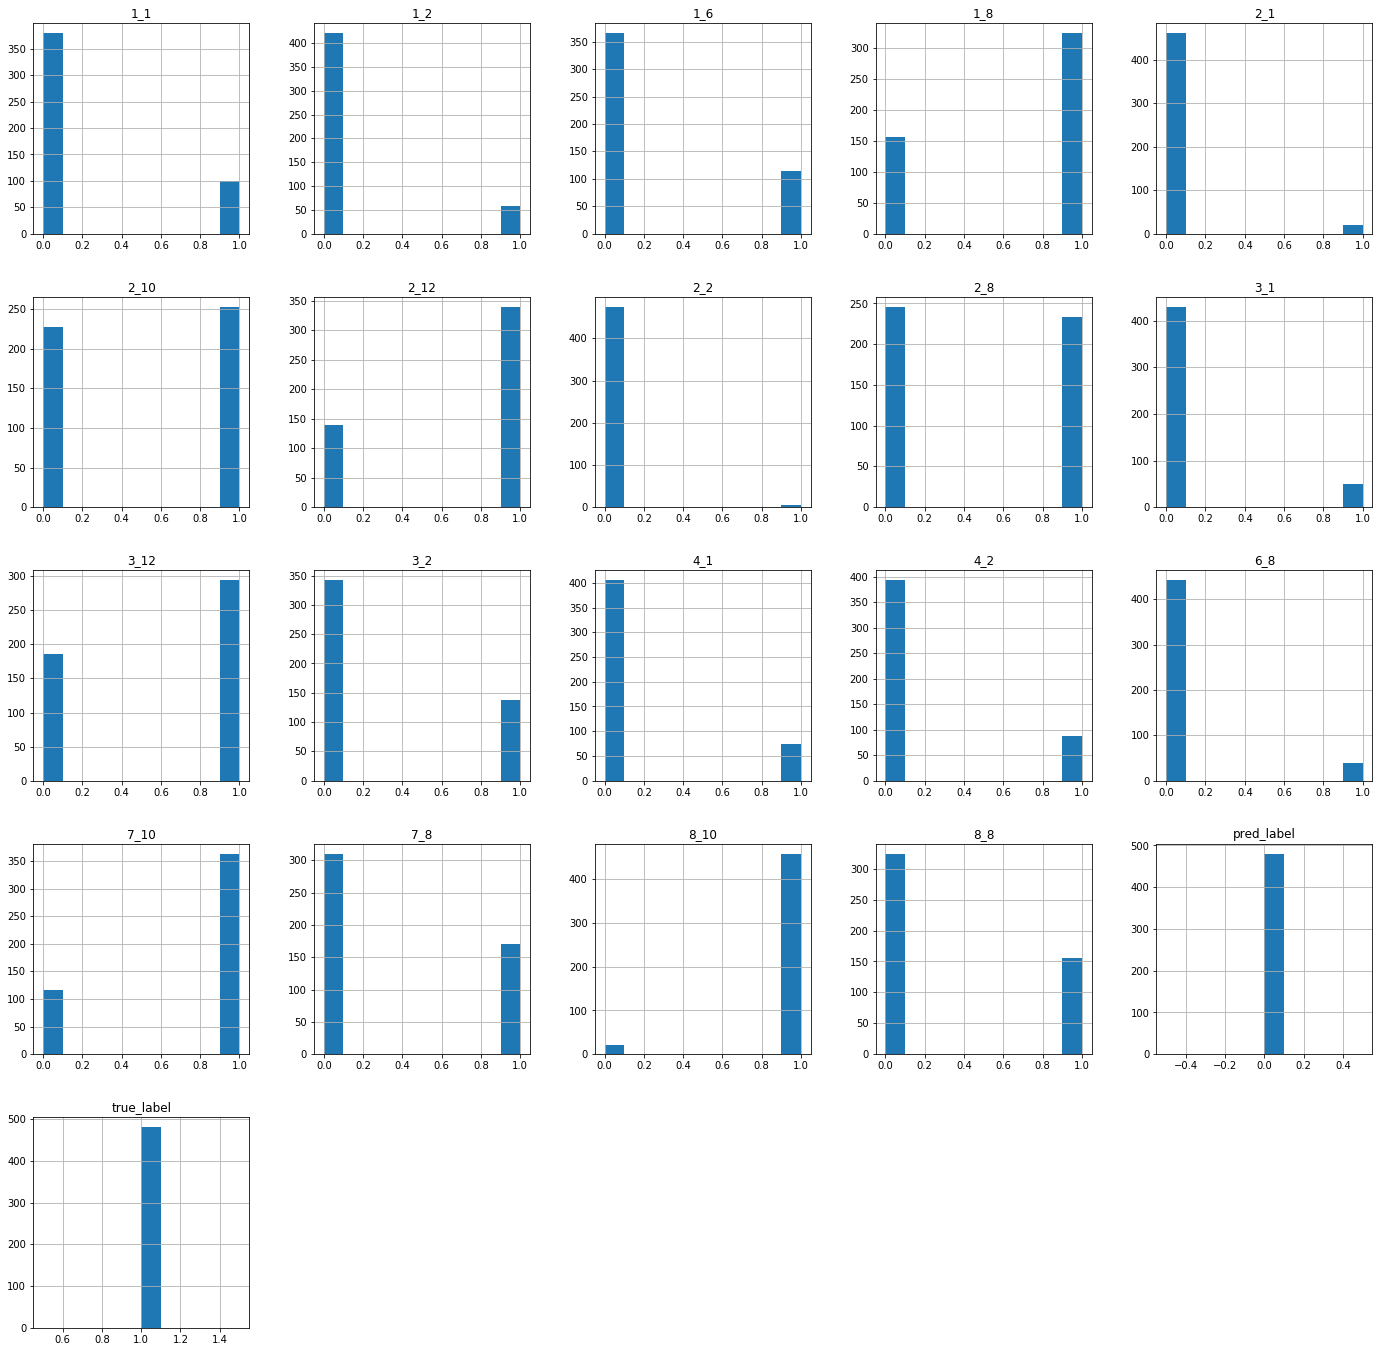

In [71]:
print_hist_models_predictions_fn(df_fn)

In [72]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.57      0.74      0.64       856
           1       0.75      0.58      0.65      1144

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.67      0.65      0.65      2000



In [73]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/majority_validation_2.csv"
df_res.to_csv(csv_path)